In [385]:
c1 = ['NGC 6823', 'Haffner 18', 'Haffner 19', 'NGC 7160',
 'NGC 6193', 'NGC 2401', 'NGC 2384', 'NGC 6871',
 'NGC 7380', 'Berkeley 7', 'Collinder 69', 'IC 4996']

In [386]:
c2 = ['Bochum 10', 'NGC 2362', 'Collinder 232', 'Hogg 10', 'NGC 6618', 'NGC 6231']

In [288]:
from astropy import units as u
from astropy.coordinates import SkyCoord
from sklearn.neighbors import NearestNeighbors
import scipy as sp
from scipy.spatial import distance
from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mpl_scatter_density 
from matplotlib.colors import LinearSegmentedColormap
from scipy.optimize import curve_fit
from sklearn.mixture import GaussianMixture
import networkx as nx
from sklearn.cluster import AgglomerativeClustering


import warnings
warnings.filterwarnings('ignore')

# AGE of Clusters

In [289]:
clusters = pd.read_excel('../../data/open clusters table.xlsx')
clusters = clusters[['Name', 'logt']].dropna(axis=0).drop(index=0)
clusters['logt'] = clusters.logt.astype(float)


clusters = pd.concat((clusters[clusters['Name'].isin(c1)], clusters[clusters['Name'].isin(c2)]))

clusters['Age'] = 10**clusters['logt'] 

In [290]:
clusters

Name   logt           Age
168     Berkeley 7  6.600  3.981072e+06
241   Collinder 69  7.050  1.122018e+07
324     Haffner 18  6.893  7.816278e+06
325     Haffner 19  6.934  8.590135e+06
367        IC 4996  6.948  8.871560e+06
551       NGC 2384  6.904  8.016781e+06
554       NGC 2401  9.000  1.000000e+09
667       NGC 6193  6.775  5.956621e+06
729       NGC 6823  6.820  6.606934e+06
734       NGC 6871  6.958  9.078205e+06
759       NGC 7160  7.278  1.896706e+07
768       NGC 7380  7.077  1.193988e+07
232      Bochum 10  6.857  7.194490e+06
261  Collinder 232  6.670  4.677351e+06
334        Hogg 10  6.784  6.081350e+06
547       NGC 2362  6.914  8.203515e+06
672       NGC 6231  6.843  6.966265e+06
707       NGC 6618  6.000  1.000000e+06

### Sample Query

```SQL

SELECT 
	gaia_source.source_id, gaia_source.ra,
	gaia_source.ra_error, gaia_source.dec,
	gaia_source.dec_error, gaia_source.parallax,
	gaia_source.parallax_error, gaia_source.pmra, 
	gaia_source.pmdec, gaia_source.phot_g_mean_mag, 
	gaia_source.bp_rp, gaia_source.bp_g, 
	gaia_source.g_rp, gaia_source.radial_velocity, 
	gaia_source.phot_variable_flag, 
	gaia_source.l, gaia_source.b, 
	gaia_source.teff_gspphot, gaia_source.distance_gspphot, 
	gaia_source.azero_gspphot, gaia_source.ag_gspphot, 
	gaia_source.ebpminrp_gspphot,
	edr3d.r_med_geo, edr3d.r_med_photogeo
FROM gaiadr3.gaia_source 
LEFT JOIN external.gaiaedr3_distance AS edr3d ON (gaia_source.source_id = edr3d.source_id )
WHERE 
CONTAINS(
    POINT('ICRS',gaiadr3.gaia_source.ra,gaiadr3.gaia_source.dec),
    CIRCLE(
        'ICRS',
        COORD1(EPOCH_PROP_POS(295.794,23.321,.4460,-1.6970,-5.3040,29.9300,2000,2016.0)),
        COORD2(EPOCH_PROP_POS(295.794,23.321,.4460,-1.6970,-5.3040,29.9300,2000,2016.0)),
        0.13333333333333333)
)=1

```

# Functions

In [328]:
def preprocess_cluster(data, g_mean_th=18):
    """
    ------
    parallax > 0 

    phot_g_mean_mag < g_mean_th
    ------
    """
    data = data[data['parallax'] > 0]
    data = data[data['phot_g_mean_mag'] < g_mean_th]
    data['Gmg'] = data['phot_g_mean_mag'] + (5 * np.log10(data['parallax']) - 10)
    data['L'] = 10**(0.4*(4.83 - data['Gmg']))
    print(len(data))
    return data


def cmd_plot(data, x_axis, y_axis, alpha=0.8, s=5):
    """
    -------
    plot isochrone
    -------
    """

    with plt.style.context(['ieee']):
        fig = plt.figure(figsize=(6,6), dpi=100)
        sns.scatterplot(data=data, y=y_axis, x=x_axis, alpha=alpha, s=s)
        plt.gca().invert_yaxis();
        
        
def joint_plot(data):

    plt.figure(dpi=90)
    sns.jointplot(
        data=data,
        x="pmra", y="pmdec",
        kind="kde"
        )
    plt.show()
    
    
def fit_curve(data, column, bins = 100):

    plt.figure(figsize=(8,2), dpi=80)
    counts, bins, patches = plt.hist(data[column], bins = bins)

    # Define the Gaussian function
    def gaussian(x, amp, mu, sigma):
        return amp * np.exp(-(x - mu)**2 / (2 * sigma**2))
    
    # data
    x_data = bins[:-1]
    y_data = counts
    
    # Fit the Gaussian function to the data
    popt, pcov = curve_fit(gaussian, x_data, y_data, maxfev=5000)
    
    plt.figure(figsize=(8,2), dpi=80)
    # Plot the original data and the fitted curve
    sns.scatterplot(x_data, y_data, label=column)
    plt.plot(x_data, gaussian(x_data, *popt), color='red', label='Fit')
    plt.legend()
    plt.show()
    
    return popt


def guassian_filter(data, column, mu, std):    
    up = round(mu + 3 * std, 2)
    low = round(mu - 3 * std, 2)
    
    if up > low:
        print(f'{column} upper bound:', up) 
        print(f'{column} lower bound:', low)
        df = data[(data[column] < up) & (data[column] > low)]
    else:
        print(f'{column} upper bound:', low) 
        print(f'{column} lower bound:', up)
        df = data[(data[column]< low) & (data[column] > up)]
    
    print('cluster length:', len(df))
    return df


def luminosity_density(cluster_3d, clusterdf):
    """
    --------
    cluster_3d --> measuring distance in that dataframe
    
    clusterdf --> main dataframe
    -------
    """
    # create a NearestNeighbors object and fit the dataset
    nbrs = NearestNeighbors(n_neighbors=6, metric='minkowski').fit(cluster_3d)

    # find the 5 nearest neighbors for each data point including itself
    distances, indices = nbrs.kneighbors(cluster_3d)

    # find maximum distance among 5 neighbors
    max_distances = np.amax(distances, axis=1)

    # sphere of that max distance
    spheres = (4/3) * np.pi * (max_distances ** 3)

    # sum of luminosities of each 6 nn
    lum_sum = []
    for i in range(len(clusterdf)):
        lum_sum.append(np.sum(clusterdf.iloc[indices[i]]['L']))

    # luminosity density
    lum_dens = lum_sum / spheres

    return lum_dens



def lum_plot(data):
    """
    --------
    plot for luminosity density profile
    --------
    """    
    
    with plt.style.context(['ieee']):
        plt.figure(figsize=(12,6), dpi=200)
        plt.plot(range(len(data)), np.sort(data))
        plt.ylabel('ΔL/ΔV')
        plt.title('luminosity density profile');

# DATA

In [292]:
df_NGC_6823 = pd.read_csv('../../data/NGC 6823-result.csv')
df_Haffner_18 = pd.read_csv('../../data/Haffner 18-result.csv')
df_Haffner_19 = pd.read_csv('../../data/Haffner 19-result.csv')
df_NGC_7160 = pd.read_csv('../../data/NGC 7160-result.csv')
df_NGC_6193 = pd.read_csv('../../data/NGC 6193-result.csv')
df_NGC_2401 = pd.read_csv('../../data/NGC 2401-result.csv')
df_NGC_2384 = pd.read_csv('../../data/NGC 2384-result.csv')
df_NGC_6871 = pd.read_csv('../../data/NGC 6871-result.csv')
df_NGC_7380 = pd.read_csv('../../data/NGC 7380-result.csv')
df_Berkeley_7 = pd.read_csv('../../data/Berkeley 7-result.csv')
df_Collinder_69  = pd.read_csv('../../data/Collinder 69-result.csv')
df_IC_4996 = pd.read_csv('../../data/IC 4996-result.csv')

In [293]:
df_Bochum_10 = pd.read_csv('../../data/Bochum 10-result.csv')
df_NGC_2362 = pd.read_csv('../../data/NGC 2362-result.csv') 
df_Collinder_232 = pd.read_csv('../../data/Collinder 232-result.csv')
df_Hogg_10 = pd.read_csv('../../data/Hogg 10-result.csv')
df_NGC_6618 =  pd.read_csv('../../data/NGC 6618-result.csv')
df_NGC_6231 = pd.read_csv('../../data/NGC 6231-result.csv')

### preprocess

In [294]:
df_NGC_6823 = preprocess_cluster(df_NGC_6823, g_mean_th=19)
df_Haffner_18 = preprocess_cluster(df_Haffner_18, g_mean_th=19)
df_Haffner_19 = preprocess_cluster(df_Haffner_19, g_mean_th=19)
df_NGC_7160 = preprocess_cluster(df_NGC_7160, g_mean_th=19)
df_NGC_6193 = preprocess_cluster(df_NGC_6193, g_mean_th=19)
df_NGC_2401 = preprocess_cluster(df_NGC_2401, g_mean_th=19)
df_NGC_2384 = preprocess_cluster(df_NGC_2384, g_mean_th=19)
df_NGC_6871 = preprocess_cluster(df_NGC_6871, g_mean_th=19)
df_NGC_7380 = preprocess_cluster(df_NGC_7380, g_mean_th=19)
df_Berkeley_7 = preprocess_cluster(df_Berkeley_7, g_mean_th=19)
df_Collinder_69 = preprocess_cluster(df_Collinder_69, g_mean_th=19)
df_IC_4996 = preprocess_cluster(df_IC_4996, g_mean_th=19)

df_Bochum_10 = preprocess_cluster(df_Bochum_10, g_mean_th=19)
df_NGC_2362 = preprocess_cluster(df_NGC_2362, g_mean_th=19)
df_Collinder_232 = preprocess_cluster(df_Collinder_232, g_mean_th=19)
df_Hogg_10 = preprocess_cluster(df_Hogg_10, g_mean_th=19)
df_NGC_6618 = preprocess_cluster(df_NGC_6618, g_mean_th=19)
df_NGC_6231 = preprocess_cluster(df_NGC_6231, g_mean_th=19)

1283
2285
884
5580
17247
458
1674
110567
5956
1635
123207
1429
4785
2126
4914
2478
755
13706


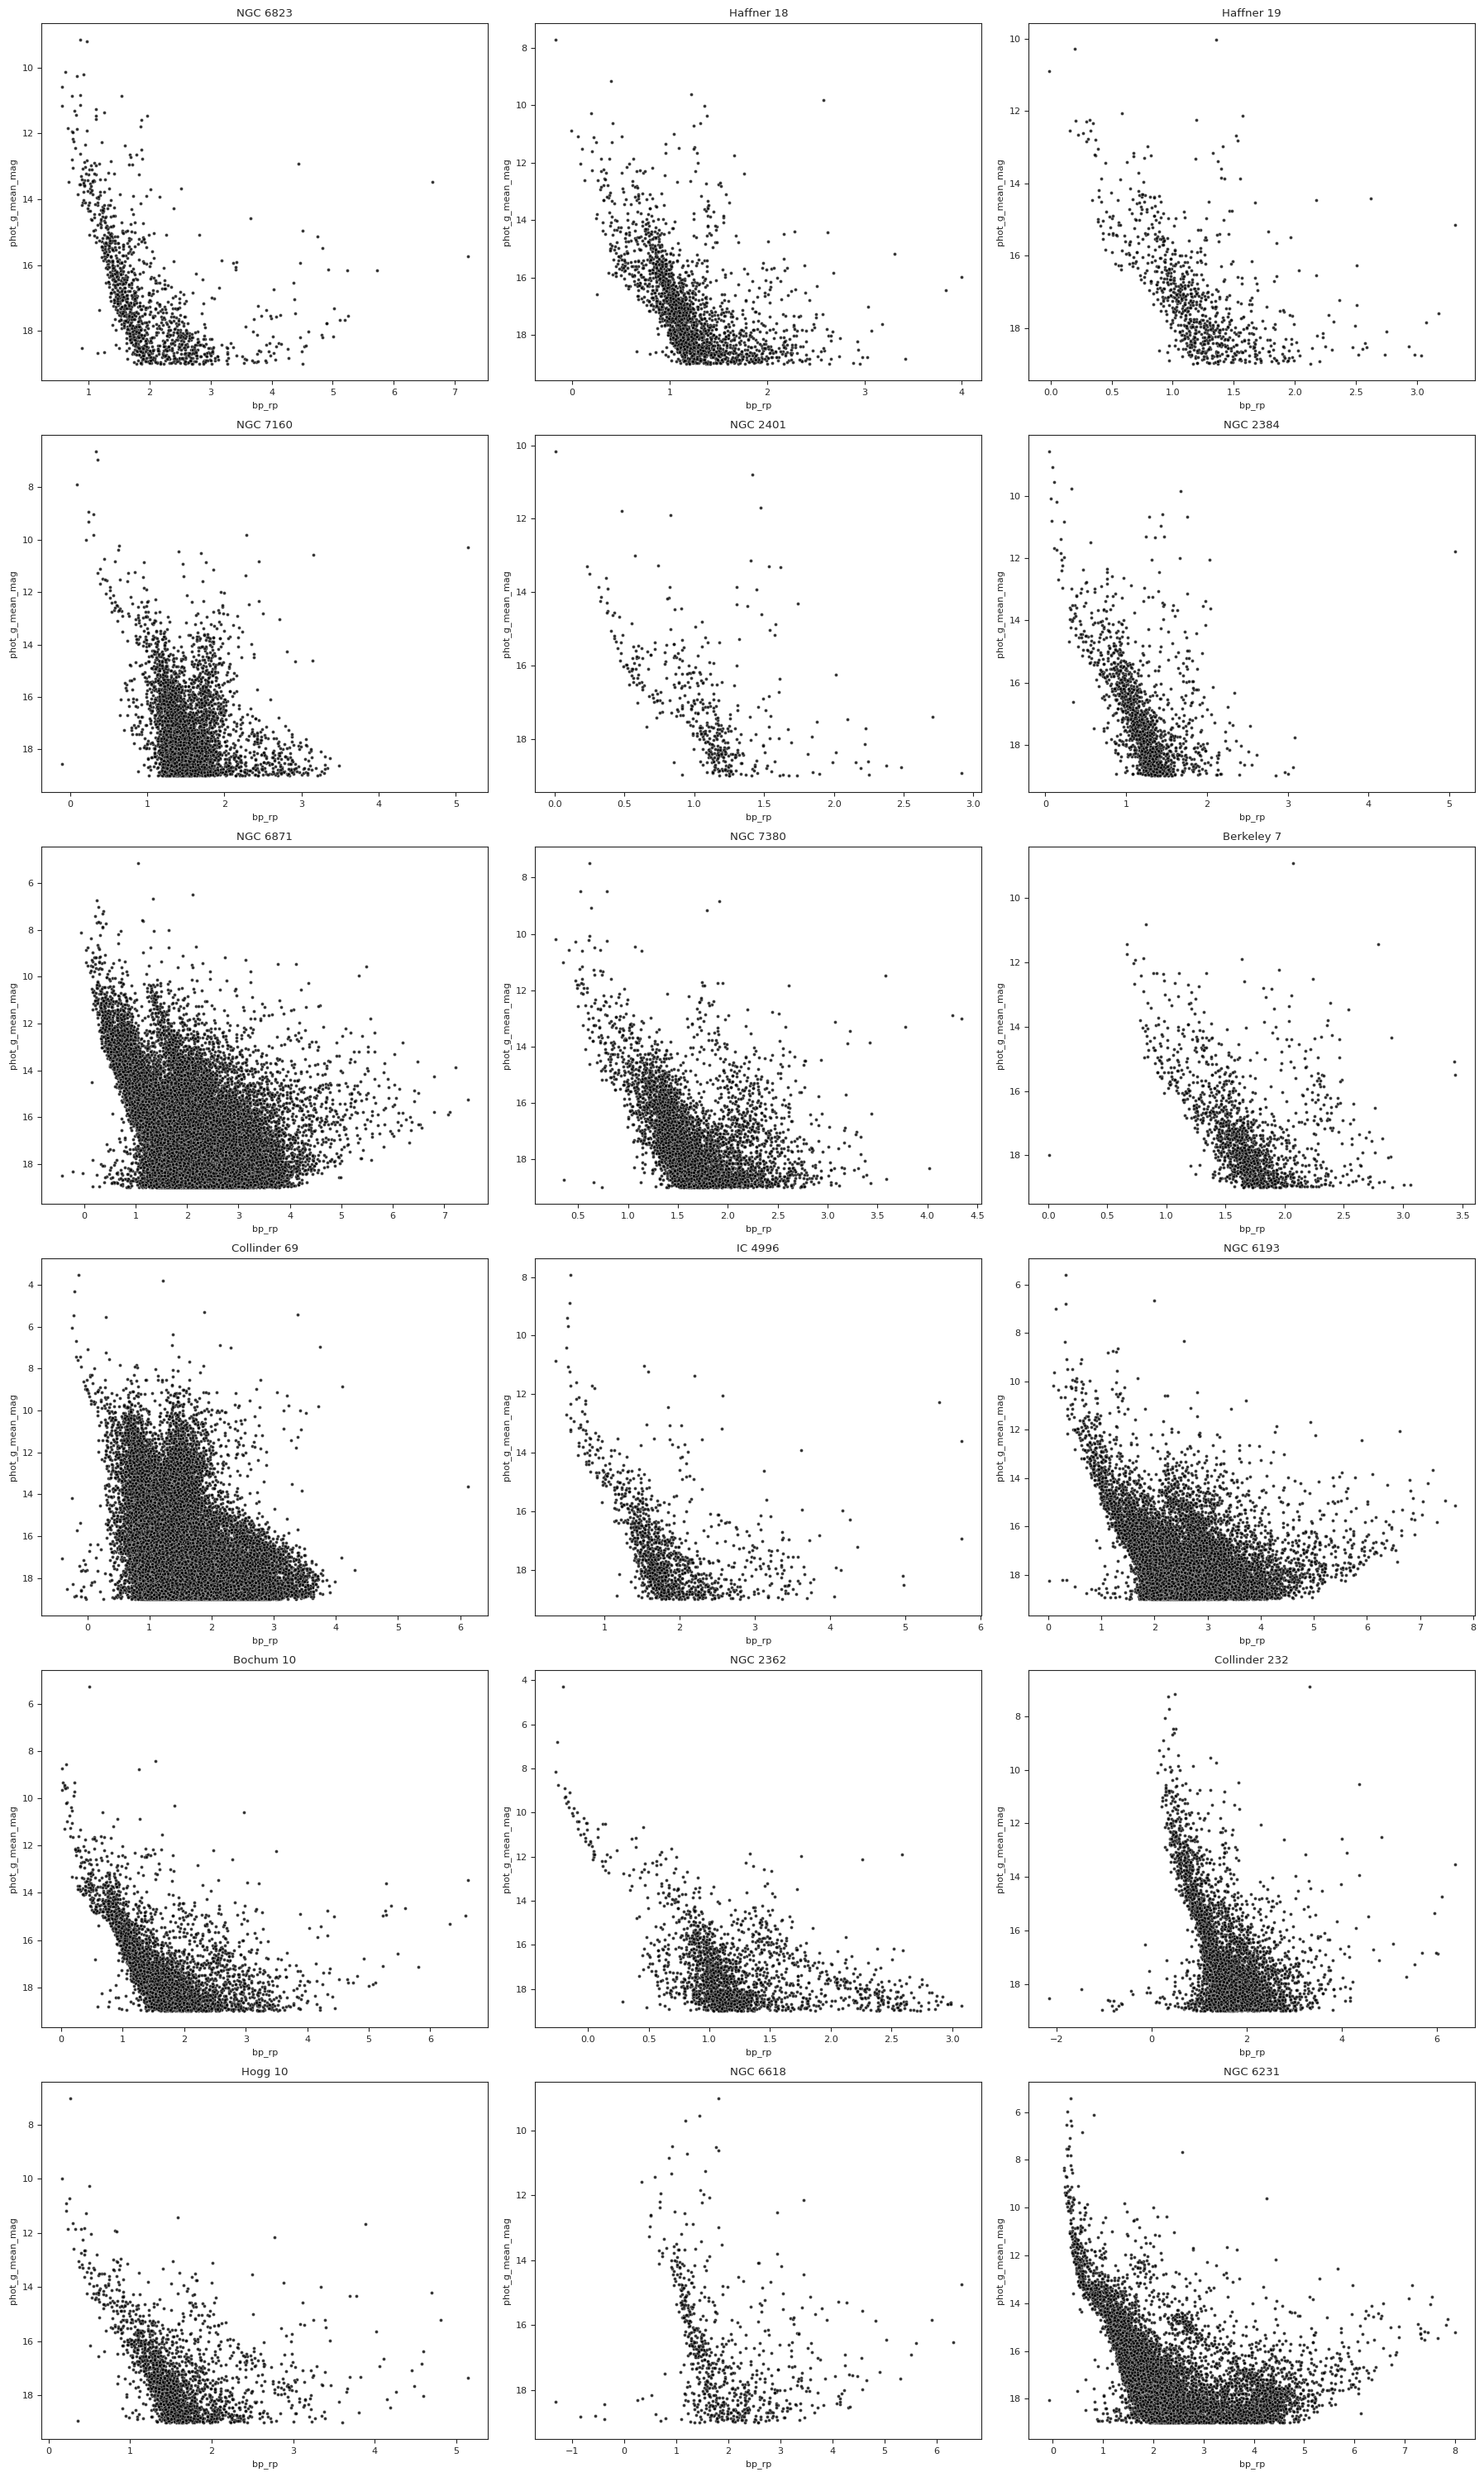

In [295]:
def cmd_plotly(data, x_axis, y_axis, ax=None, alpha=0.8, s=8):
    """
    -------
    plot isochrone
    -------
    """
    if ax is None:
        fig = plt.figure(figsize=(4,8), dpi=100)
        ax = fig.add_subplot(111)
    sns.scatterplot(data=data, y=y_axis, x=x_axis, alpha=alpha, s=s, ax=ax)
    ax.invert_yaxis()


with plt.style.context(['ieee']):
    fig, axes = plt.subplots(6, 3, figsize=(18, 30), dpi=100)

    cmd_plotly(df_NGC_6823, 'bp_rp', 'phot_g_mean_mag', ax=axes[0, 0])
    axes[0, 0].set_title('NGC 6823')

    cmd_plotly(df_Haffner_18, 'bp_rp', 'phot_g_mean_mag', ax=axes[0, 1])
    axes[0, 1].set_title('Haffner 18')

    cmd_plotly(df_Haffner_19, 'bp_rp', 'phot_g_mean_mag', ax=axes[0, 2])
    axes[0, 2].set_title('Haffner 19')

    cmd_plotly(df_NGC_7160, 'bp_rp', 'phot_g_mean_mag', ax=axes[1, 0])
    axes[1, 0].set_title('NGC 7160')

    cmd_plotly(df_NGC_2401, 'bp_rp', 'phot_g_mean_mag', ax=axes[1, 1])
    axes[1, 1].set_title('NGC 2401')

    cmd_plotly(df_NGC_2384, 'bp_rp', 'phot_g_mean_mag', ax=axes[1, 2])
    axes[1, 2].set_title('NGC 2384')

    cmd_plotly(df_NGC_6871, 'bp_rp', 'phot_g_mean_mag', ax=axes[2, 0])
    axes[2, 0].set_title('NGC 6871')

    cmd_plotly(df_NGC_7380, 'bp_rp', 'phot_g_mean_mag', ax=axes[2, 1])
    axes[2, 1].set_title('NGC 7380')

    cmd_plotly(df_Berkeley_7, 'bp_rp', 'phot_g_mean_mag', ax=axes[2, 2])
    axes[2, 2].set_title('Berkeley 7')

    cmd_plotly(df_Collinder_69, 'bp_rp', 'phot_g_mean_mag', ax=axes[3, 0])
    axes[3, 0].set_title('Collinder 69')

    cmd_plotly(df_IC_4996, 'bp_rp', 'phot_g_mean_mag', ax=axes[3, 1])
    axes[3, 1].set_title('IC 4996')
    
    cmd_plotly(df_NGC_6193, 'bp_rp', 'phot_g_mean_mag', ax=axes[3, 2])
    axes[3, 2].set_title('NGC 6193')
    
    cmd_plotly(df_Bochum_10, 'bp_rp', 'phot_g_mean_mag', ax=axes[4, 0])
    axes[4, 0].set_title('Bochum 10')

    cmd_plotly(df_NGC_2362, 'bp_rp', 'phot_g_mean_mag', ax=axes[4, 1])
    axes[4, 1].set_title('NGC 2362')

    cmd_plotly(df_Collinder_232, 'bp_rp', 'phot_g_mean_mag', ax=axes[4, 2])
    axes[4, 2].set_title('Collinder 232')
    
    cmd_plotly(df_Hogg_10, 'bp_rp', 'phot_g_mean_mag', ax=axes[5, 0])
    axes[5, 0].set_title('Hogg 10')

    cmd_plotly(df_NGC_6618, 'bp_rp', 'phot_g_mean_mag', ax=axes[5, 1])
    axes[5, 1].set_title('NGC 6618')

    cmd_plotly(df_NGC_6231, 'bp_rp', 'phot_g_mean_mag', ax=axes[5, 2])
    axes[5, 2].set_title('NGC 6231')


    plt.tight_layout()
    plt.show()

### columns

In [11]:
df_Bochum_10.columns

Index(['source_id', 'ra', 'ra_error', 'dec', 'dec_error', 'parallax',
       'parallax_error', 'pmra', 'pmdec', 'phot_g_mean_mag', 'bp_rp', 'bp_g',
       'g_rp', 'radial_velocity', 'phot_variable_flag', 'l', 'b',
       'teff_gspphot', 'distance_gspphot', 'azero_gspphot', 'ag_gspphot',
       'ebpminrp_gspphot', 'r_med_geo', 'r_med_photogeo', 'Gmg', 'L'],
      dtype='object')

## dropping some columns

In [296]:
def drop_columns(data):
    return data.drop(['source_id', 'ra_error', 'dec_error',
                      'parallax_error', 'radial_velocity',
                      'phot_variable_flag', 'l', 'b', 'teff_gspphot', 
                      'distance_gspphot', 'azero_gspphot', 'ag_gspphot',
                      'ebpminrp_gspphot', 'r_med_geo', 
                      'Gmg', 'L'], axis=1).dropna(axis=0)

In [297]:
df_NGC_6823_new = drop_columns(df_NGC_6823)
df_Haffner_18_new = drop_columns(df_Haffner_18)
df_Haffner_19_new = drop_columns(df_Haffner_19)
df_NGC_7160_new = drop_columns(df_NGC_7160)
df_NGC_6193_new = drop_columns(df_NGC_6193)
df_NGC_2401_new = drop_columns(df_NGC_2401)
df_NGC_2384_new = drop_columns(df_NGC_2384)
df_NGC_6871_new = drop_columns(df_NGC_6871)
df_NGC_7380_new = drop_columns(df_NGC_7380)
df_Berkeley_7_new = drop_columns(df_Berkeley_7)
df_Collinder_69_new = drop_columns(df_Collinder_69)
df_IC_4996_new = drop_columns(df_IC_4996)
df_Bochum_10_new = drop_columns(df_Bochum_10)
df_NGC_2362_new = drop_columns(df_NGC_2362)
df_Collinder_232_new = drop_columns(df_Collinder_232)
df_Hogg_10_new = drop_columns(df_Hogg_10)
df_NGC_6618_new = drop_columns(df_NGC_6618)
df_NGC_6231_new = drop_columns(df_NGC_6231)

### Clusters' proper motions

In [352]:
import requests

In [15]:
for cluster_name in c1:
    url = f"https://simbad.u-strasbg.fr/simbad/sim-basic?Ident={cluster_name}&submit=SIMBAD+search"
    html = requests.get(url).content
    df_list = pd.read_html(html)
    df = df_list[2].iloc[1][0]
    index = df_list[2].iloc[1][0].find('Proper motions')
    print(cluster_name)
    print(df[index:index+35])
    print()

NGC 6823
Proper motions mas/yr : -1.697 -5.3

Haffner 18
Proper motions mas/yr : -2.548 2.67

Haffner 19
Proper motions mas/yr : -2.494 2.50

NGC 7160
Proper motions mas/yr : -3.472 -1.3

NGC 6193
Proper motions mas/yr : 1.278 -4.11

NGC 2401
Proper motions mas/yr : -1.370 1.67

NGC 2384
Proper motions mas/yr : -3.99 2.28 

NGC 6871
Proper motions mas/yr : -3.129 -6.4

NGC 7380
Proper motions mas/yr : -2.517 -2.1

Berkeley 7
Proper motions mas/yr : -0.993 -0.1

Collinder 69
Proper motions mas/yr : 1.194 -2.11

IC 4996
Proper motions mas/yr : -2.681 -5.3



In [16]:
for cluster_name in c2:
    url = f"https://simbad.u-strasbg.fr/simbad/sim-basic?Ident={cluster_name}&submit=SIMBAD+search"
    html = requests.get(url).content
    df_list = pd.read_html(html)
    df = df_list[2].iloc[1][0]
    index = df_list[2].iloc[1][0].find('Proper motions')
    print(cluster_name)
    print(df[index:index+35])
    print()

Bochum 10
Proper motions mas/yr : -5.09 3.48 

NGC 2362
Proper motions mas/yr : -2.791 2.95

Collinder 232
Proper motions mas/yr : -4.79 4.14 

Hogg 10
Proper motions mas/yr : -6.201 1.75

NGC 6618
Proper motions mas/yr : 1.510 -1.74

NGC 6231
Proper motions mas/yr : -0.529 -2.1



## filter on proper motions

In [298]:
# Initial Filter on PMRA and PMDEC 

def filter_proper_motion(data, pmra, pmdec, d_pmra=1, d_pmdec=1.2):
    return data[(abs(data['pmra'] - pmra) < d_pmra) & (abs(data['pmdec'] - pmdec) < d_pmdec)]

In [449]:
#### TEMP CODE
df_NGC_6823_new = drop_columns(df_NGC_6823)
df_Haffner_18_new = drop_columns(df_Haffner_18)
df_Haffner_19_new = drop_columns(df_Haffner_19)
df_NGC_7160_new = drop_columns(df_NGC_7160)
df_NGC_6193_new = drop_columns(df_NGC_6193)
df_NGC_2401_new = drop_columns(df_NGC_2401)
df_NGC_2384_new = drop_columns(df_NGC_2384)
df_NGC_6871_new = drop_columns(df_NGC_6871)
df_NGC_7380_new = drop_columns(df_NGC_7380)
df_Berkeley_7_new = drop_columns(df_Berkeley_7)
df_Collinder_69_new = drop_columns(df_Collinder_69)
df_IC_4996_new = drop_columns(df_IC_4996)
df_Bochum_10_new = drop_columns(df_Bochum_10)
df_NGC_2362_new = drop_columns(df_NGC_2362)
df_Collinder_232_new = drop_columns(df_Collinder_232)
df_Hogg_10_new = drop_columns(df_Hogg_10)
df_NGC_6618_new = drop_columns(df_NGC_6618)
df_NGC_6231_new = drop_columns(df_NGC_6231)

In [450]:
df_NGC_6823_new = filter_proper_motion(df_NGC_6823_new, -1.697, -5.3)
df_Haffner_18_new = filter_proper_motion(df_Haffner_18_new, -2.548, 2.67, d_pmdec=.7)
df_Haffner_19_new = filter_proper_motion(df_Haffner_19_new, -2.494, 2.50, d_pmdec=.7)
df_NGC_7160_new = filter_proper_motion(df_NGC_7160_new, -3.472, -1.3, 0.8, .8)
df_NGC_6193_new = filter_proper_motion(df_NGC_6193_new, 1.278, -4.11)
df_NGC_2401_new = filter_proper_motion(df_NGC_2401_new, -1.370, 1.67)
df_NGC_2384_new = filter_proper_motion(df_NGC_2384_new, -3.99, 3.28, d_pmra=2,d_pmdec=1.3)
df_NGC_6871_new = filter_proper_motion(df_NGC_6871_new, -3.129, -6.4, d_pmra=0.5, d_pmdec=1.2)
df_NGC_7380_new = filter_proper_motion(df_NGC_7380_new, -2.517, -2.1, d_pmra=0.5)
df_Berkeley_7_new = filter_proper_motion(df_Berkeley_7_new, -0.993, -0.1, d_pmra=0.5, d_pmdec=0.5)
df_Collinder_69_new = filter_proper_motion(df_Collinder_69_new, 1.194, -2.11)
df_IC_4996_new = filter_proper_motion(df_IC_4996_new, -2.681, -5.3, d_pmdec=1)
df_Bochum_10_new = filter_proper_motion(df_Bochum_10_new, -5.09, 3.48, 0.9, 1.1)
df_NGC_2362_new = filter_proper_motion(df_NGC_2362_new, -2.791, 2.95, 0.5, 0.5)
df_Collinder_232_new = filter_proper_motion(df_Collinder_232_new, -4.79, 4.14, d_pmra=2, d_pmdec=3)
df_Hogg_10_new = filter_proper_motion(df_Hogg_10_new, -6.201, 1.75, d_pmra=.5, d_pmdec=.5)
# df_NGC_6618_new = filter_proper_motion(df_NGC_6618_new, 1.510, -1.74)
df_NGC_6231_new = filter_proper_motion(df_NGC_6231_new, -0.529, -2.1, .5, .5)

In [451]:
### filter NGC 6871 seperately
def double_filter_proper_motion(data, pmra, pmdec):
    return data[(abs(data['pmra'] - pmra) < .5) & (abs(data['pmdec'] - pmdec) < .5)]

df_Berkeley_7_new = double_filter_proper_motion(df_Berkeley_7_new, -0.993, -0.1)
df_Hogg_10_new = double_filter_proper_motion(df_Hogg_10_new, -6.201, 1.75)

In [452]:
# sns.jointplot(data=df_NGC_6618_new, x='pmra', y='pmdec', kind='kde')

# fitting guassians on the data

In [453]:
sns.set_style('ticks')

In [454]:
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj] # print name of variable

def guassian_fit_filter(data, parameter):
    print('\n',namestr(data, globals())[0])
    amp, mu, std = fit_curve(data, parameter, bins=80)
    return guassian_filter(data, parameter, mu, std)

### pmdec


 df_NGC_6823_new


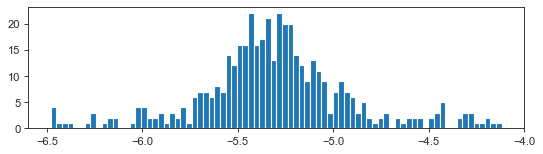

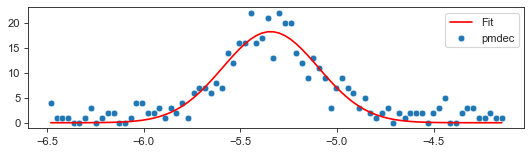

pmdec upper bound: -4.6
pmdec lower bound: -6.09
cluster length: 398

 df_Haffner_18_new


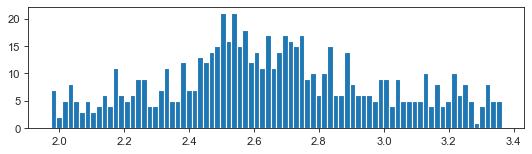

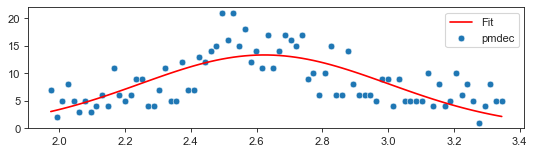

pmdec upper bound: 3.76
pmdec lower bound: 1.49
cluster length: 690

 df_Haffner_19_new


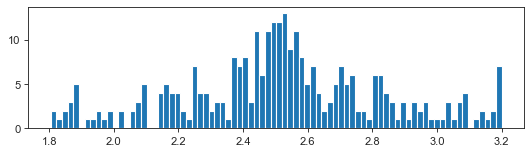

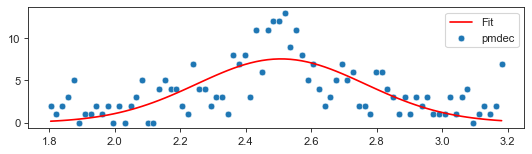

pmdec upper bound: 3.28
pmdec lower bound: 1.74
cluster length: 303

 df_NGC_7160_new


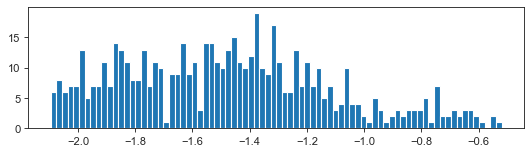

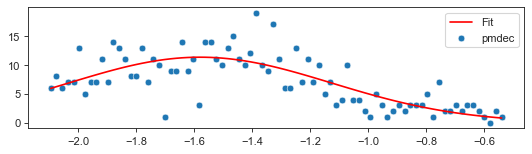

pmdec upper bound: -0.22
pmdec lower bound: -2.94
cluster length: 570

 df_NGC_6193_new


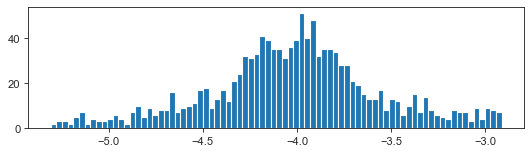

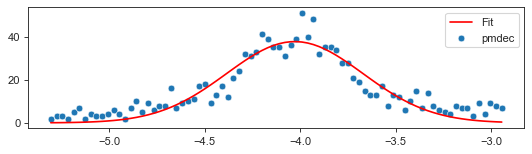

pmdec upper bound: -2.96
pmdec lower bound: -5.1
cluster length: 1203

 df_NGC_2401_new


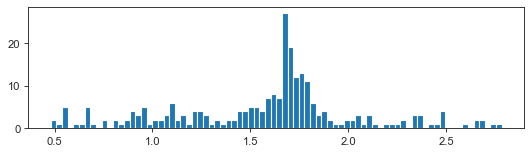

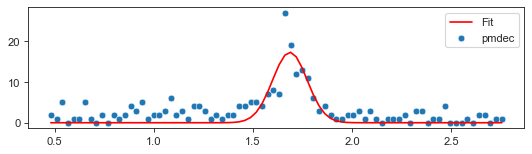

pmdec upper bound: 1.95
pmdec lower bound: 1.43
cluster length: 142

 df_NGC_2384_new


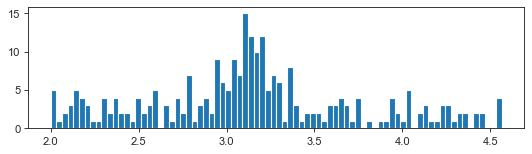

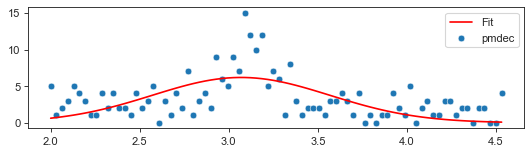

pmdec upper bound: 4.56
pmdec lower bound: 1.57
cluster length: 262

 df_NGC_6871_new


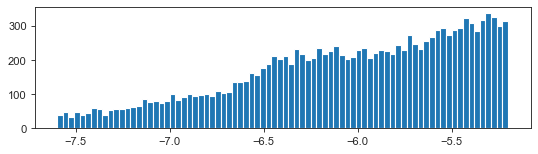

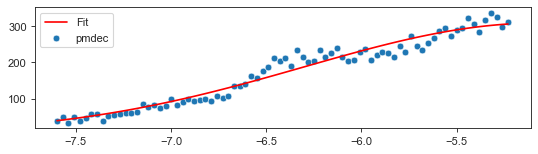

pmdec upper bound: -1.3
pmdec lower bound: -8.8
cluster length: 13790

 df_NGC_7380_new


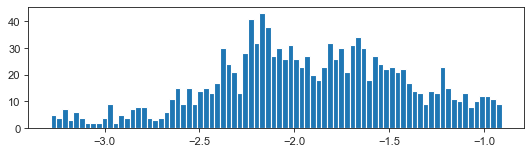

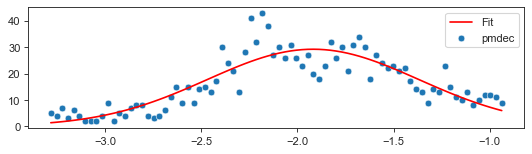

pmdec upper bound: -0.27
pmdec lower bound: -3.57
cluster length: 1313

 df_Berkeley_7_new


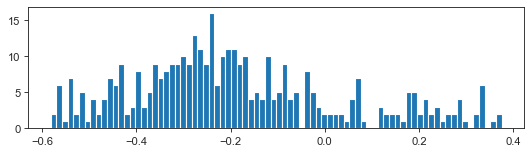

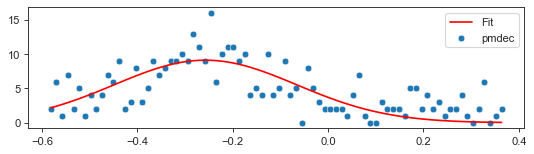

pmdec upper bound: 0.32
pmdec lower bound: -0.83
cluster length: 372

 df_Collinder_69_new


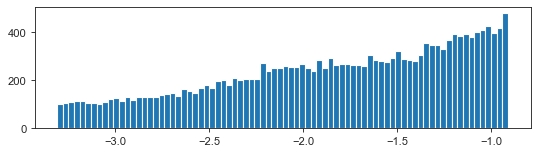

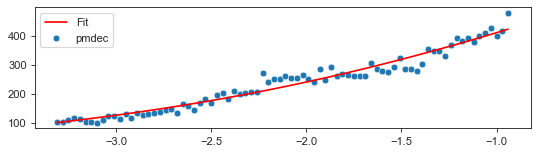

pmdec upper bound: 12.28
pmdec lower bound: -5.68
cluster length: 18910

 df_IC_4996_new


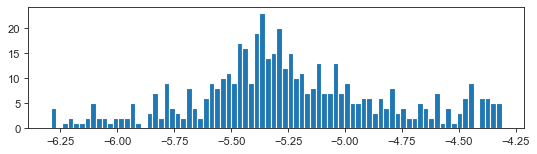

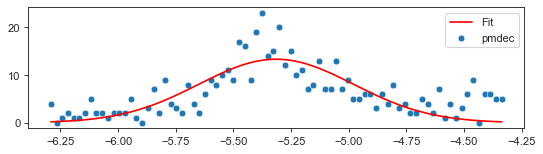

pmdec upper bound: -4.31
pmdec lower bound: -6.32
cluster length: 500

 df_Bochum_10_new


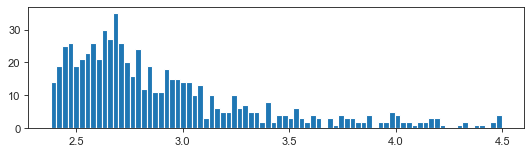

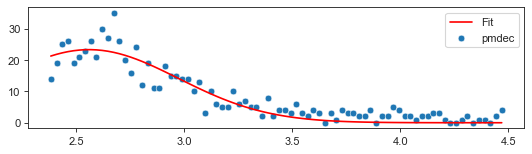

pmdec upper bound: 3.8
pmdec lower bound: 1.32
cluster length: 640

 df_NGC_2362_new


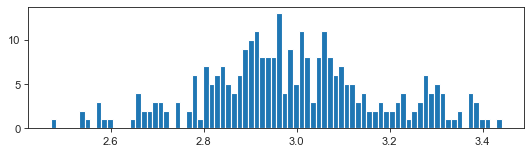

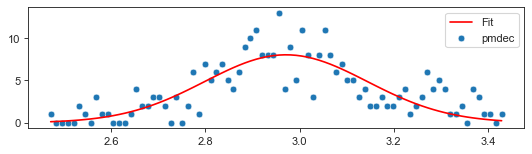

pmdec upper bound: 3.49
pmdec lower bound: 2.45
cluster length: 299

 df_Collinder_232_new


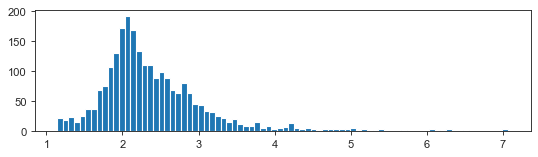

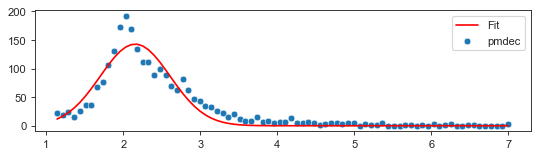

pmdec upper bound: 3.51
pmdec lower bound: 0.79
cluster length: 2242

 df_Hogg_10_new


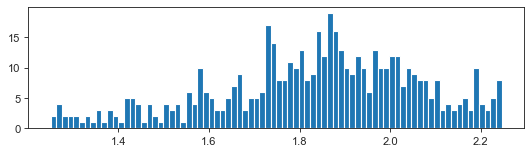

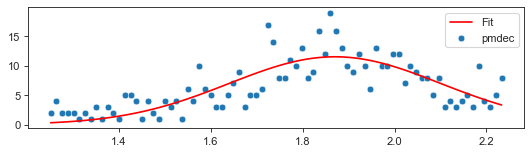

pmdec upper bound: 2.56
pmdec lower bound: 1.18
cluster length: 522

 df_NGC_6618_new


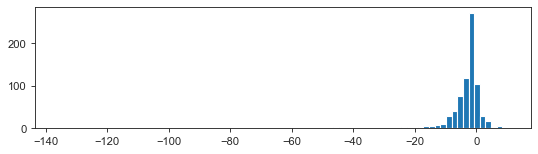

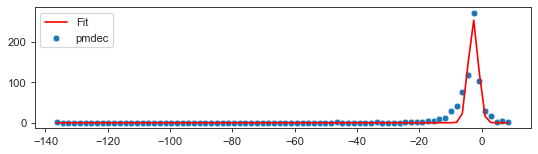

pmdec upper bound: 2.19
pmdec lower bound: -7.47
cluster length: 618

 df_NGC_6231_new


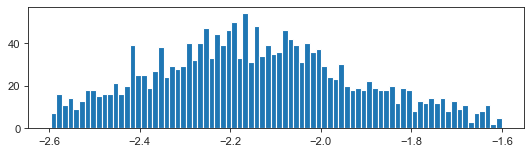

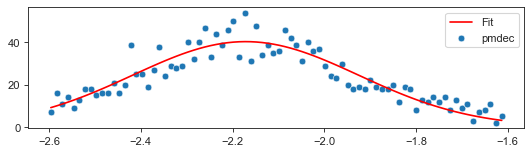

pmdec upper bound: -1.43
pmdec lower bound: -2.91
cluster length: 1922


In [455]:
df_NGC_6823_new = guassian_fit_filter(df_NGC_6823_new, 'pmdec')
df_Haffner_18_new = guassian_fit_filter(df_Haffner_18_new, 'pmdec')
df_Haffner_19_new = guassian_fit_filter(df_Haffner_19_new, 'pmdec')
df_NGC_7160_new = guassian_fit_filter(df_NGC_7160_new, 'pmdec')
df_NGC_6193_new = guassian_fit_filter(df_NGC_6193_new, 'pmdec')
df_NGC_2401_new = guassian_fit_filter(df_NGC_2401_new, 'pmdec')
df_NGC_2384_new = guassian_fit_filter(df_NGC_2384_new, 'pmdec')
df_NGC_6871_new = guassian_fit_filter(df_NGC_6871_new, 'pmdec')
df_NGC_7380_new = guassian_fit_filter(df_NGC_7380_new, 'pmdec')
df_Berkeley_7_new = guassian_fit_filter(df_Berkeley_7_new, 'pmdec')
df_Collinder_69_new = guassian_fit_filter(df_Collinder_69_new, 'pmdec')
df_IC_4996_new = guassian_fit_filter(df_IC_4996_new, 'pmdec')
df_Bochum_10_new = guassian_fit_filter(df_Bochum_10_new, 'pmdec')
df_NGC_2362_new = guassian_fit_filter(df_NGC_2362_new, 'pmdec')
df_Collinder_232_new = guassian_fit_filter(df_Collinder_232_new, 'pmdec')
df_Hogg_10_new = guassian_fit_filter(df_Hogg_10_new, 'pmdec')
df_NGC_6618_new = guassian_fit_filter(df_NGC_6618_new, 'pmdec')
df_NGC_6231_new = guassian_fit_filter(df_NGC_6231_new, 'pmdec')


 df_NGC_6823_new


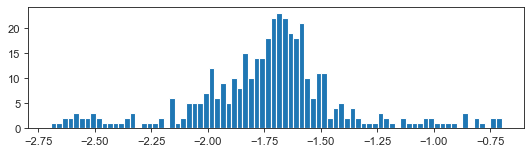

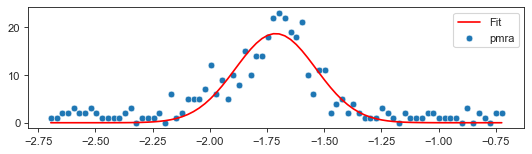

pmra upper bound: -1.18
pmra lower bound: -2.24
cluster length: 345

 df_Haffner_18_new


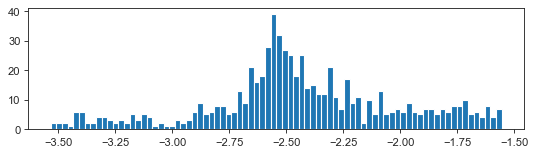

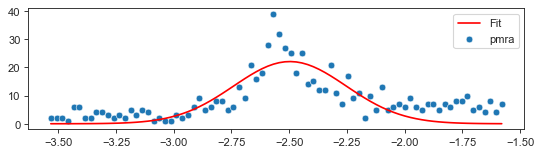

pmra upper bound: -1.77
pmra lower bound: -3.23
cluster length: 596

 df_Haffner_19_new


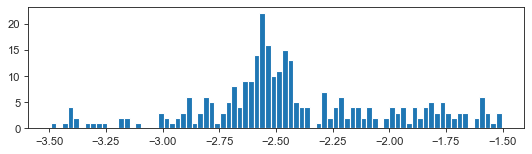

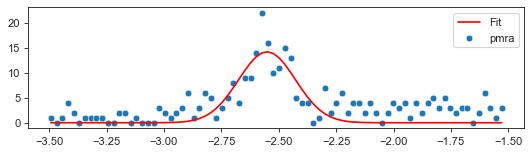

pmra upper bound: -2.18
pmra lower bound: -2.92
cluster length: 199

 df_NGC_7160_new


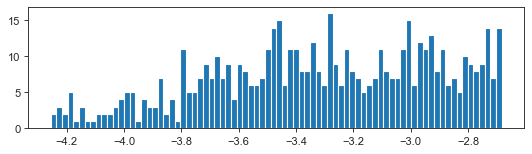

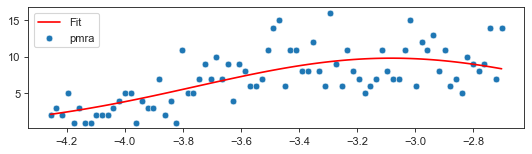

pmra upper bound: -1.06
pmra lower bound: -5.1
cluster length: 570

 df_NGC_6193_new


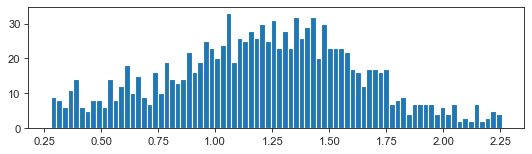

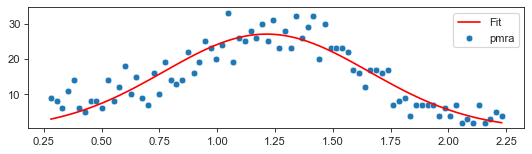

pmra upper bound: 2.55
pmra lower bound: -0.12
cluster length: 1203

 df_NGC_2401_new


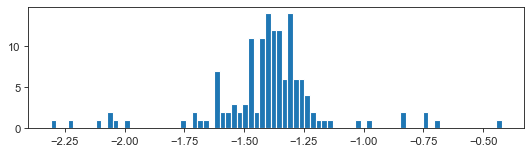

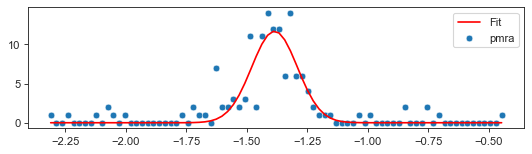

pmra upper bound: -1.1
pmra lower bound: -1.67
cluster length: 123

 df_NGC_2384_new


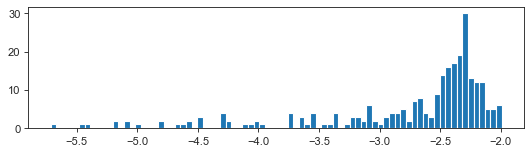

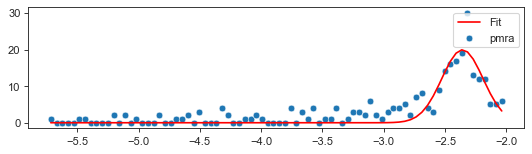

pmra upper bound: -1.85
pmra lower bound: -2.86
cluster length: 189

 df_NGC_6871_new


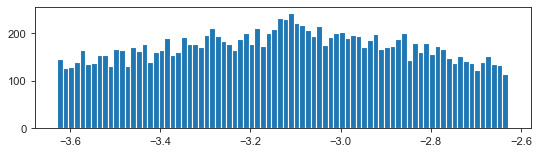

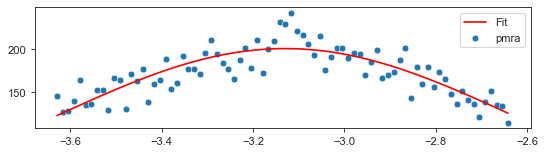

pmra upper bound: -1.61
pmra lower bound: -4.65
cluster length: 13790

 df_NGC_7380_new


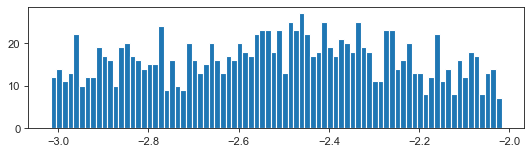

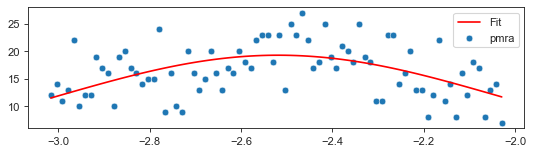

pmra upper bound: -1.05
pmra lower bound: -3.99
cluster length: 1313

 df_Berkeley_7_new


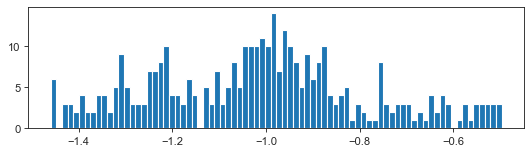

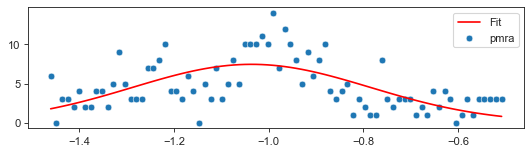

pmra upper bound: -0.29
pmra lower bound: -1.79
cluster length: 372

 df_Collinder_69_new


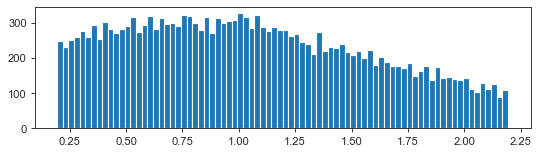

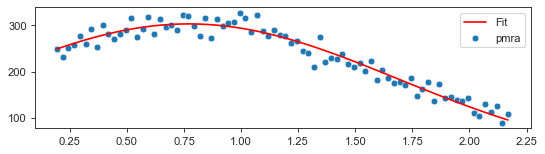

pmra upper bound: 3.52
pmra lower bound: -1.98
cluster length: 18910

 df_IC_4996_new


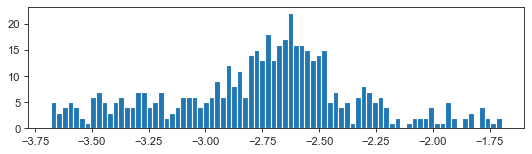

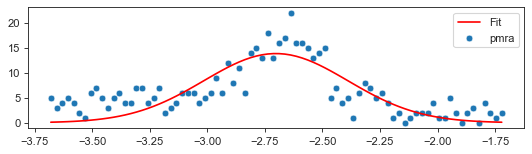

pmra upper bound: -1.76
pmra lower bound: -3.64
cluster length: 490

 df_Bochum_10_new


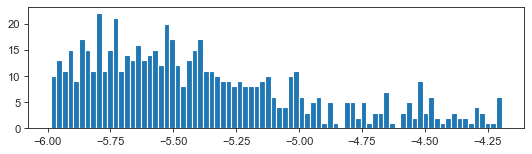

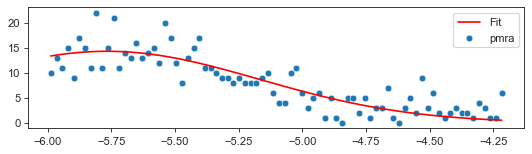

pmra upper bound: -3.97
pmra lower bound: -7.57
cluster length: 640

 df_NGC_2362_new


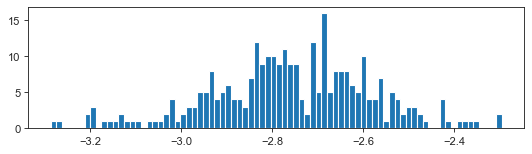

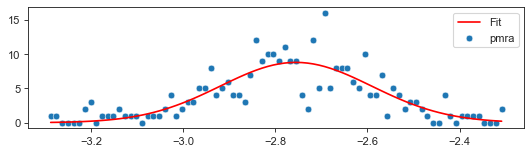

pmra upper bound: -2.26
pmra lower bound: -3.25
cluster length: 297

 df_Collinder_232_new


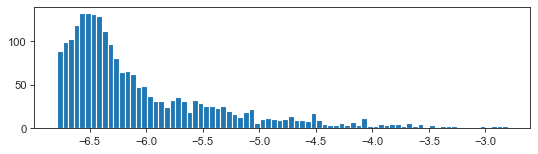

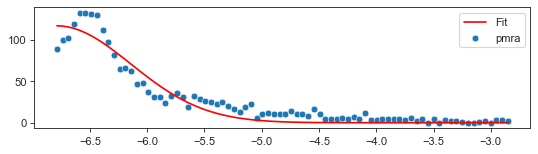

pmra upper bound: -4.85
pmra lower bound: -8.73
cluster length: 2042

 df_Hogg_10_new


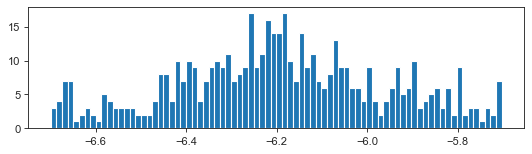

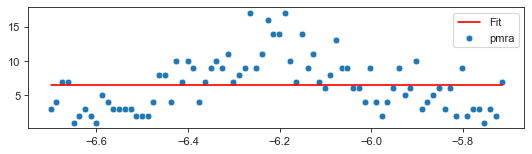

pmra upper bound: 402653187.99
pmra lower bound: -402653185.99
cluster length: 522

 df_NGC_6618_new


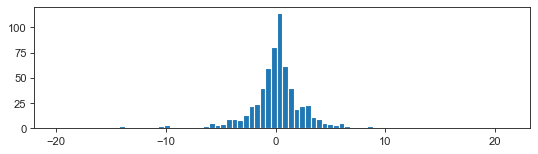

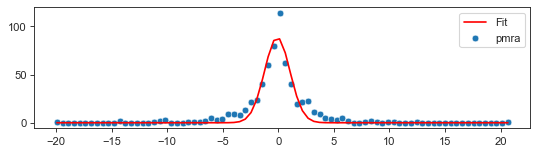

pmra upper bound: 3.34
pmra lower bound: -3.53
cluster length: 533

 df_NGC_6231_new


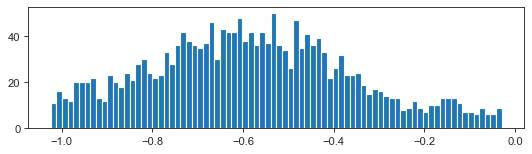

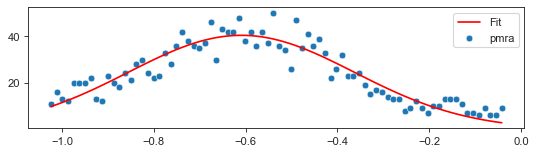

pmra upper bound: 0.13
pmra lower bound: -1.35
cluster length: 1922


In [456]:
df_NGC_6823_new = guassian_fit_filter(df_NGC_6823_new, 'pmra')
df_Haffner_18_new = guassian_fit_filter(df_Haffner_18_new, 'pmra')
df_Haffner_19_new = guassian_fit_filter(df_Haffner_19_new, 'pmra')
df_NGC_7160_new = guassian_fit_filter(df_NGC_7160_new, 'pmra')
df_NGC_6193_new = guassian_fit_filter(df_NGC_6193_new, 'pmra')
df_NGC_2401_new = guassian_fit_filter(df_NGC_2401_new, 'pmra')
df_NGC_2384_new = guassian_fit_filter(df_NGC_2384_new, 'pmra')
df_NGC_6871_new = guassian_fit_filter(df_NGC_6871_new, 'pmra')
df_NGC_7380_new = guassian_fit_filter(df_NGC_7380_new, 'pmra')
df_Berkeley_7_new = guassian_fit_filter(df_Berkeley_7_new, 'pmra')
df_Collinder_69_new = guassian_fit_filter(df_Collinder_69_new, 'pmra')
df_IC_4996_new = guassian_fit_filter(df_IC_4996_new, 'pmra')
df_Bochum_10_new = guassian_fit_filter(df_Bochum_10_new, 'pmra')
df_NGC_2362_new = guassian_fit_filter(df_NGC_2362_new, 'pmra')
df_Collinder_232_new = guassian_fit_filter(df_Collinder_232_new, 'pmra')
df_Hogg_10_new = guassian_fit_filter(df_Hogg_10_new, 'pmra')
df_NGC_6618_new = guassian_fit_filter(df_NGC_6618_new, 'pmra')
df_NGC_6231_new = guassian_fit_filter(df_NGC_6231_new, 'pmra')

In [457]:
def filter_parallax(data, parallax, delta = 0.2):
    return data[(abs(data['parallax'] - parallax) < delta)]
df_NGC_7160_new = filter_parallax(df_NGC_7160_new, 1.050) # filter parallax
df_NGC_6871_new = filter_parallax(df_NGC_6871_new, 0.514) # filter parallax
df_Collinder_69_new = filter_parallax(df_Collinder_69_new, 2.462) # filter parallax
df_IC_4996_new = filter_parallax(df_IC_4996_new, 0.487) # filter parallax

df_NGC_6231_new = filter_parallax(df_NGC_6231_new, 0.487, 0.2) # filter parallax


 df_NGC_6823_new


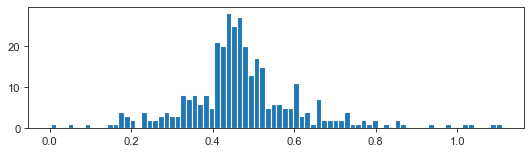

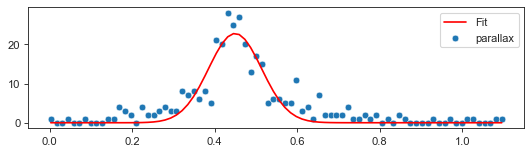

parallax upper bound: 0.64
parallax lower bound: 0.26
cluster length: 288

 df_Haffner_18_new


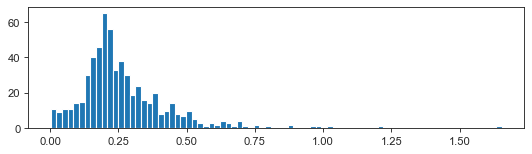

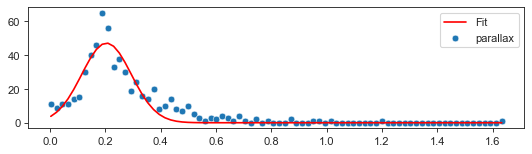

parallax upper bound: 0.47
parallax lower bound: -0.07
cluster length: 539

 df_Haffner_19_new


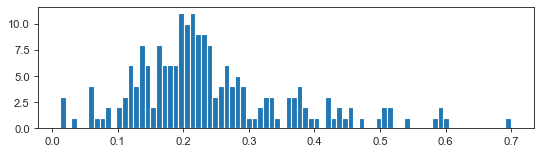

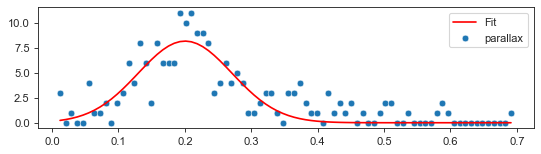

parallax upper bound: 0.41
parallax lower bound: -0.01
cluster length: 178

 df_NGC_7160_new


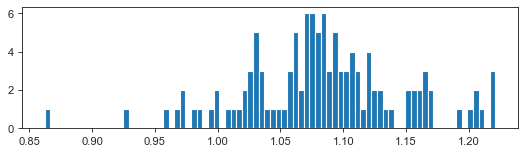

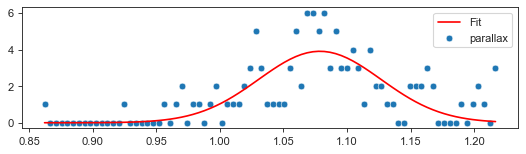

parallax upper bound: 1.22
parallax lower bound: 0.93
cluster length: 111

 df_NGC_6193_new


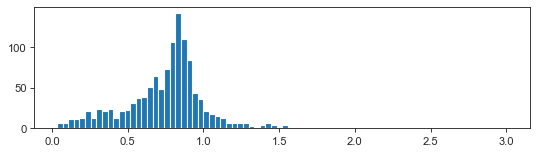

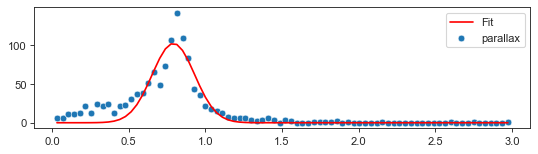

parallax upper bound: 1.21
parallax lower bound: 0.38
cluster length: 1019

 df_NGC_2401_new


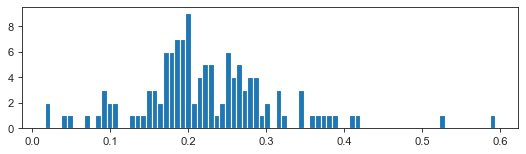

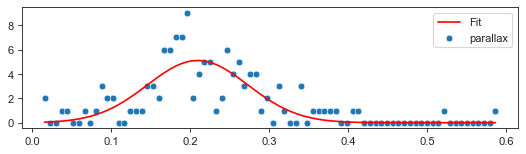

parallax upper bound: 0.4
parallax lower bound: 0.02
cluster length: 117

 df_NGC_2384_new


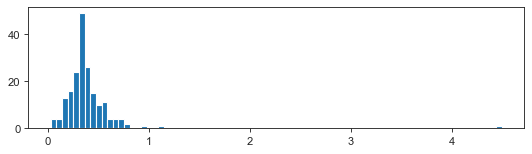

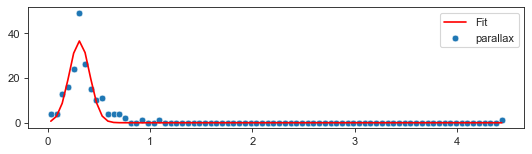

parallax upper bound: 0.61
parallax lower bound: 0.01
cluster length: 173

 df_NGC_6871_new


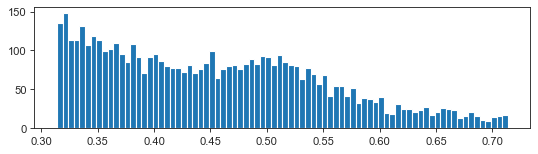

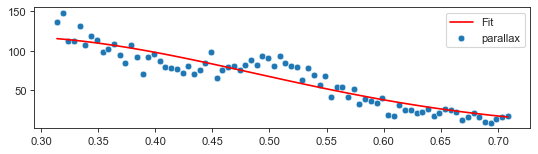

parallax upper bound: 0.93
parallax lower bound: -0.41
cluster length: 5167

 df_NGC_7380_new


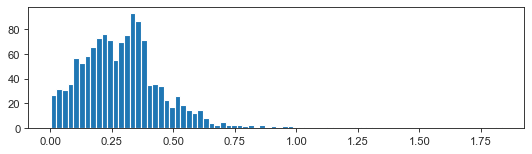

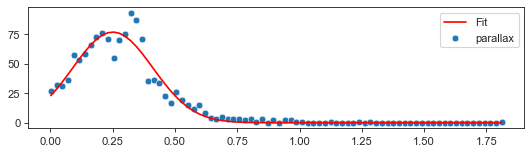

parallax upper bound: 0.73
parallax lower bound: -0.23
cluster length: 1285

 df_Berkeley_7_new


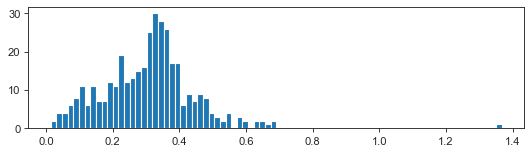

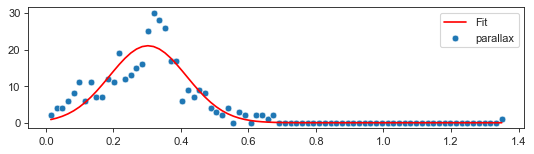

parallax upper bound: 0.64
parallax lower bound: -0.04
cluster length: 366

 df_Collinder_69_new


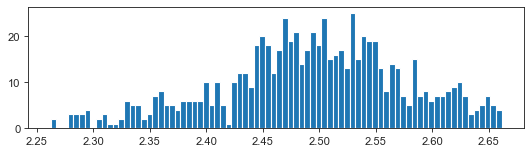

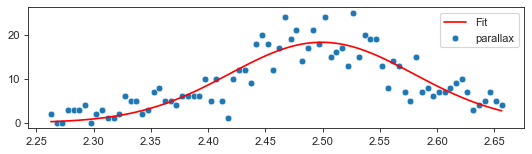

parallax upper bound: 2.74
parallax lower bound: 2.26
cluster length: 746

 df_IC_4996_new


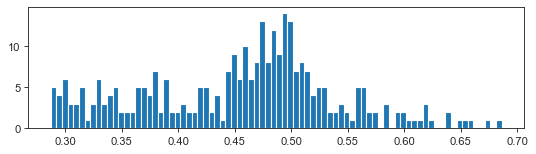

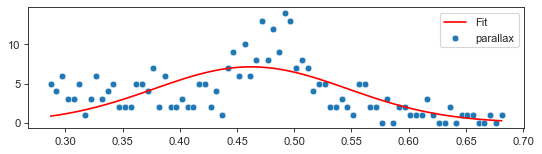

parallax upper bound: 0.72
parallax lower bound: 0.21
cluster length: 307

 df_Bochum_10_new


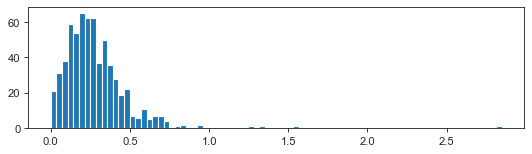

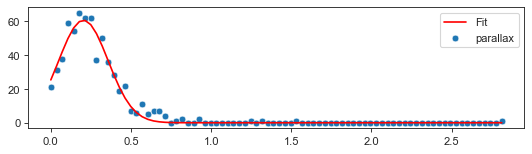

parallax upper bound: 0.67
parallax lower bound: -0.26
cluster length: 619

 df_NGC_2362_new


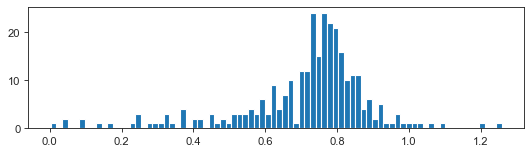

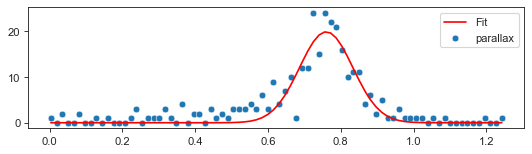

parallax upper bound: 0.98
parallax lower bound: 0.54
cluster length: 250

 df_Collinder_232_new


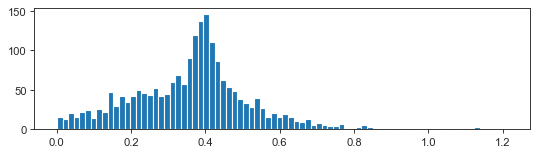

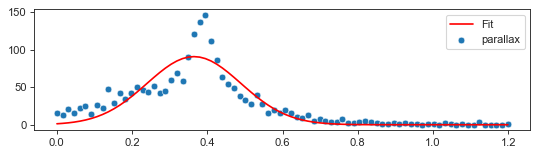

parallax upper bound: 0.74
parallax lower bound: -0.01
cluster length: 1994

 df_Hogg_10_new


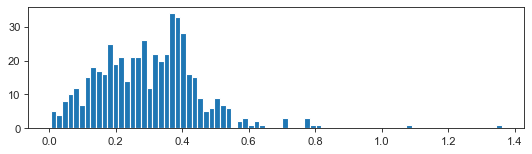

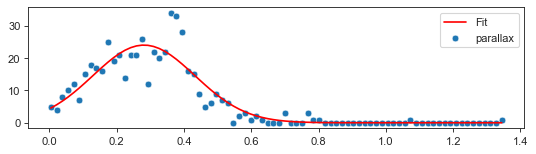

parallax upper bound: 0.74
parallax lower bound: -0.17
cluster length: 515

 df_NGC_6618_new


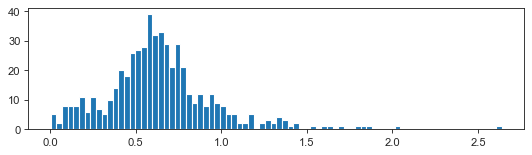

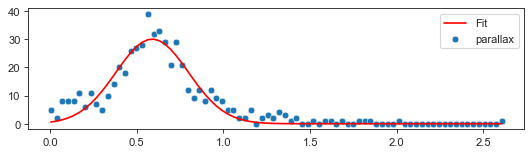

parallax upper bound: 1.22
parallax lower bound: -0.04
cluster length: 507

 df_NGC_6231_new


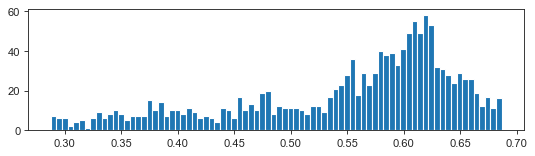

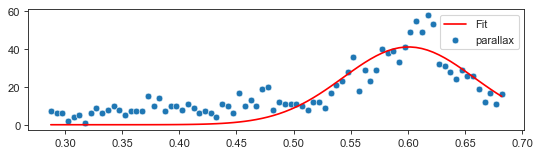

parallax upper bound: 0.77
parallax lower bound: 0.43
cluster length: 1178


In [458]:
df_NGC_6823_new = guassian_fit_filter(df_NGC_6823_new, 'parallax')
df_Haffner_18_new = guassian_fit_filter(df_Haffner_18_new, 'parallax')
df_Haffner_19_new = guassian_fit_filter(df_Haffner_19_new, 'parallax')
df_NGC_7160_new = guassian_fit_filter(df_NGC_7160_new, 'parallax') #
df_NGC_6193_new = guassian_fit_filter(df_NGC_6193_new, 'parallax')
df_NGC_2401_new = guassian_fit_filter(df_NGC_2401_new, 'parallax')
df_NGC_2384_new = guassian_fit_filter(df_NGC_2384_new, 'parallax')
df_NGC_6871_new = guassian_fit_filter(df_NGC_6871_new, 'parallax')
df_NGC_7380_new = guassian_fit_filter(df_NGC_7380_new, 'parallax')
df_Berkeley_7_new = guassian_fit_filter(df_Berkeley_7_new, 'parallax')
df_Collinder_69_new = guassian_fit_filter(df_Collinder_69_new, 'parallax')
df_IC_4996_new = guassian_fit_filter(df_IC_4996_new, 'parallax')
df_Bochum_10_new = guassian_fit_filter(df_Bochum_10_new, 'parallax')
df_NGC_2362_new = guassian_fit_filter(df_NGC_2362_new, 'parallax')
df_Collinder_232_new = guassian_fit_filter(df_Collinder_232_new, 'parallax')
df_Hogg_10_new = guassian_fit_filter(df_Hogg_10_new, 'parallax')
df_NGC_6618_new = guassian_fit_filter(df_NGC_6618_new, 'parallax') #
df_NGC_6231_new = guassian_fit_filter(df_NGC_6231_new, 'parallax')

### plot after fitting

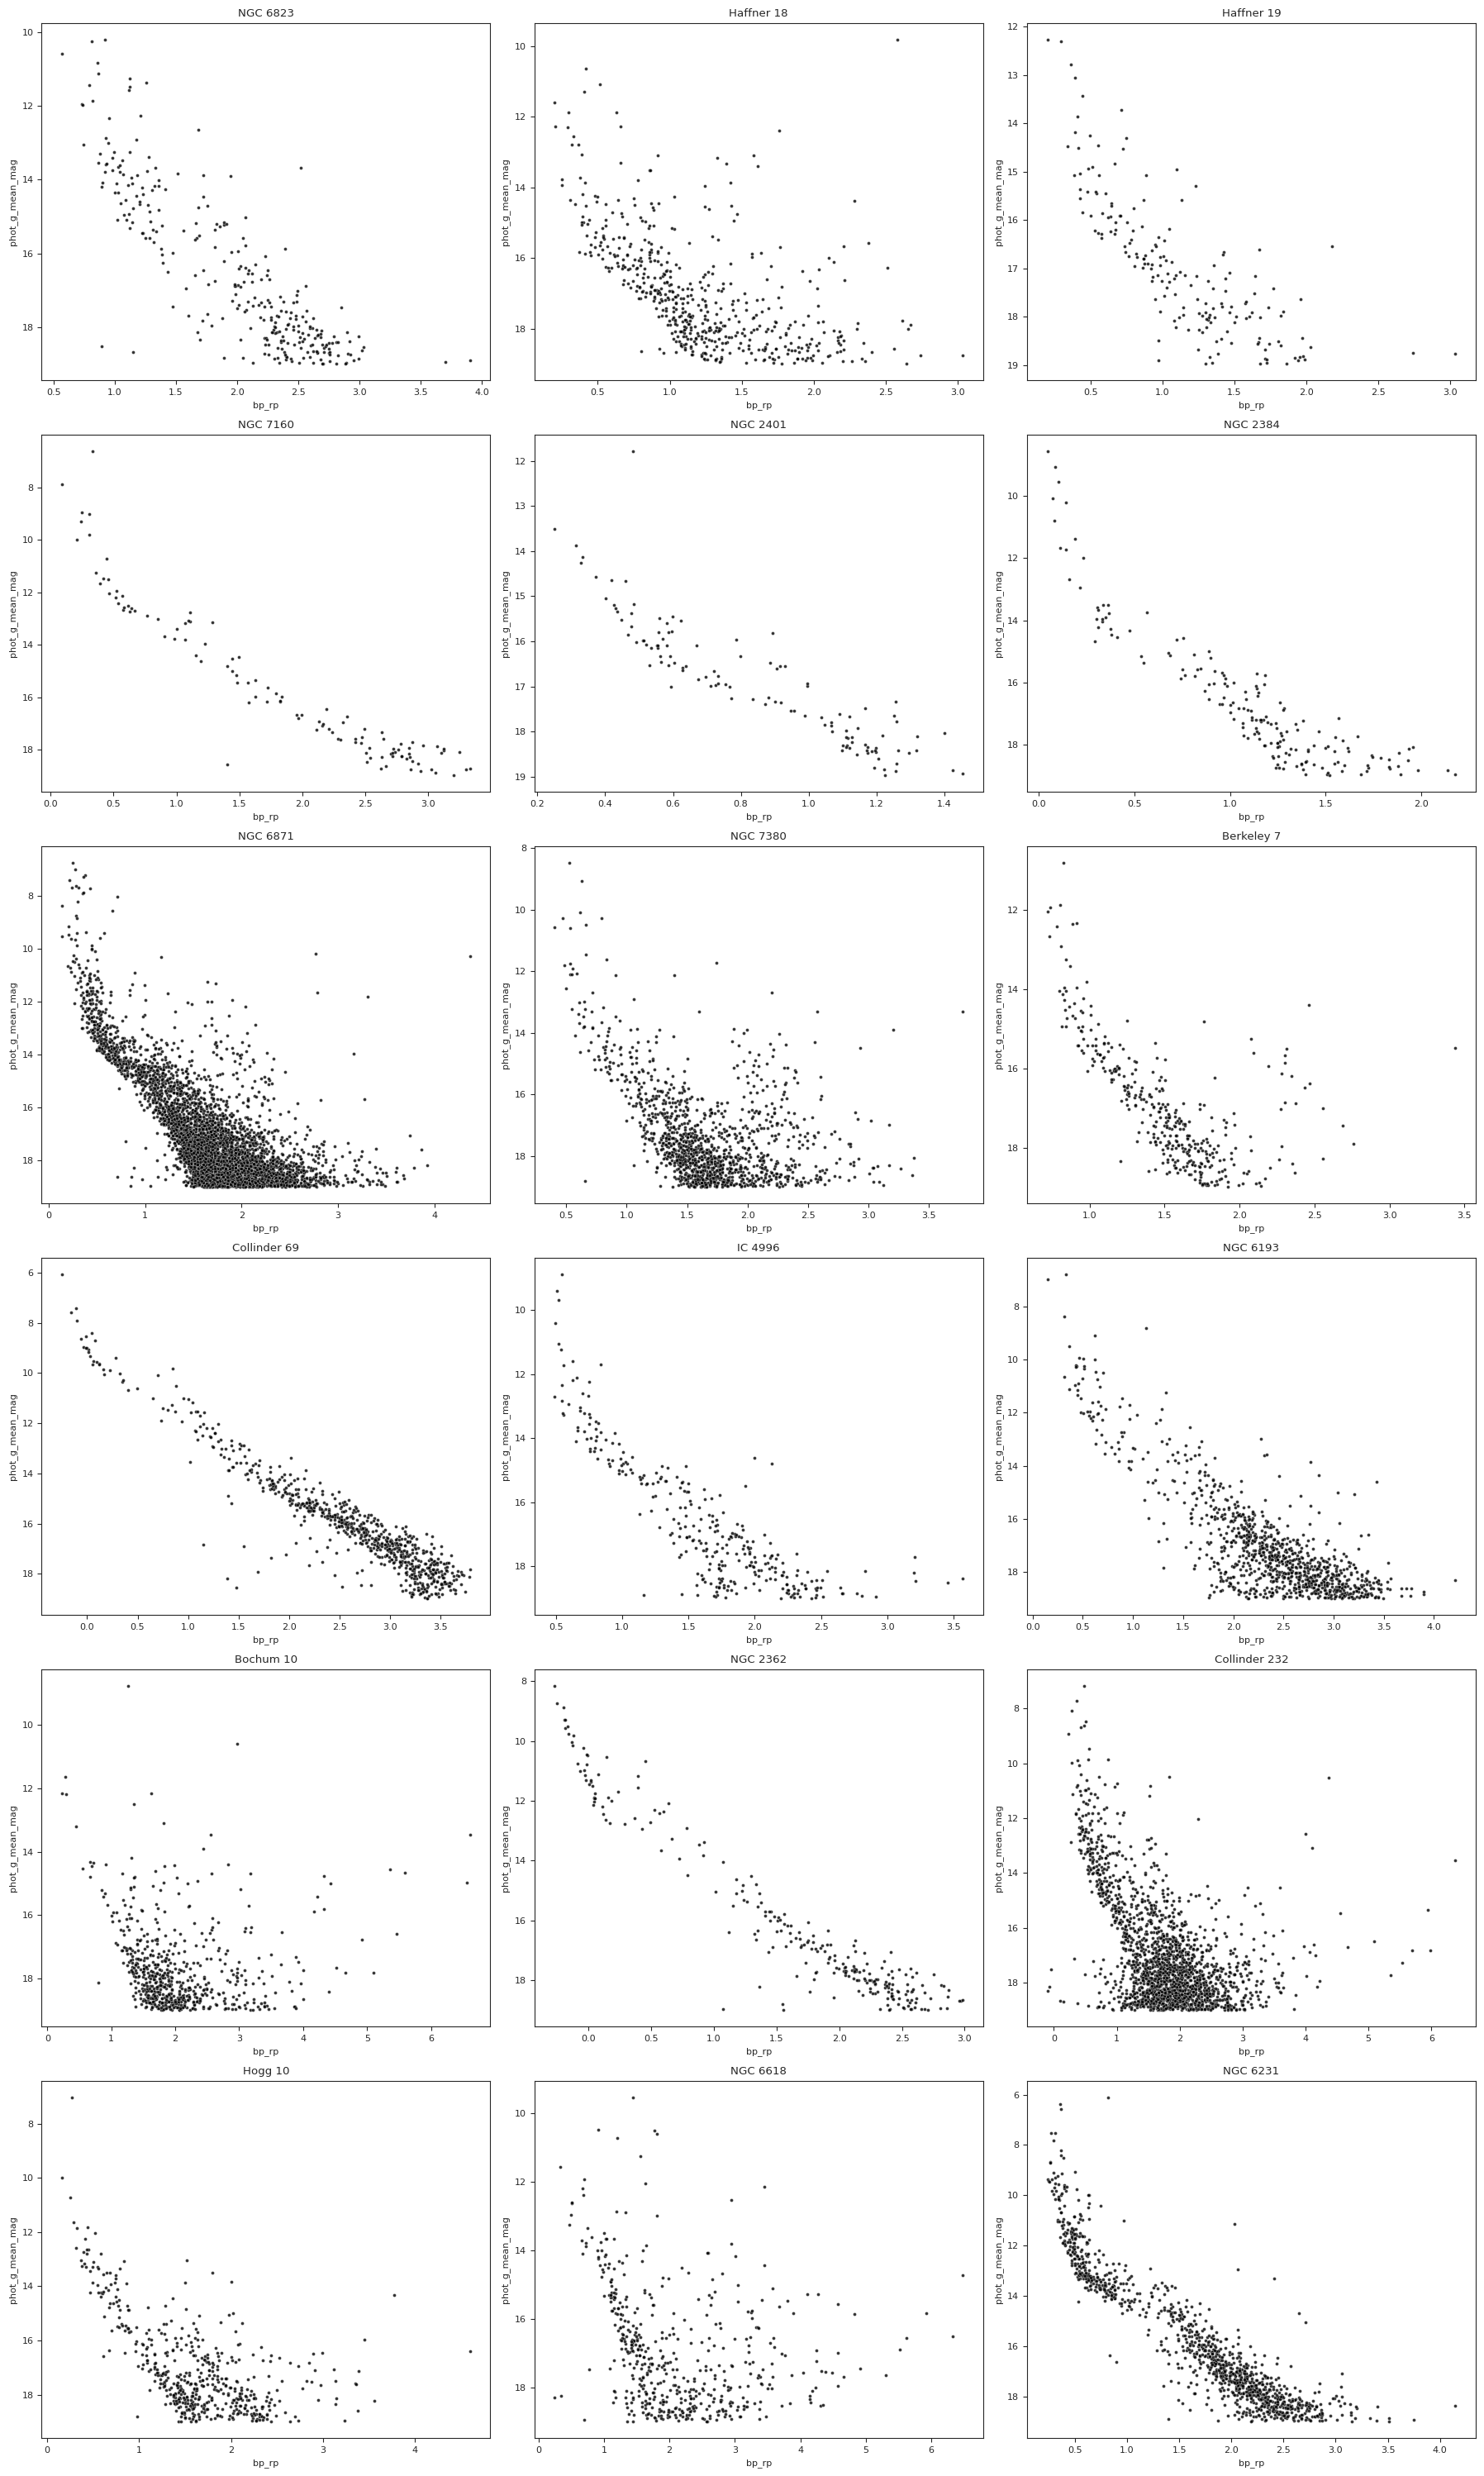

In [459]:
def cmd_plotly(data, x_axis, y_axis, ax=None, alpha=0.8, s=8):
    """
    -------
    plot isochrone
    -------
    """
    if ax is None:
        fig = plt.figure(figsize=(4,8), dpi=100)
        ax = fig.add_subplot(111)
    sns.scatterplot(data=data, y=y_axis, x=x_axis, alpha=alpha, s=s, ax=ax)
    ax.invert_yaxis()


with plt.style.context(['ieee']):
    fig, axes = plt.subplots(6, 3, figsize=(18, 30), dpi=100)

    cmd_plotly(df_NGC_6823_new, 'bp_rp', 'phot_g_mean_mag', ax=axes[0, 0])
    axes[0, 0].set_title('NGC 6823')

    cmd_plotly(df_Haffner_18_new, 'bp_rp', 'phot_g_mean_mag', ax=axes[0, 1])
    axes[0, 1].set_title('Haffner 18')

    cmd_plotly(df_Haffner_19_new, 'bp_rp', 'phot_g_mean_mag', ax=axes[0, 2])
    axes[0, 2].set_title('Haffner 19')

    cmd_plotly(df_NGC_7160_new, 'bp_rp', 'phot_g_mean_mag', ax=axes[1, 0])
    axes[1, 0].set_title('NGC 7160')

    cmd_plotly(df_NGC_2401_new, 'bp_rp', 'phot_g_mean_mag', ax=axes[1, 1])
    axes[1, 1].set_title('NGC 2401')

    cmd_plotly(df_NGC_2384_new, 'bp_rp', 'phot_g_mean_mag', ax=axes[1, 2])
    axes[1, 2].set_title('NGC 2384')

    cmd_plotly(df_NGC_6871_new, 'bp_rp', 'phot_g_mean_mag', ax=axes[2, 0])
    axes[2, 0].set_title('NGC 6871')

    cmd_plotly(df_NGC_7380_new, 'bp_rp', 'phot_g_mean_mag', ax=axes[2, 1])
    axes[2, 1].set_title('NGC 7380')

    cmd_plotly(df_Berkeley_7_new, 'bp_rp', 'phot_g_mean_mag', ax=axes[2, 2])
    axes[2, 2].set_title('Berkeley 7')

    cmd_plotly(df_Collinder_69_new, 'bp_rp', 'phot_g_mean_mag', ax=axes[3, 0])
    axes[3, 0].set_title('Collinder 69')

    cmd_plotly(df_IC_4996_new, 'bp_rp', 'phot_g_mean_mag', ax=axes[3, 1])
    axes[3, 1].set_title('IC 4996')
    
    cmd_plotly(df_NGC_6193_new, 'bp_rp', 'phot_g_mean_mag', ax=axes[3, 2])
    axes[3, 2].set_title('NGC 6193')
    
    cmd_plotly(df_Bochum_10_new, 'bp_rp', 'phot_g_mean_mag', ax=axes[4, 0])
    axes[4, 0].set_title('Bochum 10')

    cmd_plotly(df_NGC_2362_new, 'bp_rp', 'phot_g_mean_mag', ax=axes[4, 1])
    axes[4, 1].set_title('NGC 2362')

    cmd_plotly(df_Collinder_232_new, 'bp_rp', 'phot_g_mean_mag', ax=axes[4, 2])
    axes[4, 2].set_title('Collinder 232')
    
    cmd_plotly(df_Hogg_10_new, 'bp_rp', 'phot_g_mean_mag', ax=axes[5, 0])
    axes[5, 0].set_title('Hogg 10')

    cmd_plotly(df_NGC_6618_new, 'bp_rp', 'phot_g_mean_mag', ax=axes[5, 1])
    axes[5, 1].set_title('NGC 6618')

    cmd_plotly(df_NGC_6231_new, 'bp_rp', 'phot_g_mean_mag', ax=axes[5, 2])
    axes[5, 2].set_title('NGC 6231')


    plt.tight_layout()
    plt.show()

# Minimum Spanning Tree

In [460]:
def min_span_tree(data):
    
    np.random.seed(101)
    
    data = data.reset_index().drop('index', axis=1)
    nn = NearestNeighbors(n_neighbors=3, metric='minkowski')
    nn.fit(data[['r_med_photogeo', 'ra', 'dec']])
    distances, indices = nn.kneighbors(data[['r_med_photogeo', 'ra', 'dec']])

    # Create an empty graph
    G = nx.Graph()

    # Add edges with distances to the graph
    n_samples = data.shape[0]
    for i in range(n_samples):
        for j in range(1, len(indices[i])):
            neighbor_index = indices[i, j]
            weight = distances[i, j]
            G.add_edge(i, neighbor_index, weight=weight)

    # Compute the minimum spanning tree
    mst = nx.minimum_spanning_tree(G)

    # Calculate the mean weight of the MST
    edge_weights = [X['weight'] for _, _, X in mst.edges(data=True)]
    threshold = np.mean(edge_weights) + 1 * np.std(edge_weights)

    # Identify the nodes with weights greater than the mean weight
    nodes_to_remove = [node for node in mst.nodes() if mst.degree(node, weight='weight') > threshold]

    # Remove the identified nodes from the MST
    mst.remove_nodes_from(nodes_to_remove)

    data['MST_cluster'] = 1
    data.loc[nodes_to_remove, 'MST_cluster'] = 0
    
    return data

In [461]:
df_NGC_6823_new = min_span_tree(df_NGC_6823_new)
df_Haffner_18_new = min_span_tree(df_Haffner_18_new)
df_Haffner_19_new = min_span_tree(df_Haffner_19_new)
df_NGC_7160_new = min_span_tree(df_NGC_7160_new)
df_NGC_6193_new = min_span_tree(df_NGC_6193_new)
df_NGC_2401_new = min_span_tree(df_NGC_2401_new)
df_NGC_2384_new = min_span_tree(df_NGC_2384_new)
df_NGC_6871_new = min_span_tree(df_NGC_6871_new)
df_NGC_7380_new = min_span_tree(df_NGC_7380_new)
df_Berkeley_7_new = min_span_tree(df_Berkeley_7_new)
df_Collinder_69_new = min_span_tree(df_Collinder_69_new)
df_IC_4996_new = min_span_tree(df_IC_4996_new)
df_Bochum_10_new = min_span_tree(df_Bochum_10_new)
df_NGC_2362_new = min_span_tree(df_NGC_2362_new)
df_Collinder_232_new = min_span_tree(df_Collinder_232_new)
df_Hogg_10_new = min_span_tree(df_Hogg_10_new)
df_NGC_6618_new = min_span_tree(df_NGC_6618_new)
df_NGC_6231_new = min_span_tree(df_NGC_6231_new)

In [462]:
def cmd_plotly(data, x_axis, y_axis, huex = 'cluster', ax=None, alpha=0.8, s=15):
    """
    -------
    plot isochrone
    -------
    """
    if ax is None:
        fig = plt.figure(figsize=(4,8), dpi=100)
        ax = fig.add_subplot(111)
    sns.scatterplot(data=data, y=y_axis, x=x_axis, alpha=alpha, s=s, hue = huex, ax=ax)
    ax.invert_yaxis()

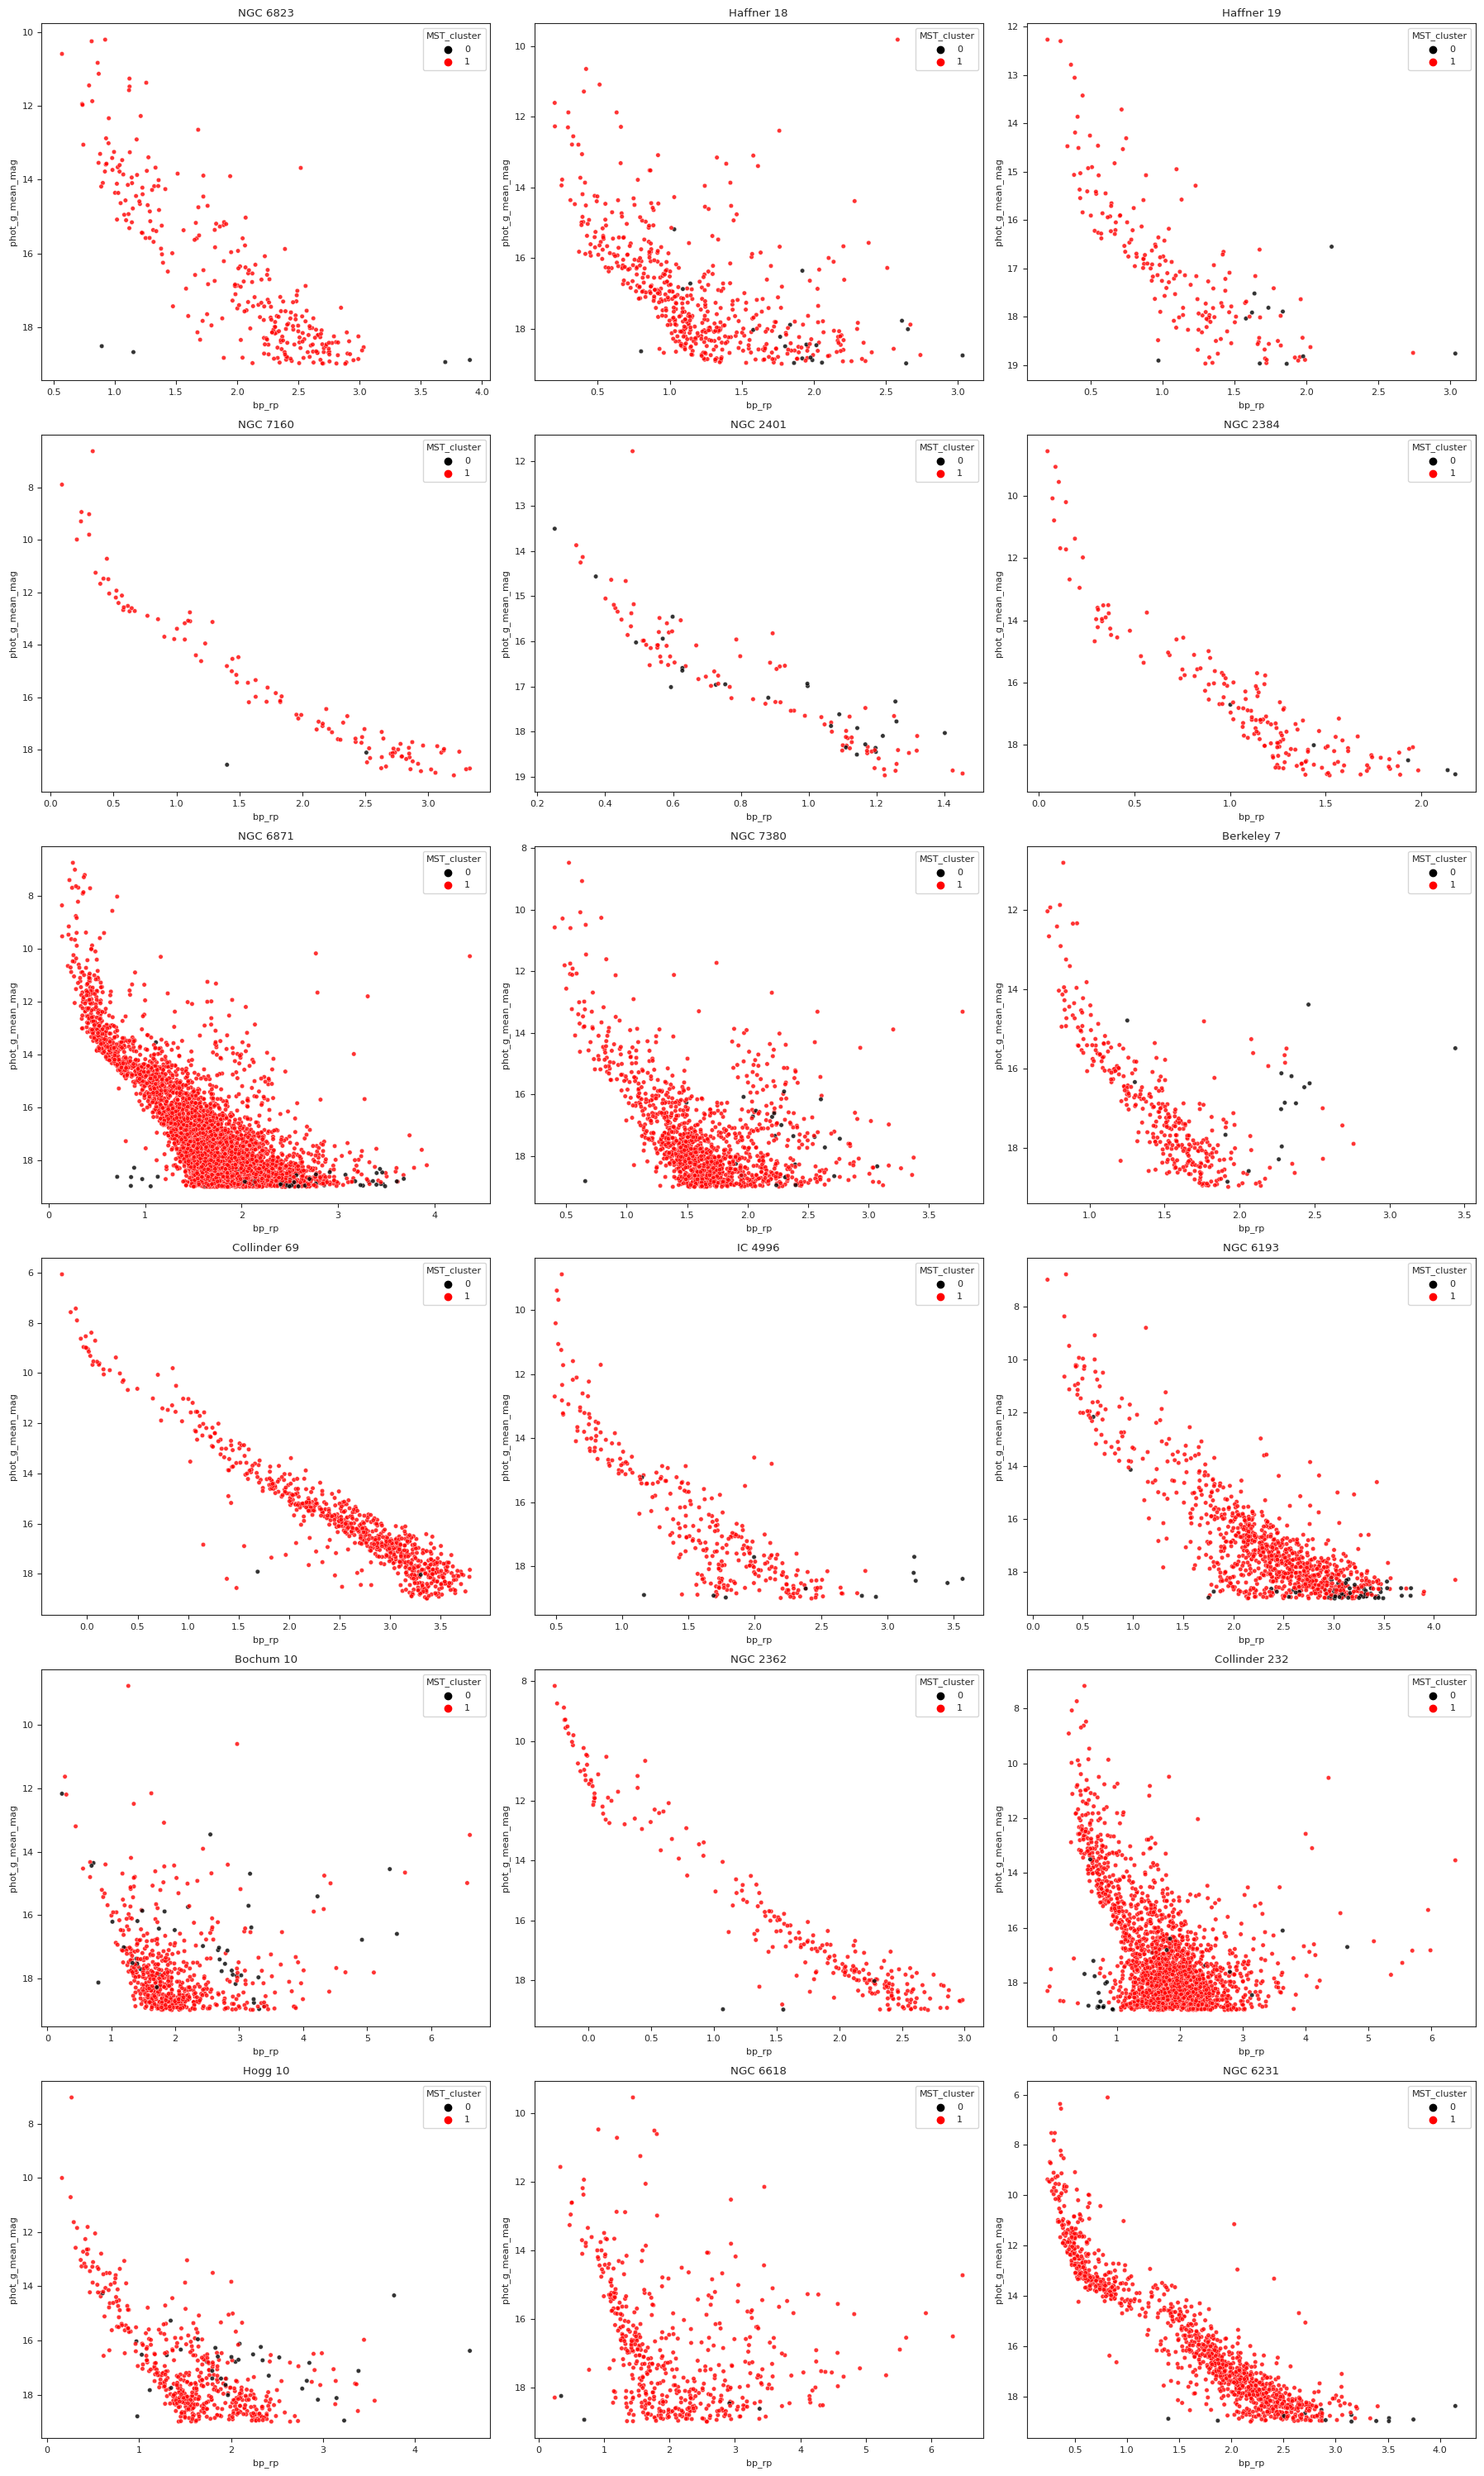

In [463]:
with plt.style.context(['ieee']):
    fig, axes = plt.subplots(6, 3, figsize=(18, 30), dpi=100)

    cmd_plotly(df_NGC_6823_new, 'bp_rp', 'phot_g_mean_mag', huex='MST_cluster', ax=axes[0, 0])
    axes[0, 0].set_title('NGC 6823')

    cmd_plotly(df_Haffner_18_new, 'bp_rp', 'phot_g_mean_mag', huex = 'MST_cluster', ax=axes[0, 1])
    axes[0, 1].set_title('Haffner 18')

    cmd_plotly(df_Haffner_19_new, 'bp_rp', 'phot_g_mean_mag', huex = 'MST_cluster', ax=axes[0, 2])
    axes[0, 2].set_title('Haffner 19')

    cmd_plotly(df_NGC_7160_new, 'bp_rp', 'phot_g_mean_mag', huex = 'MST_cluster', ax=axes[1, 0])
    axes[1, 0].set_title('NGC 7160')

    cmd_plotly(df_NGC_2401_new, 'bp_rp', 'phot_g_mean_mag', huex = 'MST_cluster', ax=axes[1, 1])
    axes[1, 1].set_title('NGC 2401')

    cmd_plotly(df_NGC_2384_new, 'bp_rp', 'phot_g_mean_mag', huex = 'MST_cluster', ax=axes[1, 2])
    axes[1, 2].set_title('NGC 2384')

    cmd_plotly(df_NGC_6871_new, 'bp_rp', 'phot_g_mean_mag', huex = 'MST_cluster', ax=axes[2, 0])
    axes[2, 0].set_title('NGC 6871')

    cmd_plotly(df_NGC_7380_new, 'bp_rp', 'phot_g_mean_mag', huex = 'MST_cluster', ax=axes[2, 1])
    axes[2, 1].set_title('NGC 7380')

    cmd_plotly(df_Berkeley_7_new, 'bp_rp', 'phot_g_mean_mag', huex = 'MST_cluster', ax=axes[2, 2])
    axes[2, 2].set_title('Berkeley 7')

    cmd_plotly(df_Collinder_69_new, 'bp_rp', 'phot_g_mean_mag', huex = 'MST_cluster', ax=axes[3, 0])
    axes[3, 0].set_title('Collinder 69')

    cmd_plotly(df_IC_4996_new, 'bp_rp', 'phot_g_mean_mag', huex = 'MST_cluster', ax=axes[3, 1])
    axes[3, 1].set_title('IC 4996')
    
    cmd_plotly(df_NGC_6193_new, 'bp_rp', 'phot_g_mean_mag', huex = 'MST_cluster', ax=axes[3, 2])
    axes[3, 2].set_title('NGC 6193')
    
    cmd_plotly(df_Bochum_10_new, 'bp_rp', 'phot_g_mean_mag', huex = 'MST_cluster', ax=axes[4, 0])
    axes[4, 0].set_title('Bochum 10')

    cmd_plotly(df_NGC_2362_new, 'bp_rp', 'phot_g_mean_mag', huex = 'MST_cluster', ax=axes[4, 1])
    axes[4, 1].set_title('NGC 2362')

    cmd_plotly(df_Collinder_232_new, 'bp_rp', 'phot_g_mean_mag', huex = 'MST_cluster', ax=axes[4, 2])
    axes[4, 2].set_title('Collinder 232')
    
    cmd_plotly(df_Hogg_10_new, 'bp_rp', 'phot_g_mean_mag', huex = 'MST_cluster', ax=axes[5, 0])
    axes[5, 0].set_title('Hogg 10')

    cmd_plotly(df_NGC_6618_new, 'bp_rp', 'phot_g_mean_mag', huex = 'MST_cluster', ax=axes[5, 1])
    axes[5, 1].set_title('NGC 6618')

    cmd_plotly(df_NGC_6231_new, 'bp_rp', 'phot_g_mean_mag', huex = 'MST_cluster', ax=axes[5, 2])
    axes[5, 2].set_title('NGC 6231')


    plt.tight_layout()
    plt.show()

# GAUSSIAN MIXTURE

In [464]:
# params = ['pmra', 'pmdec', 'parallax']

def gassian_mixture(data, parameters = ['pmra', 'pmdec', 'parallax', 'r_med_photogeo', 'ra', 'dec']):
    np.random.seed(101)
    gm = GaussianMixture(n_components=2, random_state=101)
    
    y_pred = gm.fit_predict(data[parameters])
    y_prob = gm.predict_proba(data[parameters])
    
    data['cluster'] = y_pred
    data['prob'] = np.amax(y_prob,axis=1)
    return data

In [465]:
df_NGC_6823_new = gassian_mixture(df_NGC_6823_new[df_NGC_6823_new['MST_cluster']==1])
df_Haffner_18_new = gassian_mixture(df_Haffner_18_new[df_Haffner_18_new['MST_cluster']==1])
df_Haffner_19_new = gassian_mixture(df_Haffner_19_new[df_Haffner_19_new['MST_cluster']==1])
df_NGC_7160_new = gassian_mixture(df_NGC_7160_new[df_NGC_7160_new['MST_cluster']==1])
df_NGC_6193_new = gassian_mixture(df_NGC_6193_new[df_NGC_6193_new['MST_cluster']==1])
df_NGC_2401_new = gassian_mixture(df_NGC_2401_new[df_NGC_2401_new['MST_cluster']==1])
df_NGC_2384_new = gassian_mixture(df_NGC_2384_new[df_NGC_2384_new['MST_cluster']==1])
df_NGC_6871_new = gassian_mixture(df_NGC_6871_new[df_NGC_6871_new['MST_cluster']==1])
df_NGC_7380_new = gassian_mixture(df_NGC_7380_new[df_NGC_7380_new['MST_cluster']==1])
df_Berkeley_7_new = gassian_mixture(df_Berkeley_7_new[df_Berkeley_7_new['MST_cluster']==1])
df_Collinder_69_new = gassian_mixture(df_Collinder_69_new[df_Collinder_69_new['MST_cluster']==1])
df_IC_4996_new = gassian_mixture(df_IC_4996_new[df_IC_4996_new['MST_cluster']==1])
df_Bochum_10_new = gassian_mixture(df_Bochum_10_new[df_Bochum_10_new['MST_cluster']==1])
df_NGC_2362_new = gassian_mixture(df_NGC_2362_new[df_NGC_2362_new['MST_cluster']==1])
df_Collinder_232_new = gassian_mixture(df_Collinder_232_new[df_Collinder_232_new['MST_cluster']==1])
df_Hogg_10_new = gassian_mixture(df_Hogg_10_new[df_Hogg_10_new['MST_cluster']==1])
df_NGC_6618_new = gassian_mixture(df_NGC_6618_new[df_NGC_6618_new['MST_cluster']==1])
df_NGC_6231_new = gassian_mixture(df_NGC_6231_new[df_NGC_6231_new['MST_cluster']==1])

In [466]:
def cmd_plotly(data, x_axis, y_axis, huex = 'cluster', ax=None, alpha=0.8, s=15):
    """
    -------
    plot isochrone
    -------
    """
    if ax is None:
        fig = plt.figure(figsize=(4,8), dpi=100)
        ax = fig.add_subplot(111)
    sns.scatterplot(data=data, y=y_axis, x=x_axis, alpha=alpha, s=s, hue = huex, ax=ax)
    ax.invert_yaxis()

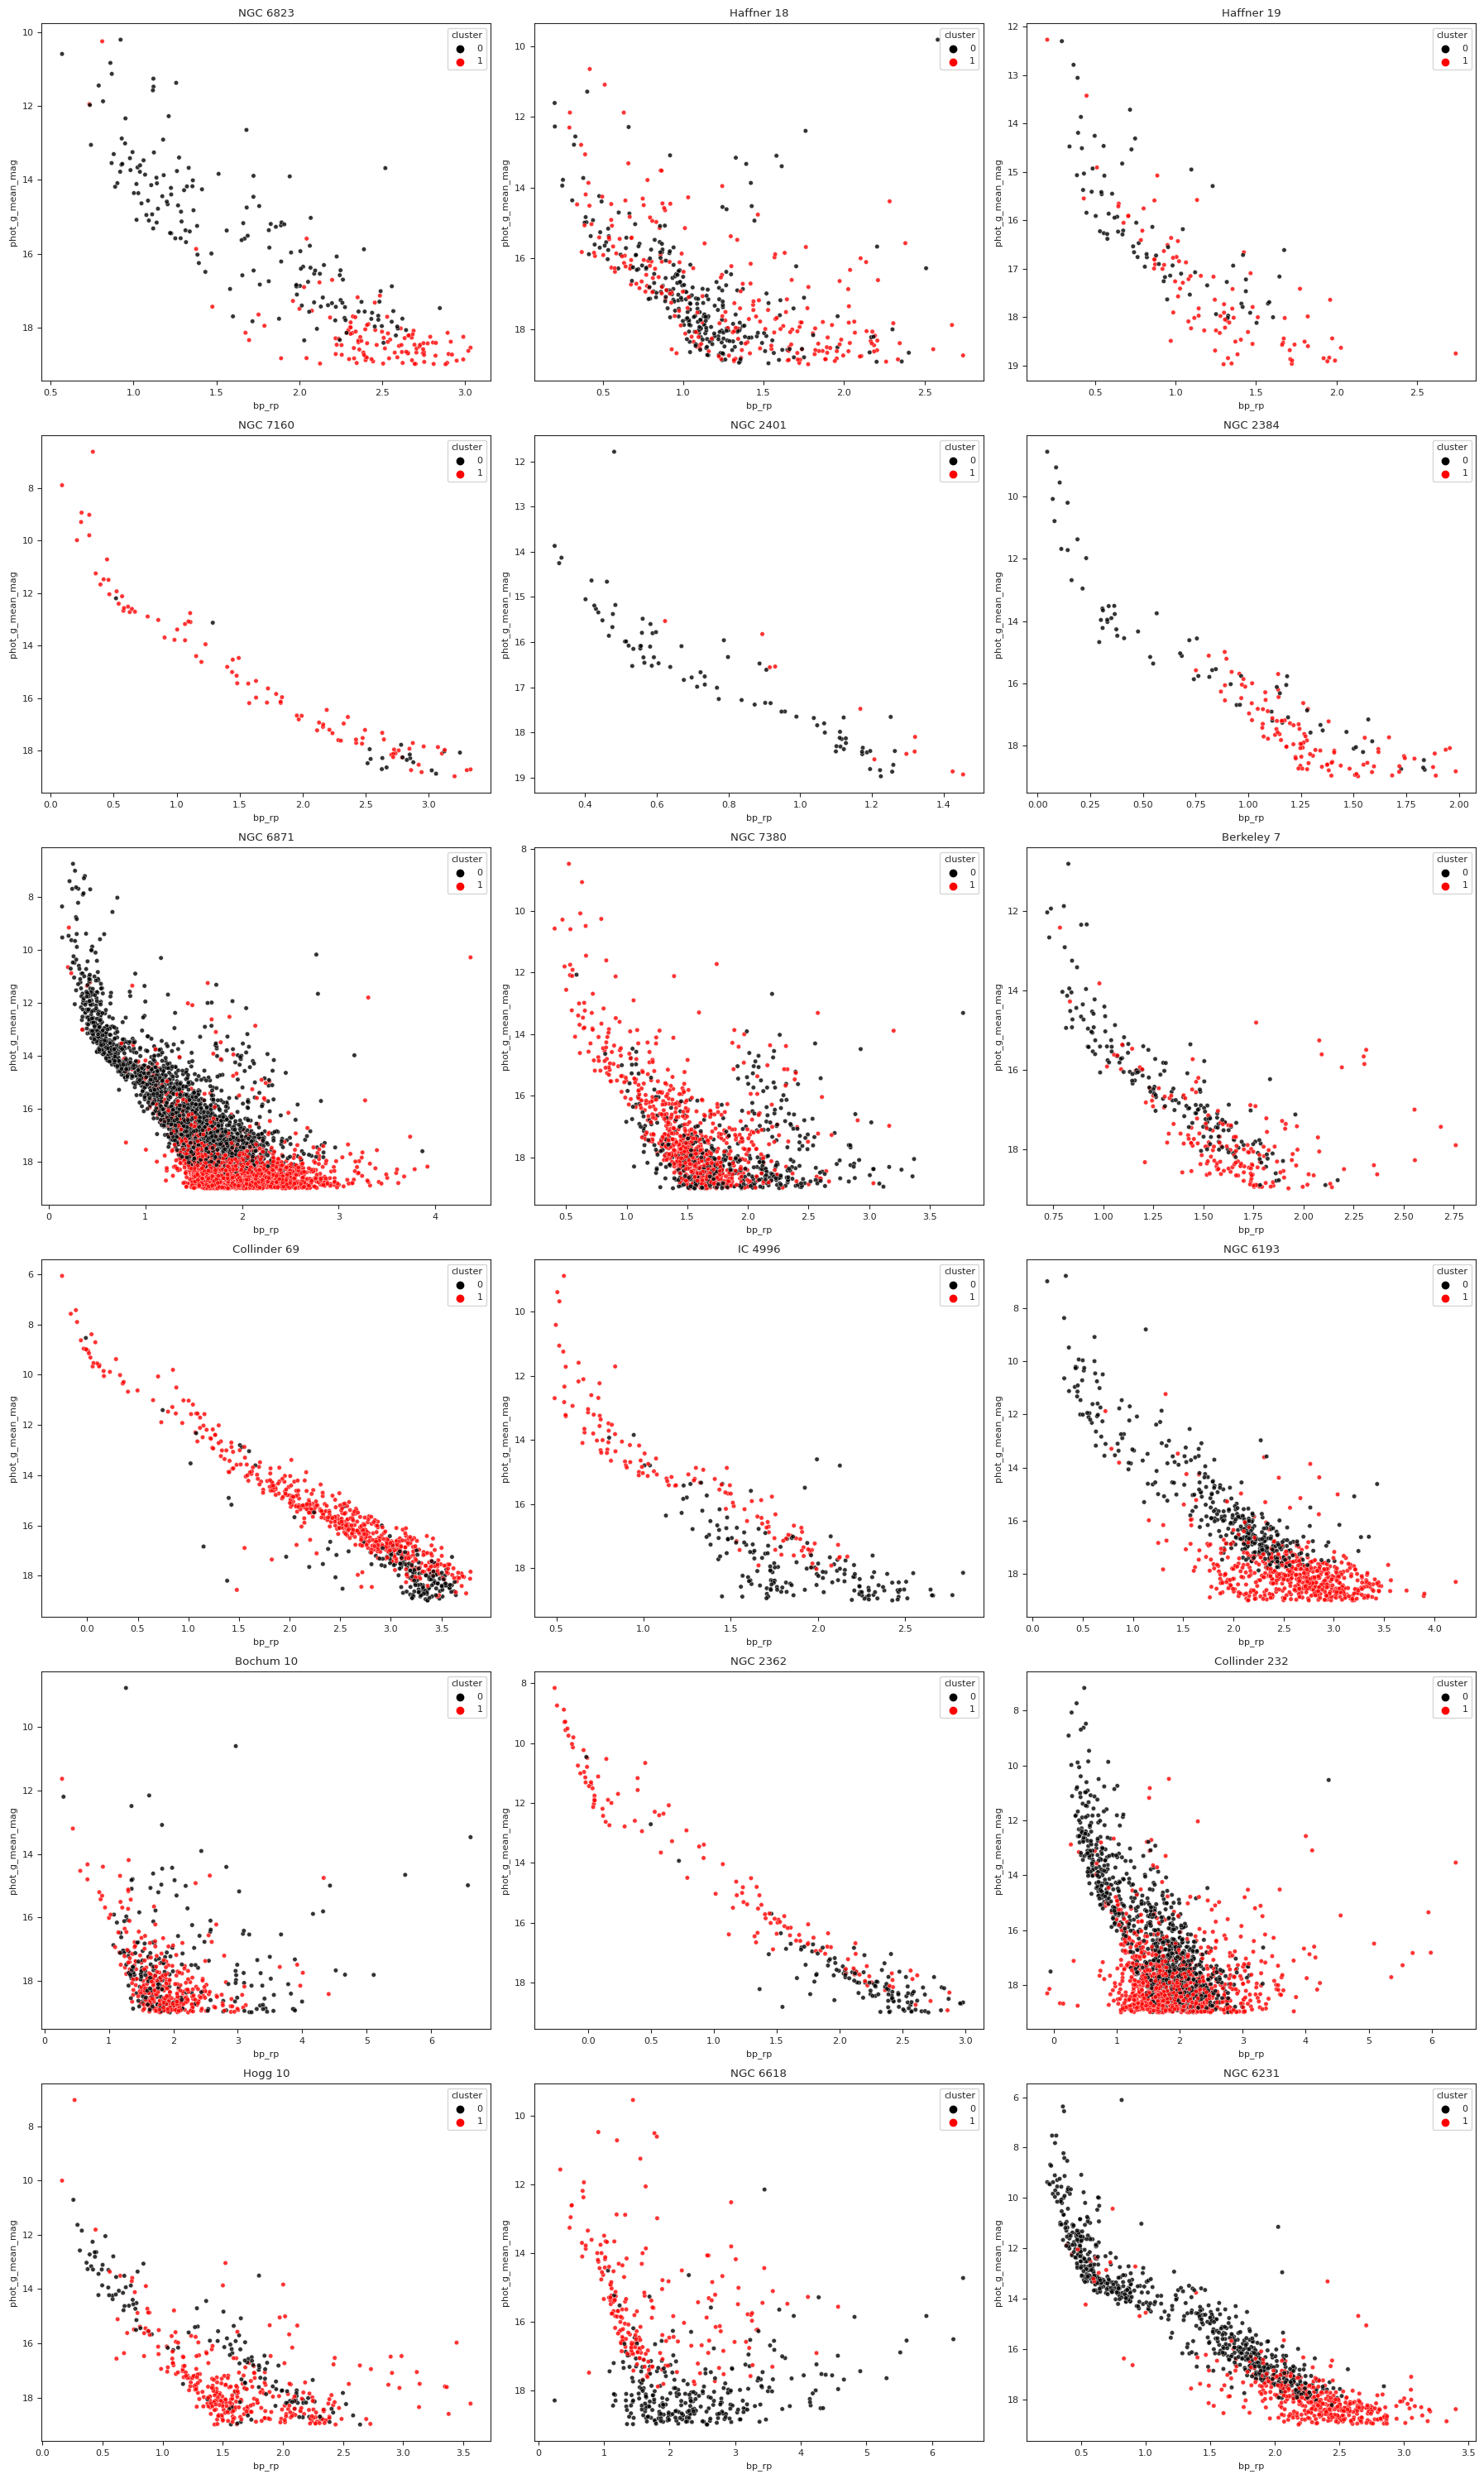

In [467]:
with plt.style.context(['ieee']):
    fig, axes = plt.subplots(6, 3, figsize=(18, 30), dpi=100)

    cmd_plotly(df_NGC_6823_new, 'bp_rp', 'phot_g_mean_mag', huex='cluster', ax=axes[0, 0])
    axes[0, 0].set_title('NGC 6823')

    cmd_plotly(df_Haffner_18_new, 'bp_rp', 'phot_g_mean_mag', huex = 'cluster', ax=axes[0, 1])
    axes[0, 1].set_title('Haffner 18')

    cmd_plotly(df_Haffner_19_new, 'bp_rp', 'phot_g_mean_mag', huex = 'cluster', ax=axes[0, 2])
    axes[0, 2].set_title('Haffner 19')

    cmd_plotly(df_NGC_7160_new, 'bp_rp', 'phot_g_mean_mag', huex = 'cluster', ax=axes[1, 0])
    axes[1, 0].set_title('NGC 7160')

    cmd_plotly(df_NGC_2401_new, 'bp_rp', 'phot_g_mean_mag', huex = 'cluster', ax=axes[1, 1])
    axes[1, 1].set_title('NGC 2401')

    cmd_plotly(df_NGC_2384_new, 'bp_rp', 'phot_g_mean_mag', huex = 'cluster', ax=axes[1, 2])
    axes[1, 2].set_title('NGC 2384')

    cmd_plotly(df_NGC_6871_new, 'bp_rp', 'phot_g_mean_mag', huex = 'cluster', ax=axes[2, 0])
    axes[2, 0].set_title('NGC 6871')

    cmd_plotly(df_NGC_7380_new, 'bp_rp', 'phot_g_mean_mag', huex = 'cluster', ax=axes[2, 1])
    axes[2, 1].set_title('NGC 7380')

    cmd_plotly(df_Berkeley_7_new, 'bp_rp', 'phot_g_mean_mag', huex = 'cluster', ax=axes[2, 2])
    axes[2, 2].set_title('Berkeley 7')

    cmd_plotly(df_Collinder_69_new, 'bp_rp', 'phot_g_mean_mag', huex = 'cluster', ax=axes[3, 0])
    axes[3, 0].set_title('Collinder 69')

    cmd_plotly(df_IC_4996_new, 'bp_rp', 'phot_g_mean_mag', huex = 'cluster', ax=axes[3, 1])
    axes[3, 1].set_title('IC 4996')
    
    cmd_plotly(df_NGC_6193_new, 'bp_rp', 'phot_g_mean_mag', huex = 'cluster', ax=axes[3, 2])
    axes[3, 2].set_title('NGC 6193')
    
    cmd_plotly(df_Bochum_10_new, 'bp_rp', 'phot_g_mean_mag', huex = 'cluster', ax=axes[4, 0])
    axes[4, 0].set_title('Bochum 10')

    cmd_plotly(df_NGC_2362_new, 'bp_rp', 'phot_g_mean_mag', huex = 'cluster', ax=axes[4, 1])
    axes[4, 1].set_title('NGC 2362')

    cmd_plotly(df_Collinder_232_new, 'bp_rp', 'phot_g_mean_mag', huex = 'cluster', ax=axes[4, 2])
    axes[4, 2].set_title('Collinder 232')
    
    cmd_plotly(df_Hogg_10_new, 'bp_rp', 'phot_g_mean_mag', huex = 'cluster', ax=axes[5, 0])
    axes[5, 0].set_title('Hogg 10')

    cmd_plotly(df_NGC_6618_new, 'bp_rp', 'phot_g_mean_mag', huex = 'cluster', ax=axes[5, 1])
    axes[5, 1].set_title('NGC 6618')

    cmd_plotly(df_NGC_6231_new, 'bp_rp', 'phot_g_mean_mag', huex = 'cluster', ax=axes[5, 2])
    axes[5, 2].set_title('NGC 6231')


    plt.tight_layout()
    plt.show()

***NGC_2384 Results are not compatible with Simbda values!!!***  
***NGC 6618 seems to be cluster 1 but there are few samples!!!***  
***NGC 6231 maybe two clusters on each other!!*** or Maybe just because its in spiral!!


In [468]:
def plot_cluster_histograms(df):
    print('1:',len(df[df['cluster'] == 1]))
    print('0:',len(df[df['cluster'] == 0]))
    
    # Create a figure and subplots with a 3x2 grid
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 8))

    # Plotting the first histogram
    sns.histplot(data=df[df['cluster'] == 1], x='pmra', ax=axes[0, 0])
    axes[0, 0].set_title('Cluster 1')

    # Plotting the second histogram
    sns.histplot(data=df[df['cluster'] == 0], x='pmra', ax=axes[0, 1])
    axes[0, 1].set_title('Cluster 0')

    sns.histplot(data=df[df['cluster'] == 1], x='pmdec', ax=axes[1, 0])
    sns.histplot(data=df[df['cluster'] == 0], x='pmdec', ax=axes[1, 1])

    sns.histplot(data=df[df['cluster'] == 1], x='parallax', ax=axes[2, 0])
    sns.histplot(data=df[df['cluster'] == 0], x='parallax', ax=axes[2, 1])

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Display the plot
    plt.show()
    
    with plt.style.context(['ieee']):
        fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=100)

        cmd_plotly(df[df['cluster'] == 0], 'bp_rp', 'phot_g_mean_mag', huex='cluster', ax=axes[0])
        cmd_plotly(df[df['cluster'] == 1], 'bp_rp', 'phot_g_mean_mag', huex='cluster', ax=axes[1])  

1: 468
0: 697


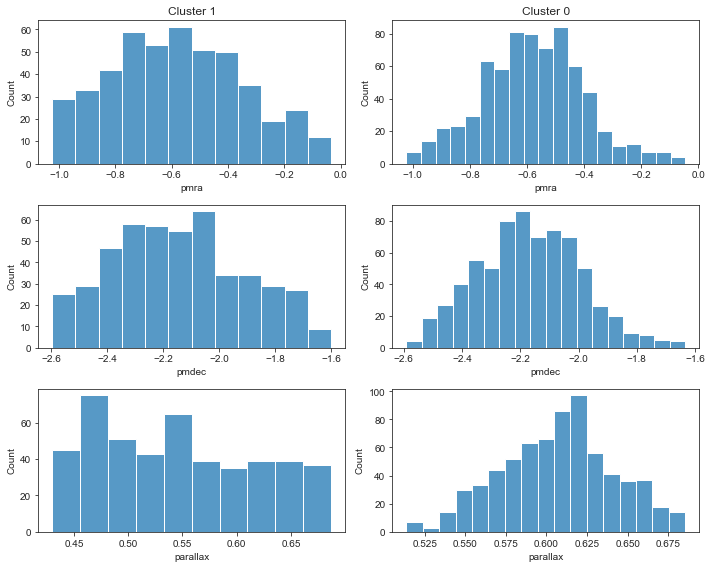

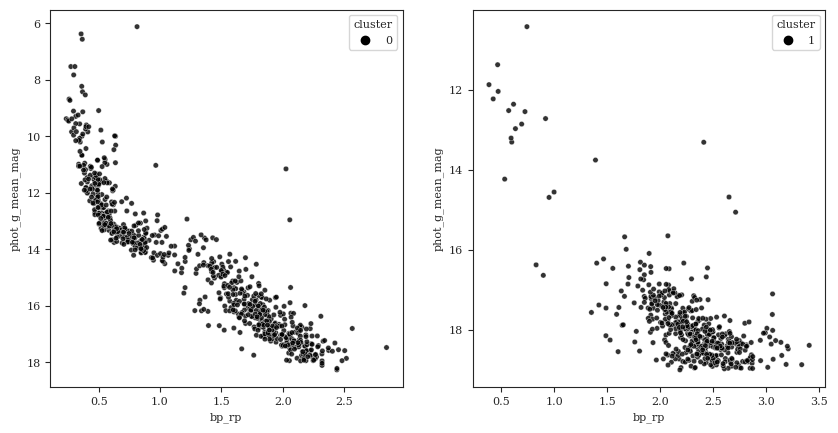

In [469]:
plot_cluster_histograms(df_NGC_6231_new)

### final cluster members

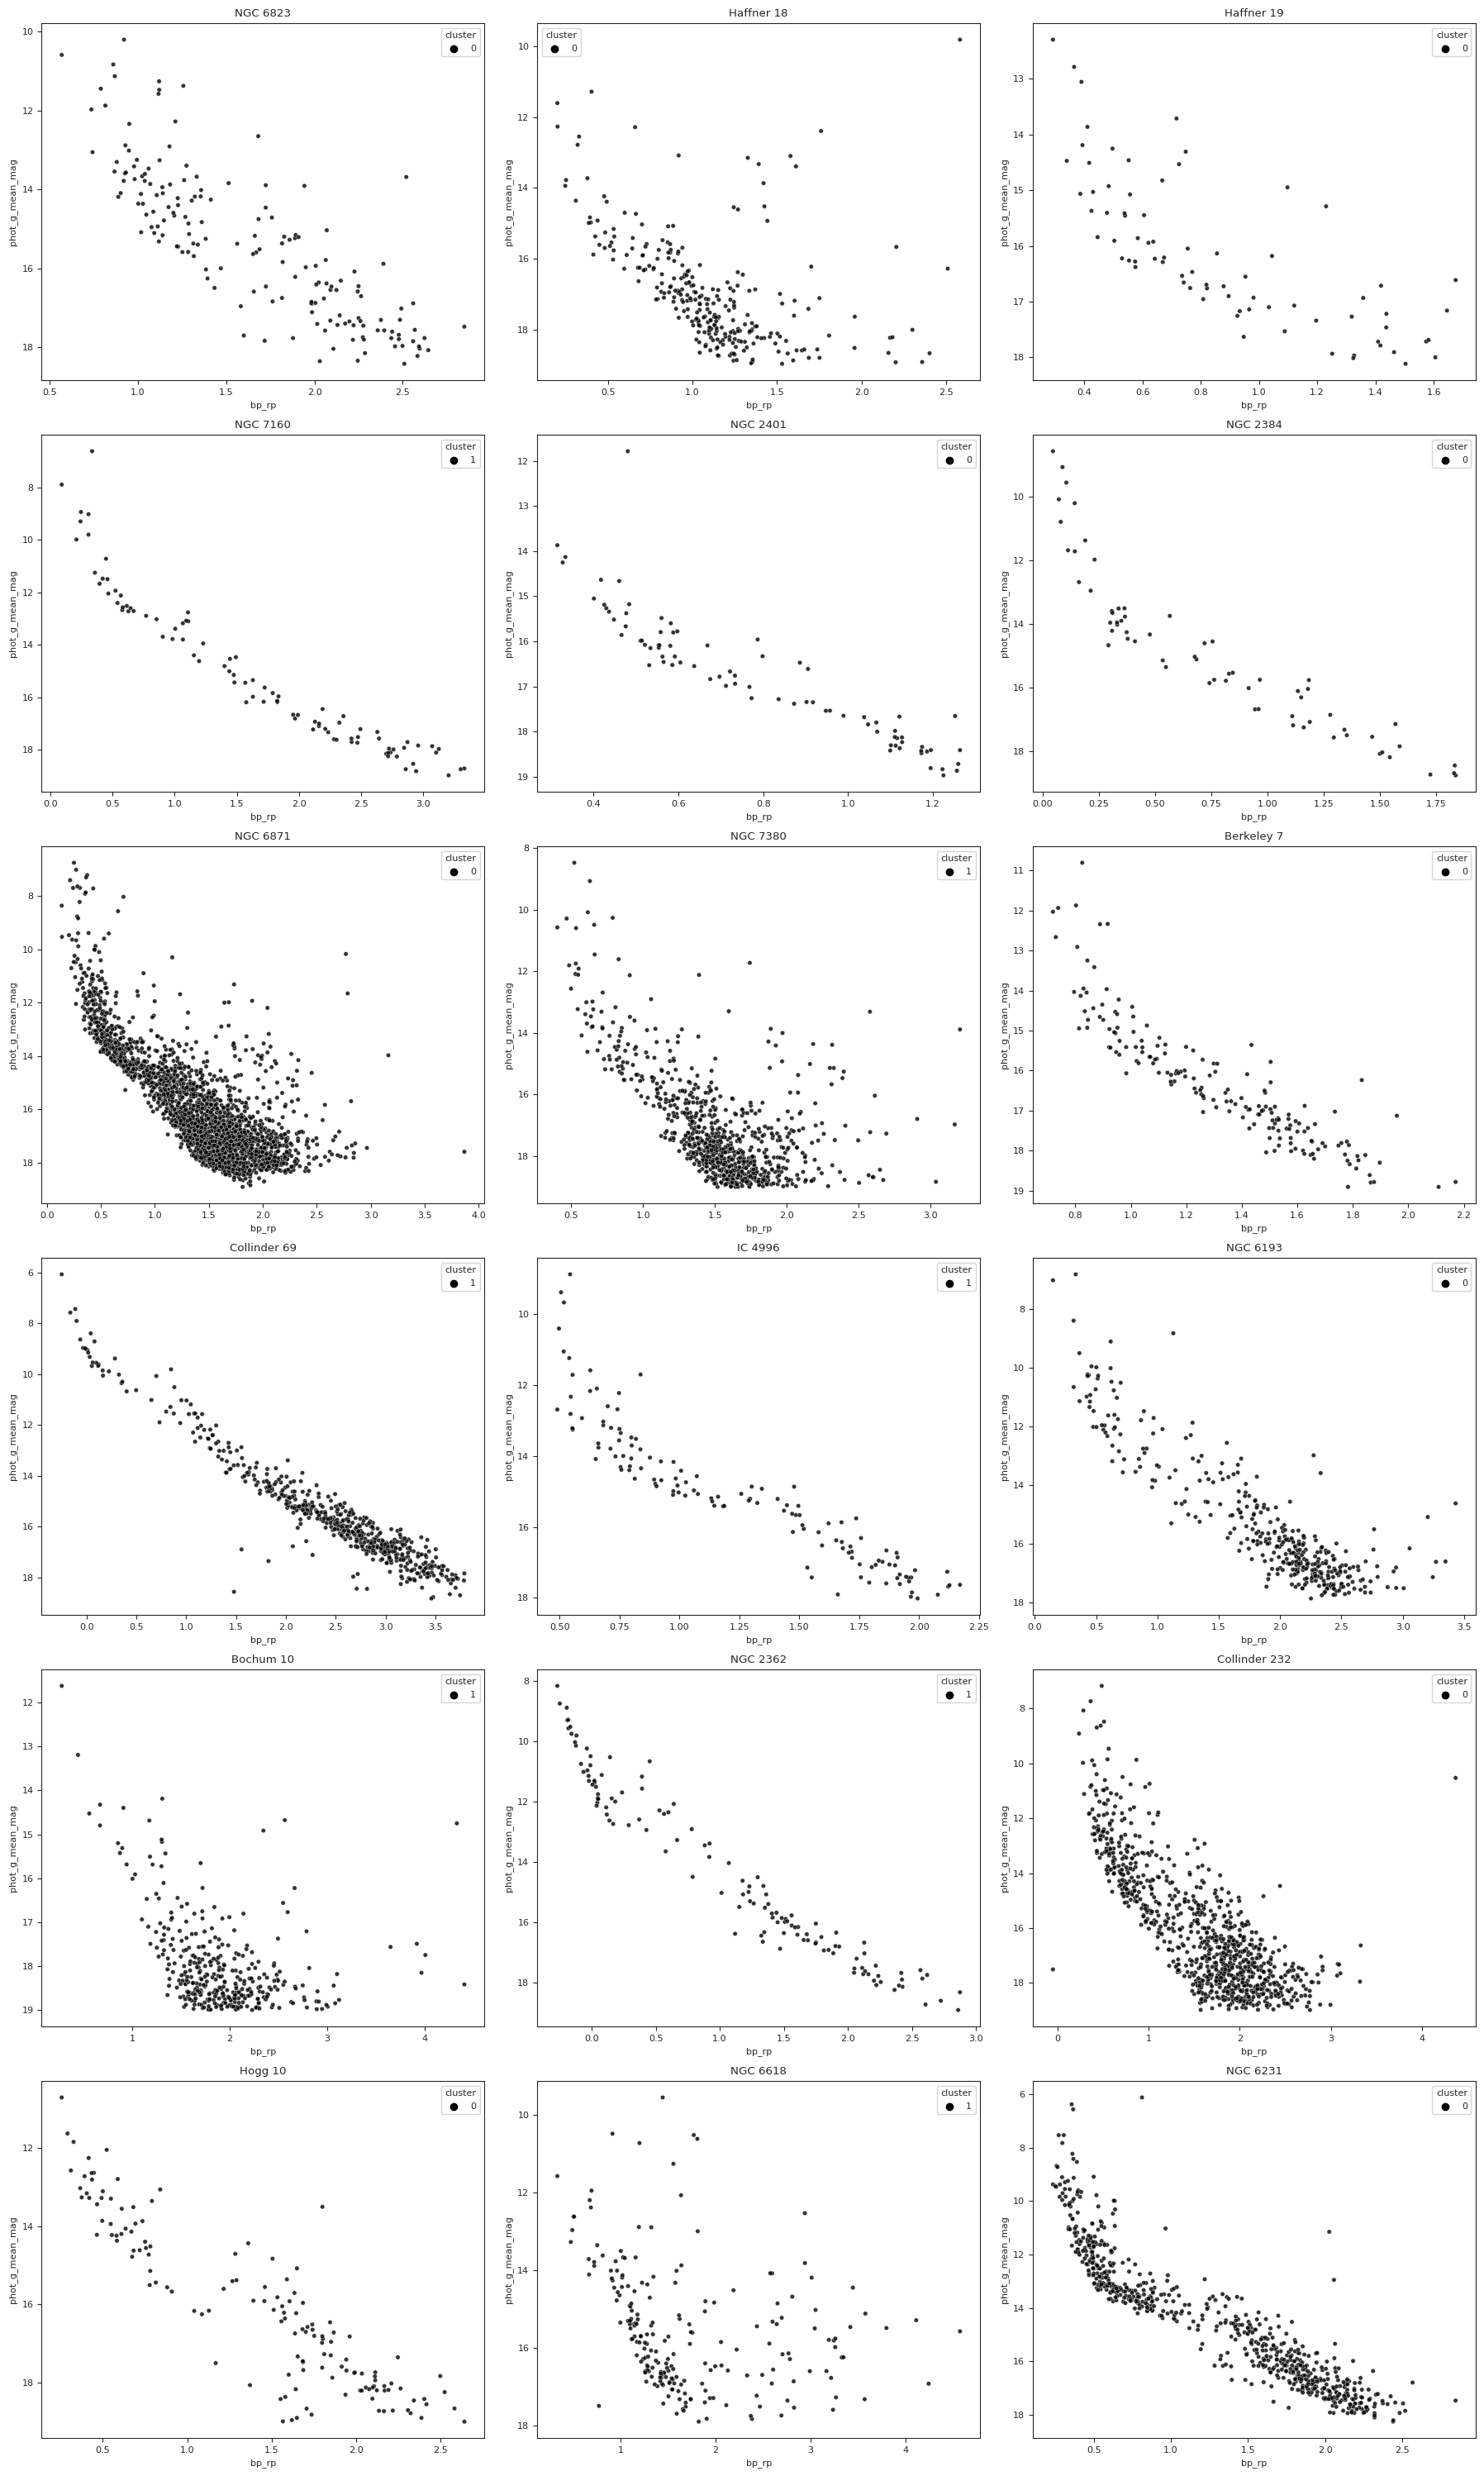

In [470]:
with plt.style.context(['ieee']):
    fig, axes = plt.subplots(6, 3, figsize=(18, 30), dpi=100)

    cmd_plotly(df_NGC_6823_new[df_NGC_6823_new['cluster'] == 0], 'bp_rp', 'phot_g_mean_mag', huex='cluster', ax=axes[0, 0])
    axes[0, 0].set_title('NGC 6823')

    cmd_plotly(df_Haffner_18_new[df_Haffner_18_new['cluster'] == 0], 'bp_rp', 'phot_g_mean_mag', huex = 'cluster', ax=axes[0, 1])
    axes[0, 1].set_title('Haffner 18')

    cmd_plotly(df_Haffner_19_new[df_Haffner_19_new['cluster'] == 0], 'bp_rp', 'phot_g_mean_mag', huex = 'cluster', ax=axes[0, 2])
    axes[0, 2].set_title('Haffner 19')

    cmd_plotly(df_NGC_7160_new[df_NGC_7160_new['cluster'] == 1], 'bp_rp', 'phot_g_mean_mag', huex = 'cluster', ax=axes[1, 0])
    axes[1, 0].set_title('NGC 7160')

    cmd_plotly(df_NGC_2401_new[df_NGC_2401_new['cluster'] == 0], 'bp_rp', 'phot_g_mean_mag', huex = 'cluster', ax=axes[1, 1])
    axes[1, 1].set_title('NGC 2401')

    cmd_plotly(df_NGC_2384_new[df_NGC_2384_new['cluster'] == 0], 'bp_rp', 'phot_g_mean_mag', huex = 'cluster', ax=axes[1, 2])
    axes[1, 2].set_title('NGC 2384')

    cmd_plotly(df_NGC_6871_new[df_NGC_6871_new['cluster'] == 0], 'bp_rp', 'phot_g_mean_mag', huex = 'cluster', ax=axes[2, 0])
    axes[2, 0].set_title('NGC 6871')

    cmd_plotly(df_NGC_7380_new[df_NGC_7380_new['cluster'] == 1], 'bp_rp', 'phot_g_mean_mag', huex = 'cluster', ax=axes[2, 1])
    axes[2, 1].set_title('NGC 7380')

    cmd_plotly(df_Berkeley_7_new[df_Berkeley_7_new['cluster'] == 0], 'bp_rp', 'phot_g_mean_mag', huex = 'cluster', ax=axes[2, 2])
    axes[2, 2].set_title('Berkeley 7')

    cmd_plotly(df_Collinder_69_new[df_Collinder_69_new['cluster'] == 1], 'bp_rp', 'phot_g_mean_mag', huex = 'cluster', ax=axes[3, 0])
    axes[3, 0].set_title('Collinder 69')

    cmd_plotly(df_IC_4996_new[df_IC_4996_new['cluster'] == 1], 'bp_rp', 'phot_g_mean_mag', huex = 'cluster', ax=axes[3, 1])
    axes[3, 1].set_title('IC 4996')
    
    cmd_plotly(df_NGC_6193_new[df_NGC_6193_new['cluster'] == 0], 'bp_rp', 'phot_g_mean_mag', huex = 'cluster', ax=axes[3, 2])
    axes[3, 2].set_title('NGC 6193')
    
    cmd_plotly(df_Bochum_10_new[df_Bochum_10_new['cluster'] == 1], 'bp_rp', 'phot_g_mean_mag', huex = 'cluster', ax=axes[4, 0])
    axes[4, 0].set_title('Bochum 10')

    cmd_plotly(df_NGC_2362_new[df_NGC_2362_new['cluster'] == 1], 'bp_rp', 'phot_g_mean_mag', huex = 'cluster', ax=axes[4, 1])
    axes[4, 1].set_title('NGC 2362')

    cmd_plotly(df_Collinder_232_new[df_Collinder_232_new['cluster'] == 0], 'bp_rp', 'phot_g_mean_mag', huex = 'cluster', ax=axes[4, 2])
    axes[4, 2].set_title('Collinder 232')
    
    cmd_plotly(df_Hogg_10_new[df_Hogg_10_new['cluster'] == 0], 'bp_rp', 'phot_g_mean_mag', huex = 'cluster', ax=axes[5, 0])
    axes[5, 0].set_title('Hogg 10')

    cmd_plotly(df_NGC_6618_new[df_NGC_6618_new['cluster'] == 1], 'bp_rp', 'phot_g_mean_mag', huex = 'cluster', ax=axes[5, 1])
    axes[5, 1].set_title('NGC 6618')

    cmd_plotly(df_NGC_6231_new[df_NGC_6231_new['cluster'] == 0], 'bp_rp', 'phot_g_mean_mag', huex = 'cluster', ax=axes[5, 2])
    axes[5, 2].set_title('NGC 6231')


    plt.tight_layout()
    plt.show()

### clusters

In [473]:
df_NGC_6823_cluster = df_NGC_6823_new[df_NGC_6823_new['cluster'] == 0]
df_Haffner_18_cluster = df_Haffner_18_new[df_Haffner_18_new['cluster'] == 0]
df_Haffner_19_cluster = df_Haffner_19_new[df_Haffner_19_new['cluster'] == 0]
df_NGC_7160_cluster = df_NGC_7160_new[df_NGC_7160_new['cluster'] == 1]
df_NGC_6193_cluster = df_NGC_6193_new[df_NGC_6193_new['cluster'] == 0]
df_NGC_2401_cluster = df_NGC_2401_new[df_NGC_2401_new['cluster'] == 0]
df_NGC_2384_cluster = df_NGC_2384_new[df_NGC_2384_new['cluster'] == 0]
df_NGC_6871_cluster = df_NGC_6871_new[df_NGC_6871_new['cluster'] == 0]
df_NGC_7380_cluster = df_NGC_7380_new[df_NGC_7380_new['cluster'] == 1]
df_Berkeley_7_cluster = df_Berkeley_7_new[df_Berkeley_7_new['cluster'] == 0]
df_Collinder_69_cluster = df_Collinder_69_new[df_Collinder_69_new['cluster'] == 1]
df_IC_4996_cluster = df_IC_4996_new[df_IC_4996_new['cluster'] == 1]
df_Bochum_10_cluster = df_Bochum_10_new[df_Bochum_10_new['cluster'] == 1]
df_NGC_2362_cluster = df_NGC_2362_new[df_NGC_2362_new['cluster'] == 1]
df_Collinder_232_cluster = df_Collinder_232_new[df_Collinder_232_new['cluster'] == 0]
df_Hogg_10_cluster = df_Hogg_10_new[df_Hogg_10_new['cluster'] == 0]
df_NGC_6618_cluster = df_NGC_6618_new[df_NGC_6618_new['cluster'] == 1]
df_NGC_6231_cluster = df_NGC_6231_new[df_NGC_6231_new['cluster'] == 0]

## ΔE(B - G)

In [474]:
def color_excess_BP_RP(data):
    return round((data['bp_rp'].nlargest(5).mean() - data['bp_rp'].nsmallest(5).mean()), 3)

def color_excess_BP_G(data):
    return round((data['bp_g'].nlargest(5).mean() - data['bp_g'].nsmallest(5).mean()), 3)

In [475]:
def convert_to_cluster_name(string):
    """
    Convert string to cluster name format.
    Example:
        "df_NGC_6823_cluster" -> "NGC 6823"
    """
    # Remove "df_" and "_cluster" from the string
    without_prefix = string.replace("df_", "").replace("_cluster", "").replace("_new", "")
    
    # Split the string by underscores and capitalize each word
    words = without_prefix.split("_")
    capitalized_words = [word.upper() for word in words]
    
    # Join the words with a space
    cluster_name = " ".join(capitalized_words)
    
    return cluster_name

In [476]:
bp_g_clusters = {}

In [477]:
bp_g_clusters[convert_to_cluster_name(namestr(df_Berkeley_7_cluster, globals())[0])] = color_excess_BP_G(df_Berkeley_7_cluster)
bp_g_clusters[convert_to_cluster_name(namestr(df_Bochum_10_cluster, globals())[0])] = color_excess_BP_G(df_Bochum_10_cluster)
bp_g_clusters[convert_to_cluster_name(namestr(df_Collinder_232_cluster, globals())[0])] = color_excess_BP_G(df_Collinder_232_cluster)
bp_g_clusters[convert_to_cluster_name(namestr(df_Collinder_69_cluster, globals())[0])] = color_excess_BP_G(df_Collinder_69_cluster)
bp_g_clusters[convert_to_cluster_name(namestr(df_Haffner_18_cluster, globals())[0])] = color_excess_BP_G(df_Haffner_18_cluster)
bp_g_clusters[convert_to_cluster_name(namestr(df_Haffner_19_cluster, globals())[0])] = color_excess_BP_G(df_Haffner_19_cluster)
bp_g_clusters[convert_to_cluster_name(namestr(df_Hogg_10_cluster, globals())[0])] = color_excess_BP_G(df_Hogg_10_cluster)
bp_g_clusters[convert_to_cluster_name(namestr(df_IC_4996_cluster, globals())[0])] = color_excess_BP_G(df_IC_4996_cluster)
bp_g_clusters[convert_to_cluster_name(namestr(df_NGC_2362_cluster, globals())[0])] = color_excess_BP_G(df_NGC_2362_cluster)
bp_g_clusters[convert_to_cluster_name(namestr(df_NGC_2384_cluster, globals())[0])] = color_excess_BP_G(df_NGC_2384_cluster)
bp_g_clusters[convert_to_cluster_name(namestr(df_NGC_2401_cluster, globals())[0])] = color_excess_BP_G(df_NGC_2401_cluster)
bp_g_clusters[convert_to_cluster_name(namestr(df_NGC_6193_cluster, globals())[0])] = color_excess_BP_G(df_NGC_6193_cluster)
bp_g_clusters[convert_to_cluster_name(namestr(df_NGC_6231_cluster, globals())[0])] = color_excess_BP_G(df_NGC_6231_cluster)
bp_g_clusters[convert_to_cluster_name(namestr(df_NGC_6618_cluster, globals())[0])] = color_excess_BP_G(df_NGC_6618_cluster)
bp_g_clusters[convert_to_cluster_name(namestr(df_NGC_6823_cluster, globals())[0])] = color_excess_BP_G(df_NGC_6823_cluster)
bp_g_clusters[convert_to_cluster_name(namestr(df_NGC_6871_cluster, globals())[0])] = color_excess_BP_G(df_NGC_6871_cluster)
bp_g_clusters[convert_to_cluster_name(namestr(df_NGC_7160_cluster, globals())[0])] = color_excess_BP_G(df_NGC_7160_cluster)
bp_g_clusters[convert_to_cluster_name(namestr(df_NGC_7380_cluster, globals())[0])] = color_excess_BP_G(df_NGC_7380_cluster)

In [478]:
clusters['Name'] = clusters['Name'].apply(convert_to_cluster_name)
bp_g_clusters = pd.DataFrame(list(bp_g_clusters.items()), columns=['Name', 'delta_bp_g'])
clusters = clusters.merge(bp_g_clusters, how='left')

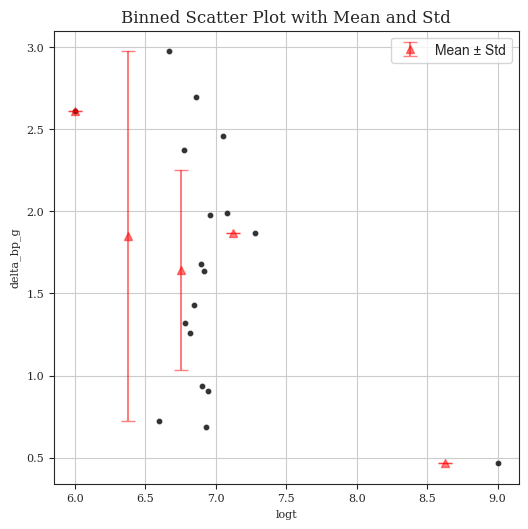

In [479]:
# Define bin edges
bins = np.linspace(6.0, 9.0, num=9) # 4

# Calculate bin statistics
bin_means, bin_edges, binnumber = stats.binned_statistic(clusters['logt'], clusters['delta_bp_g'],
                                                         statistic='mean', bins=bins)

bin_std, _, _ = stats.binned_statistic(clusters['logt'], clusters['delta_bp_g'],
                                 statistic='std', bins=bins)

# Scatter plot with error bars
# sns.scatterplot(clusters['logt'], clusters['delta_bp_rp'], color='black')
cmd_plot(clusters, 'logt', 'delta_bp_g', alpha=.8, s=20)
plt.errorbar(bin_edges[:-1], bin_means, yerr=bin_std, fmt='^',
            alpha=0.5, color='r', ecolor='r', capsize=5, label='Mean ± Std')

# Plot settings
plt.xlabel('logt')
plt.ylabel('delta_bp_g')
plt.title('Binned Scatter Plot with Mean and Std')
plt.legend()
plt.gca().invert_yaxis()
plt.grid(True)

# Show the plot
plt.show()

# Color excess ratios!

### G-R vs B-R

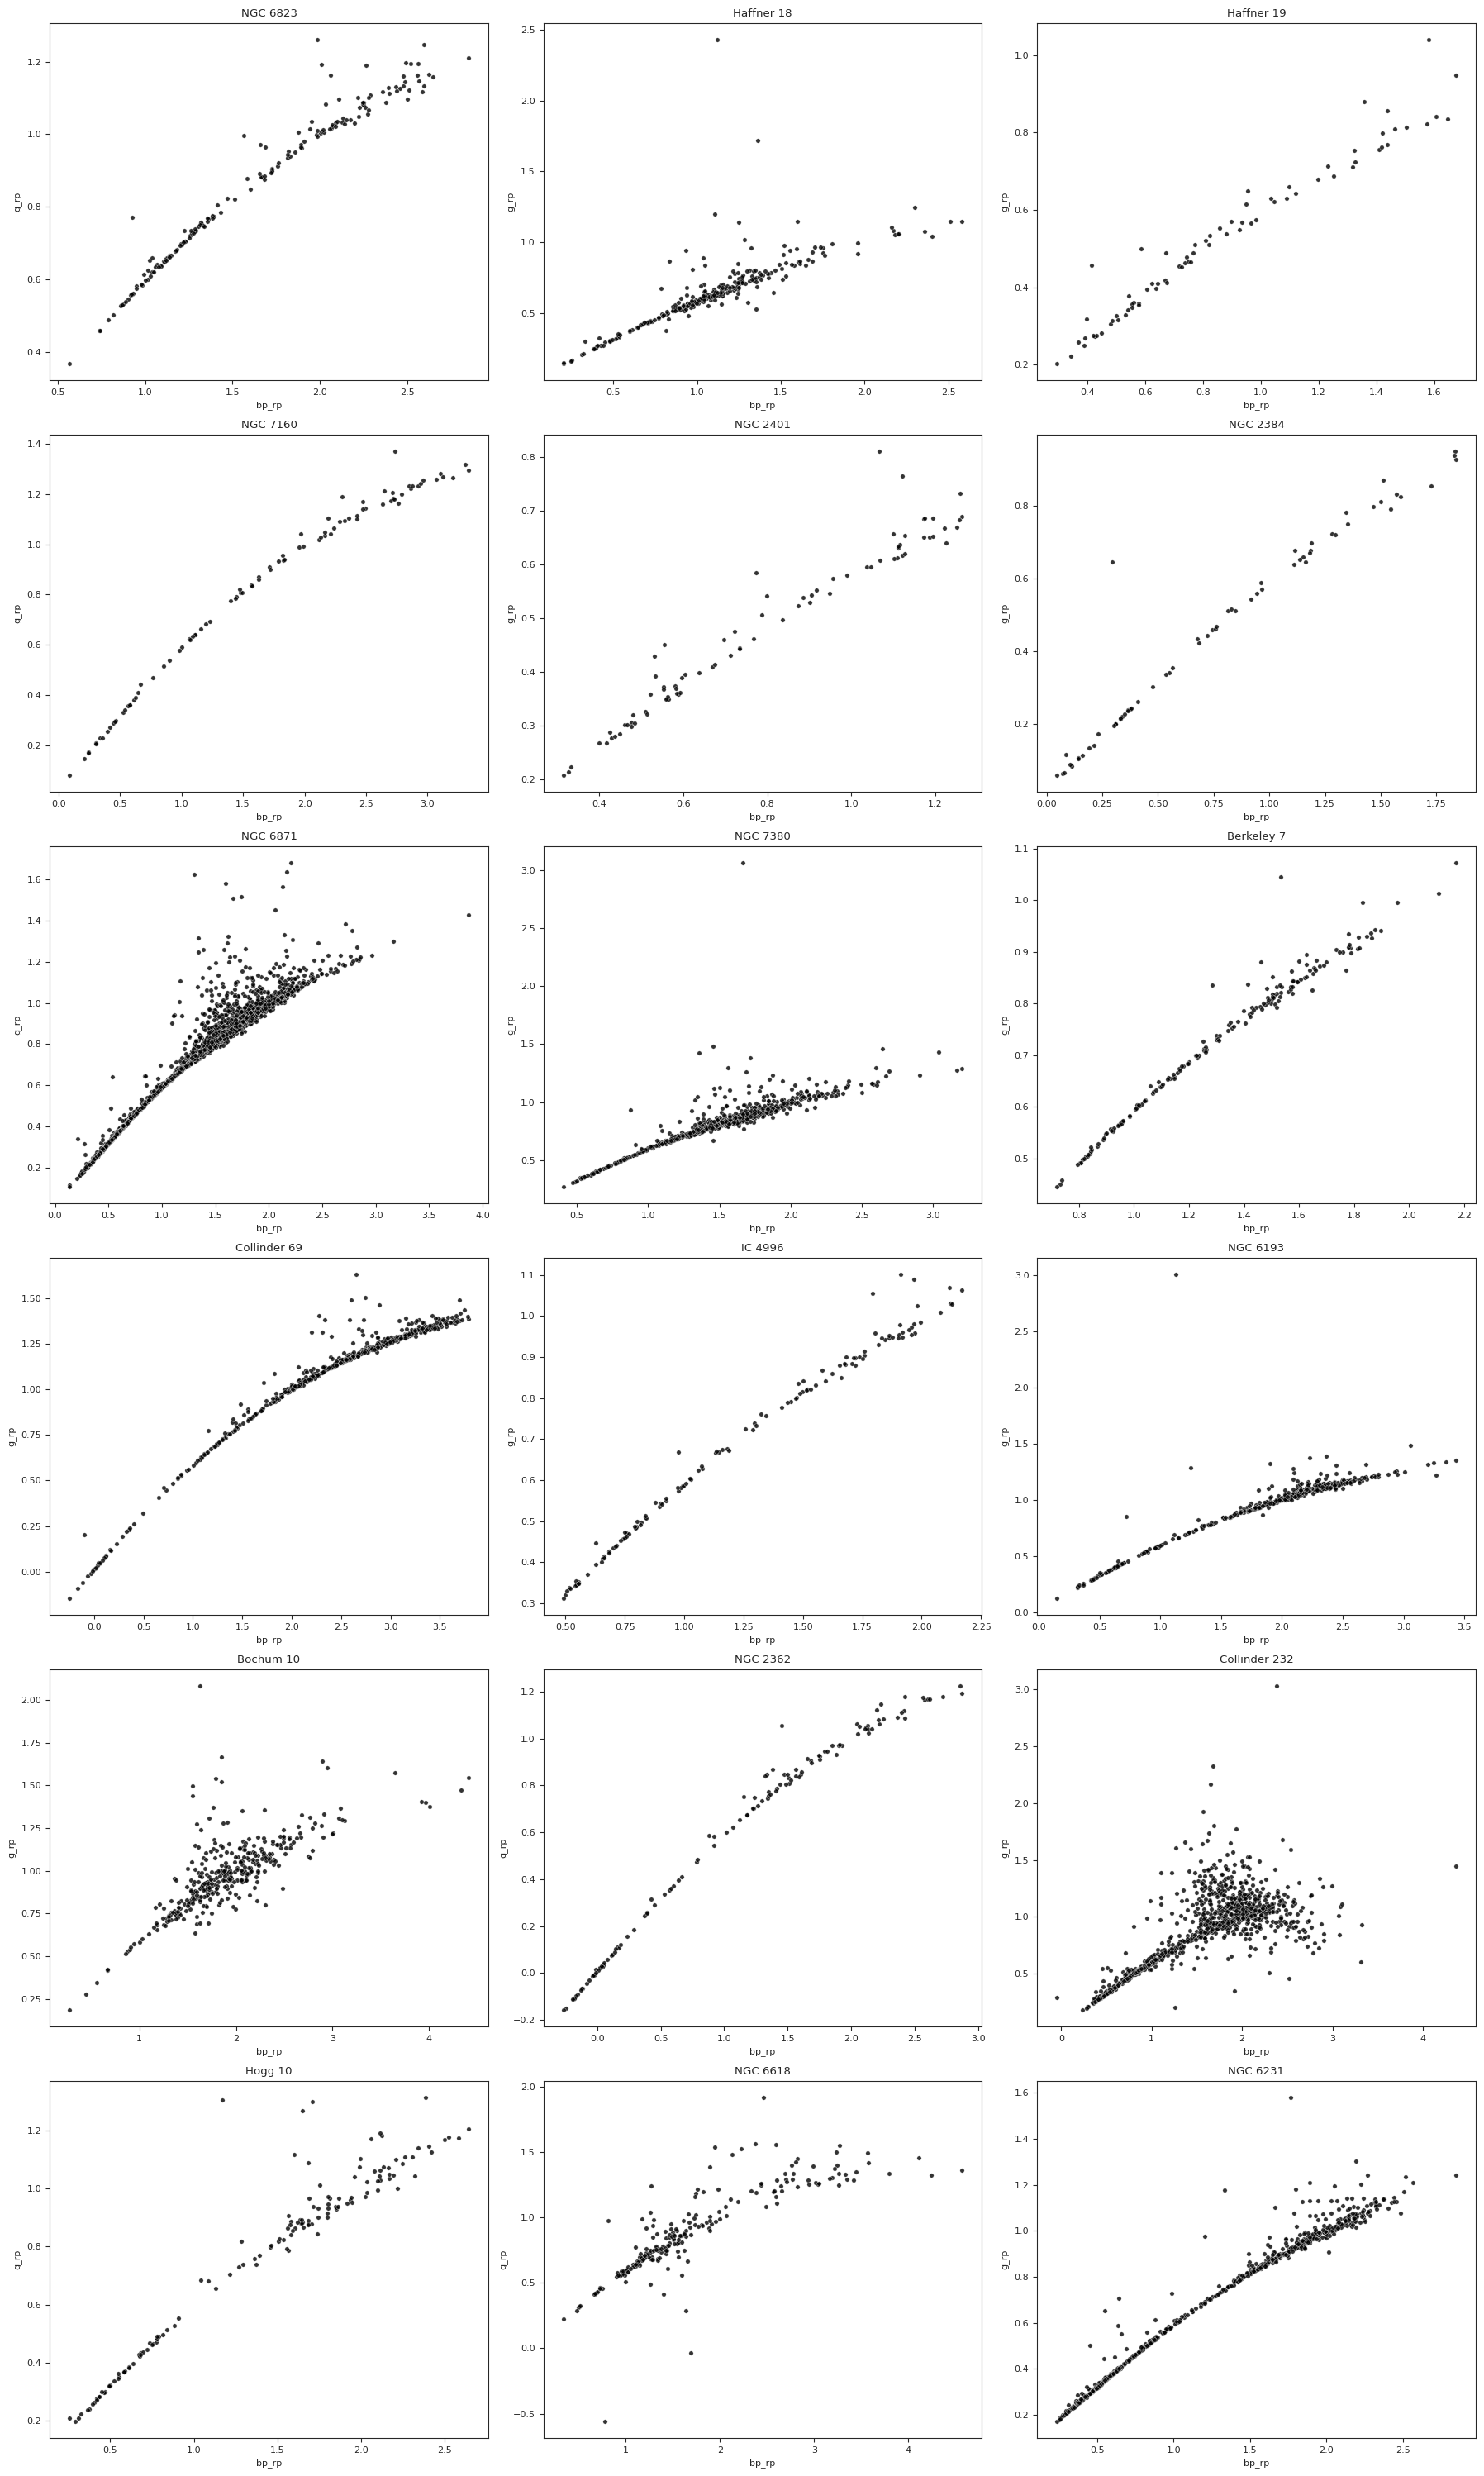

In [480]:
def black_body_plot(data, x_axis, y_axis, ax=None, alpha=0.8, s=15):
    
    if ax is None:
        fig = plt.figure(figsize=(4,8), dpi=100)
        ax = fig.add_subplot(111)
    sns.scatterplot(data=data, y=y_axis, x=x_axis, alpha=alpha, s=s, ax=ax)

with plt.style.context(['ieee']):
    fig, axes = plt.subplots(6, 3, figsize=(18, 30), dpi=100)

    black_body_plot(df_NGC_6823_cluster, 'bp_rp', 'g_rp', ax=axes[0, 0])
    axes[0, 0].set_title('NGC 6823')

    black_body_plot(df_Haffner_18_cluster, 'bp_rp', 'g_rp', ax=axes[0, 1])
    axes[0, 1].set_title('Haffner 18')

    black_body_plot(df_Haffner_19_cluster, 'bp_rp', 'g_rp', ax=axes[0, 2])
    axes[0, 2].set_title('Haffner 19')

    black_body_plot(df_NGC_7160_cluster, 'bp_rp', 'g_rp', ax=axes[1, 0])
    axes[1, 0].set_title('NGC 7160')

    black_body_plot(df_NGC_2401_cluster, 'bp_rp', 'g_rp', ax=axes[1, 1])
    axes[1, 1].set_title('NGC 2401')

    black_body_plot(df_NGC_2384_cluster, 'bp_rp', 'g_rp', ax=axes[1, 2])
    axes[1, 2].set_title('NGC 2384')

    black_body_plot(df_NGC_6871_cluster, 'bp_rp', 'g_rp', ax=axes[2, 0])
    axes[2, 0].set_title('NGC 6871')

    black_body_plot(df_NGC_7380_cluster, 'bp_rp', 'g_rp', ax=axes[2, 1])
    axes[2, 1].set_title('NGC 7380')

    black_body_plot(df_Berkeley_7_cluster, 'bp_rp', 'g_rp', ax=axes[2, 2])
    axes[2, 2].set_title('Berkeley 7')

    black_body_plot(df_Collinder_69_cluster, 'bp_rp', 'g_rp', ax=axes[3, 0])
    axes[3, 0].set_title('Collinder 69')

    black_body_plot(df_IC_4996_cluster, 'bp_rp', 'g_rp', ax=axes[3, 1])
    axes[3, 1].set_title('IC 4996')
    
    black_body_plot(df_NGC_6193_cluster, 'bp_rp', 'g_rp', ax=axes[3, 2])
    axes[3, 2].set_title('NGC 6193')
    
    black_body_plot(df_Bochum_10_cluster, 'bp_rp', 'g_rp', ax=axes[4, 0])
    axes[4, 0].set_title('Bochum 10')

    black_body_plot(df_NGC_2362_cluster, 'bp_rp', 'g_rp', ax=axes[4, 1])
    axes[4, 1].set_title('NGC 2362')

    black_body_plot(df_Collinder_232_cluster, 'bp_rp', 'g_rp', ax=axes[4, 2])
    axes[4, 2].set_title('Collinder 232')
    
    black_body_plot(df_Hogg_10_cluster, 'bp_rp', 'g_rp', ax=axes[5, 0])
    axes[5, 0].set_title('Hogg 10')

    black_body_plot(df_NGC_6618_cluster, 'bp_rp', 'g_rp', ax=axes[5, 1])
    axes[5, 1].set_title('NGC 6618')

    black_body_plot(df_NGC_6231_cluster, 'bp_rp', 'g_rp', ax=axes[5, 2])
    axes[5, 2].set_title('NGC 6231')
    
    
    plt.tight_layout()
    plt.show()

### B-G vs B-R  

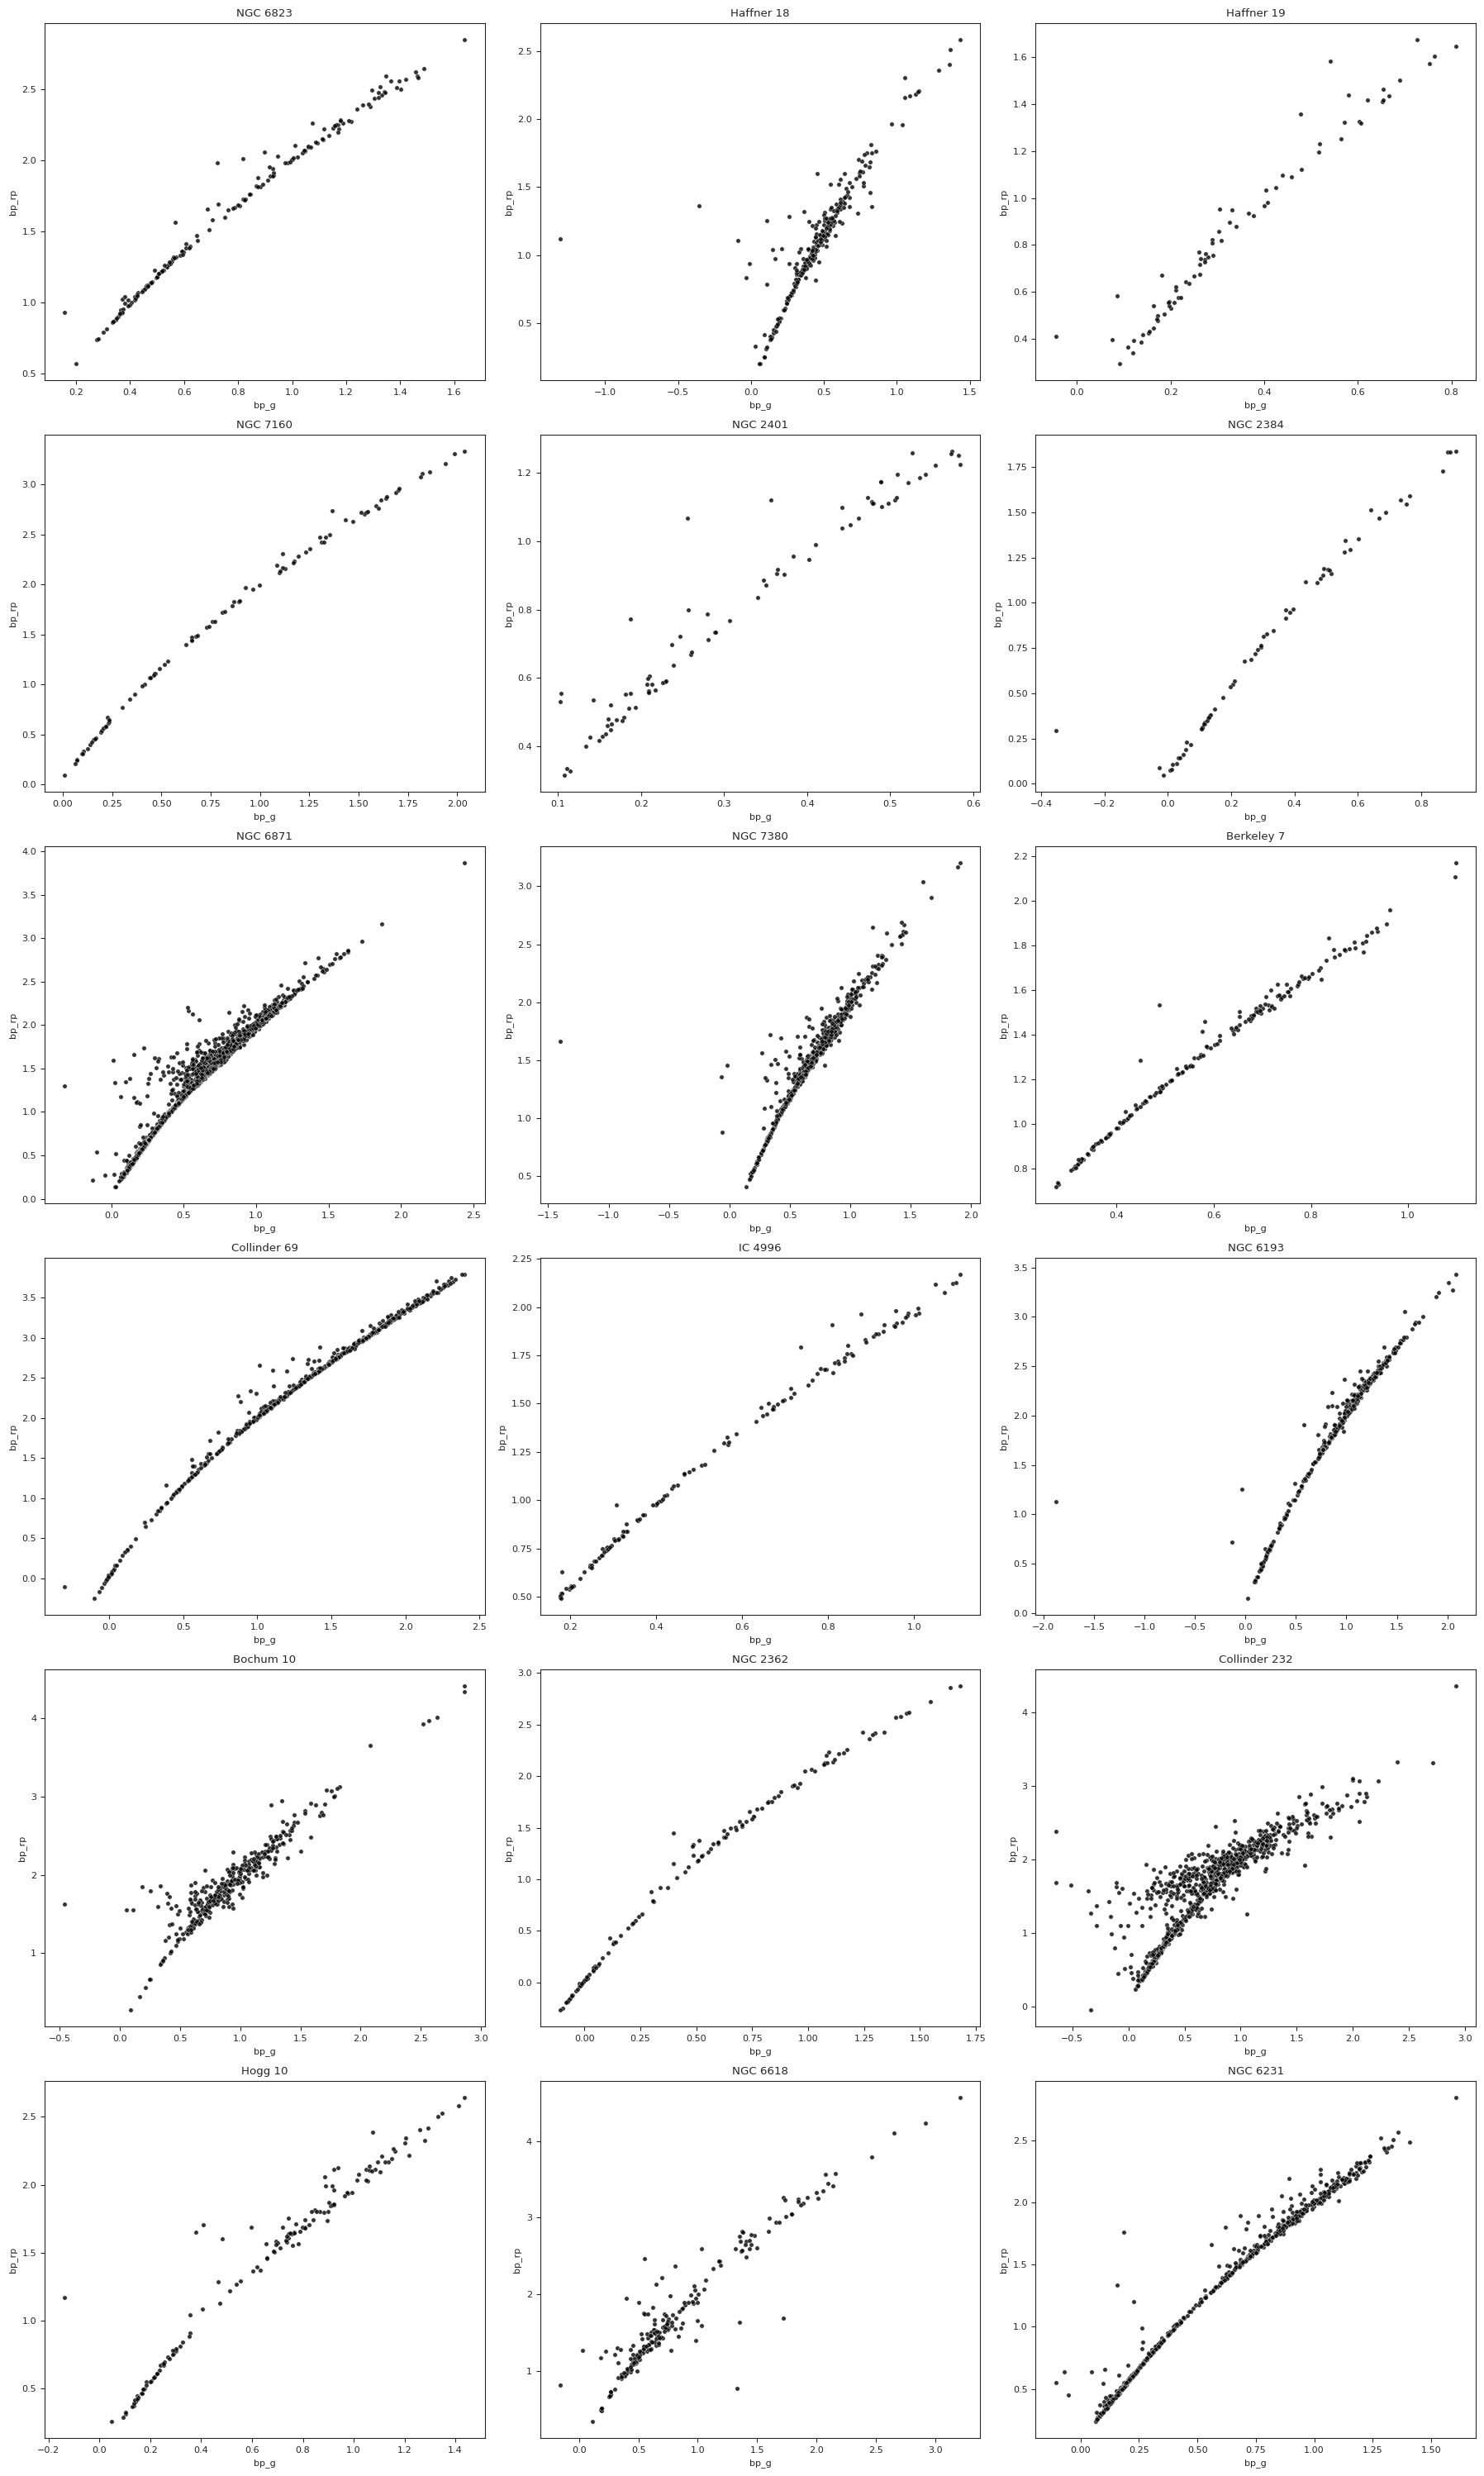

In [483]:
def black_body_plot(data, x_axis, y_axis, ax=None, alpha=0.8, s=15):
    
    if ax is None:
        fig = plt.figure(figsize=(4,8), dpi=100)
        ax = fig.add_subplot(111)
    sns.scatterplot(data=data, y=y_axis, x=x_axis, alpha=alpha, s=s, ax=ax)

with plt.style.context(['ieee']):
    fig, axes = plt.subplots(6, 3, figsize=(18, 30), dpi=100)

    black_body_plot(df_NGC_6823_cluster, 'bp_g', 'bp_rp', ax=axes[0, 0])
    axes[0, 0].set_title('NGC 6823')

    black_body_plot(df_Haffner_18_cluster, 'bp_g', 'bp_rp', ax=axes[0, 1])
    axes[0, 1].set_title('Haffner 18')

    black_body_plot(df_Haffner_19_cluster, 'bp_g', 'bp_rp', ax=axes[0, 2])
    axes[0, 2].set_title('Haffner 19')

    black_body_plot(df_NGC_7160_cluster, 'bp_g', 'bp_rp', ax=axes[1, 0])
    axes[1, 0].set_title('NGC 7160')

    black_body_plot(df_NGC_2401_cluster, 'bp_g', 'bp_rp', ax=axes[1, 1])
    axes[1, 1].set_title('NGC 2401')

    black_body_plot(df_NGC_2384_cluster, 'bp_g', 'bp_rp', ax=axes[1, 2])
    axes[1, 2].set_title('NGC 2384')

    black_body_plot(df_NGC_6871_cluster, 'bp_g', 'bp_rp', ax=axes[2, 0])
    axes[2, 0].set_title('NGC 6871')

    black_body_plot(df_NGC_7380_cluster, 'bp_g', 'bp_rp', ax=axes[2, 1])
    axes[2, 1].set_title('NGC 7380')

    black_body_plot(df_Berkeley_7_cluster, 'bp_g', 'bp_rp', ax=axes[2, 2])
    axes[2, 2].set_title('Berkeley 7')

    black_body_plot(df_Collinder_69_cluster, 'bp_g', 'bp_rp', ax=axes[3, 0])
    axes[3, 0].set_title('Collinder 69')

    black_body_plot(df_IC_4996_cluster, 'bp_g', 'bp_rp', ax=axes[3, 1])
    axes[3, 1].set_title('IC 4996')
    
    black_body_plot(df_NGC_6193_cluster, 'bp_g', 'bp_rp', ax=axes[3, 2])
    axes[3, 2].set_title('NGC 6193')
    
    black_body_plot(df_Bochum_10_cluster, 'bp_g', 'bp_rp', ax=axes[4, 0])
    axes[4, 0].set_title('Bochum 10')

    black_body_plot(df_NGC_2362_cluster, 'bp_g', 'bp_rp', ax=axes[4, 1])
    axes[4, 1].set_title('NGC 2362')

    black_body_plot(df_Collinder_232_cluster, 'bp_g', 'bp_rp', ax=axes[4, 2])
    axes[4, 2].set_title('Collinder 232')
    
    black_body_plot(df_Hogg_10_cluster, 'bp_g', 'bp_rp', ax=axes[5, 0])
    axes[5, 0].set_title('Hogg 10')

    black_body_plot(df_NGC_6618_cluster, 'bp_g', 'bp_rp', ax=axes[5, 1])
    axes[5, 1].set_title('NGC 6618')

    black_body_plot(df_NGC_6231_cluster, 'bp_g', 'bp_rp', ax=axes[5, 2])
    axes[5, 2].set_title('NGC 6231')
    
    
    plt.tight_layout()
    plt.show()

### G-R vs B-G

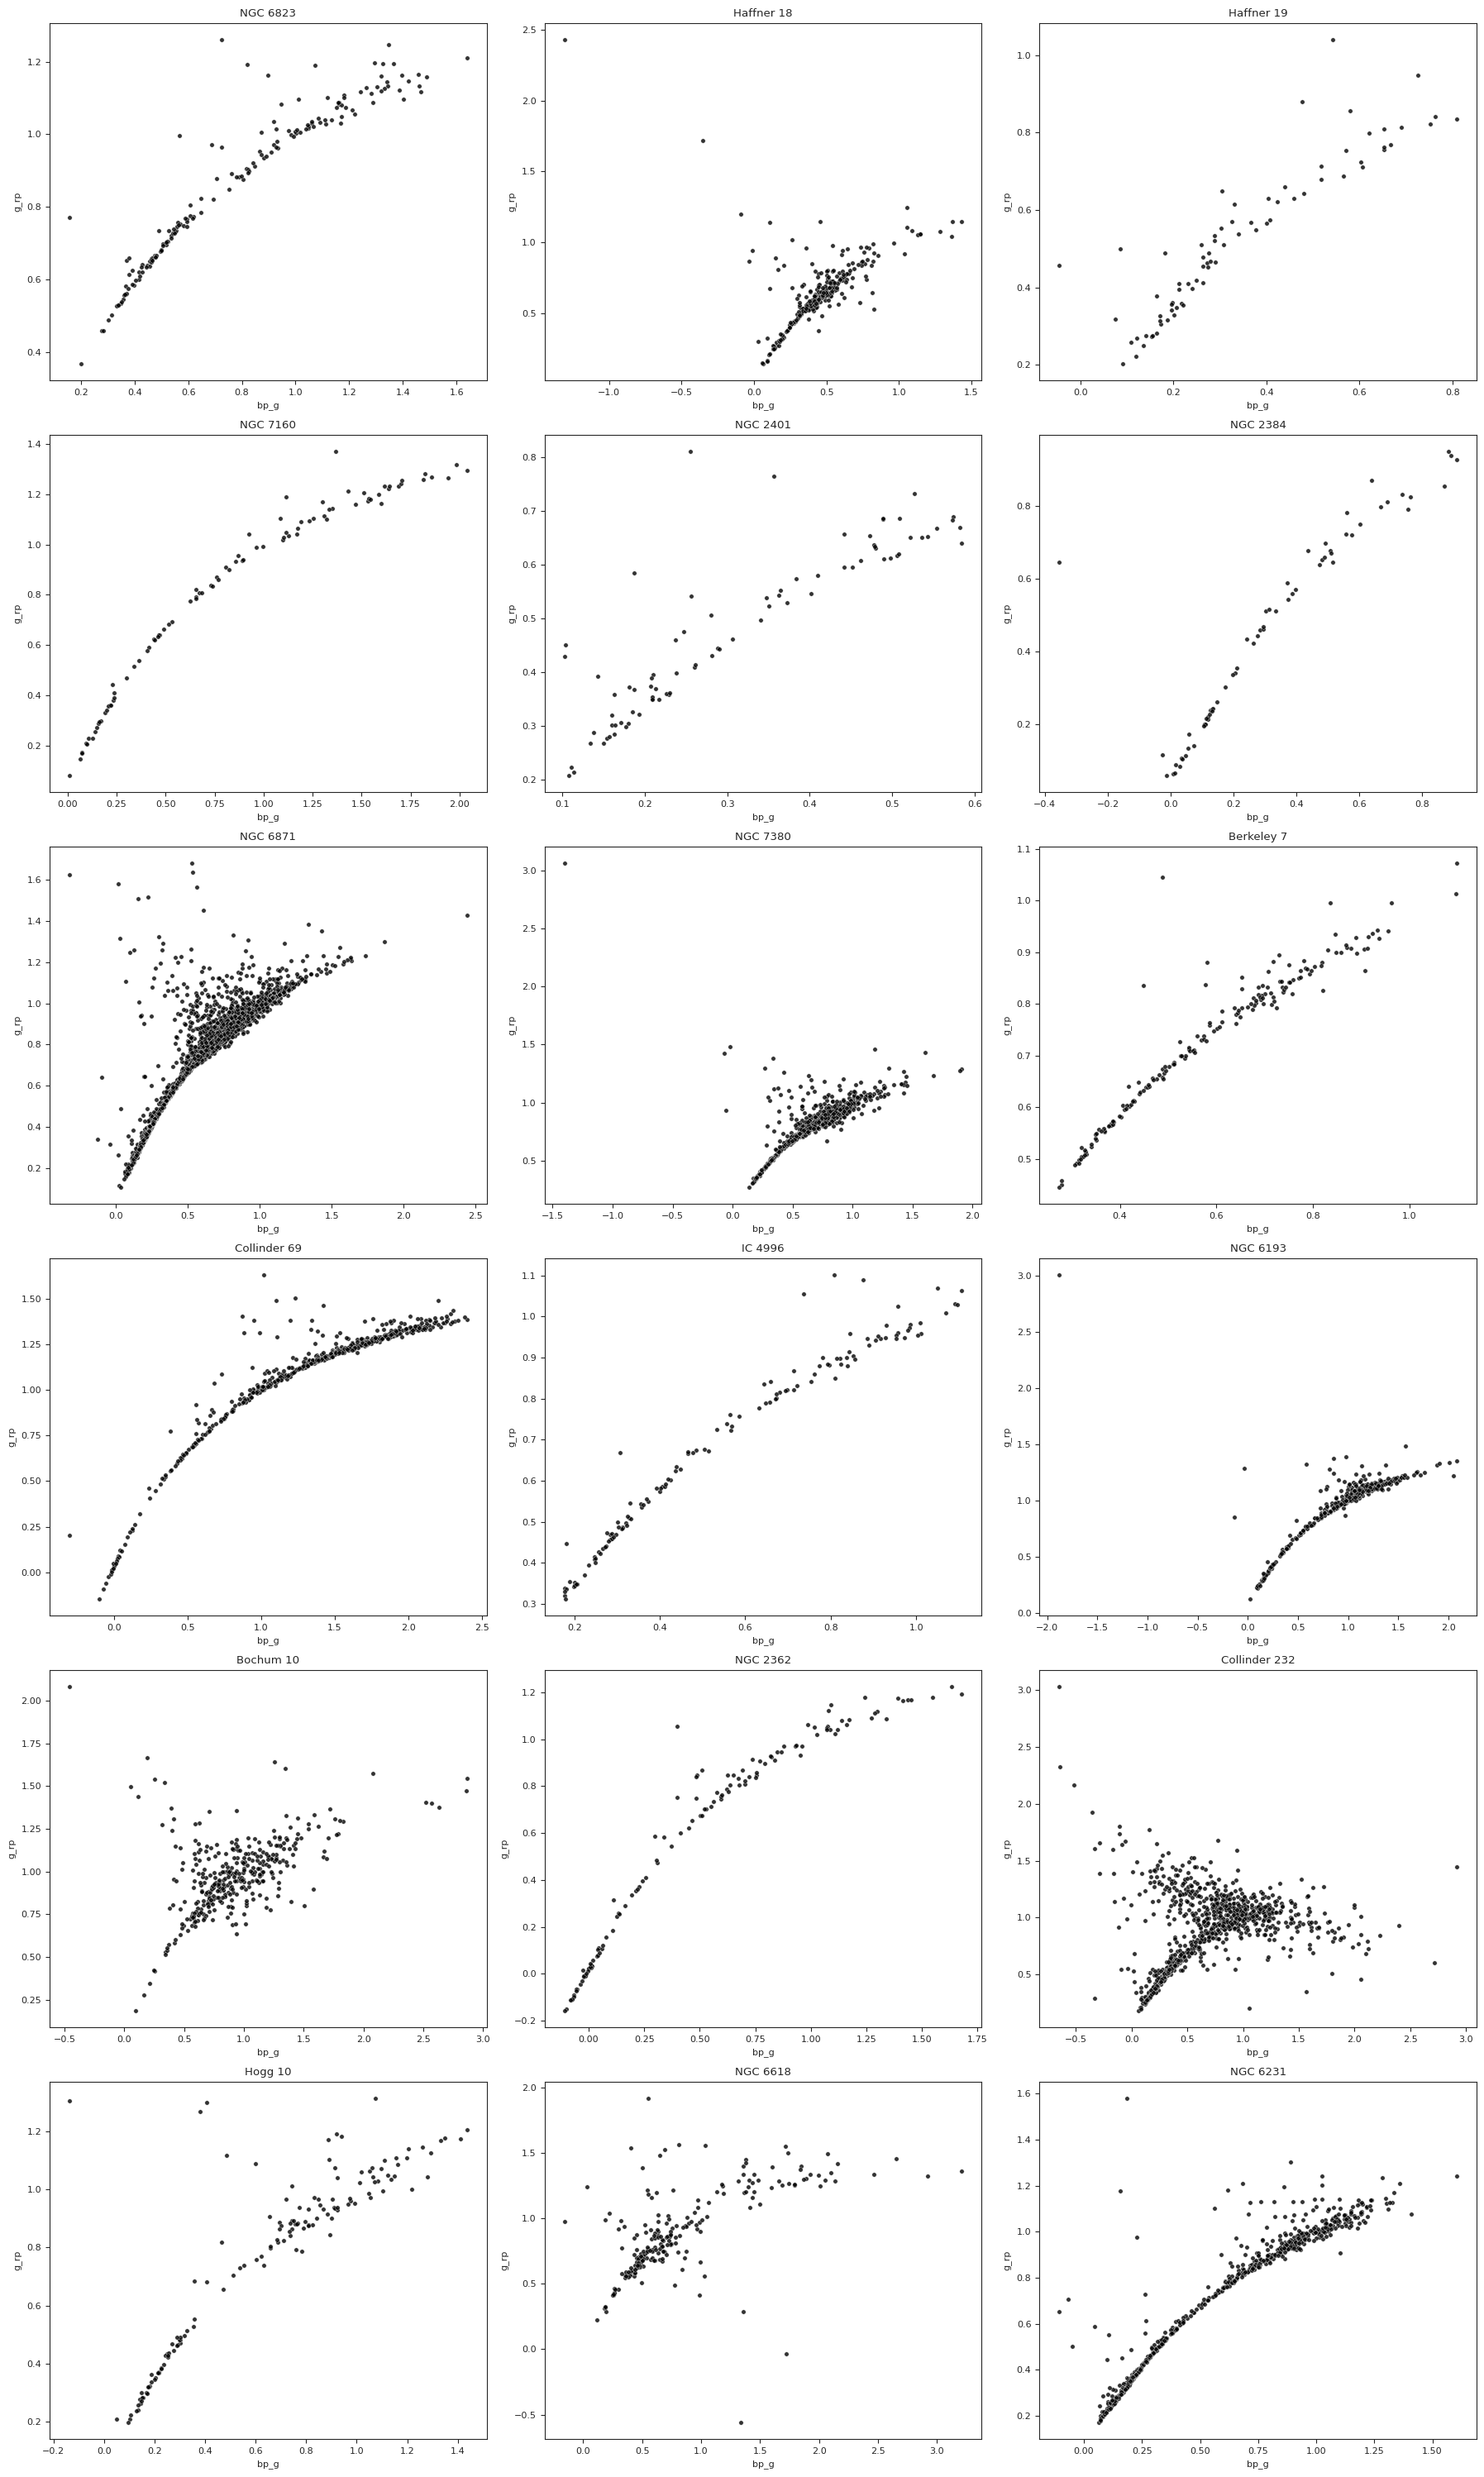

In [482]:
def black_body_plot(data, x_axis, y_axis, ax=None, alpha=0.8, s=15):
    
    if ax is None:
        fig = plt.figure(figsize=(4,8), dpi=100)
        ax = fig.add_subplot(111)
    sns.scatterplot(data=data, y=y_axis, x=x_axis, alpha=alpha, s=s, ax=ax)

with plt.style.context(['ieee']):
    fig, axes = plt.subplots(6, 3, figsize=(18, 30), dpi=100)

    black_body_plot(df_NGC_6823_cluster, 'bp_g', 'g_rp', ax=axes[0, 0])
    axes[0, 0].set_title('NGC 6823')

    black_body_plot(df_Haffner_18_cluster, 'bp_g', 'g_rp', ax=axes[0, 1])
    axes[0, 1].set_title('Haffner 18')

    black_body_plot(df_Haffner_19_cluster, 'bp_g', 'g_rp', ax=axes[0, 2])
    axes[0, 2].set_title('Haffner 19')

    black_body_plot(df_NGC_7160_cluster, 'bp_g', 'g_rp', ax=axes[1, 0])
    axes[1, 0].set_title('NGC 7160')

    black_body_plot(df_NGC_2401_cluster, 'bp_g', 'g_rp', ax=axes[1, 1])
    axes[1, 1].set_title('NGC 2401')

    black_body_plot(df_NGC_2384_cluster, 'bp_g', 'g_rp', ax=axes[1, 2])
    axes[1, 2].set_title('NGC 2384')

    black_body_plot(df_NGC_6871_cluster, 'bp_g', 'g_rp', ax=axes[2, 0])
    axes[2, 0].set_title('NGC 6871')

    black_body_plot(df_NGC_7380_cluster, 'bp_g', 'g_rp', ax=axes[2, 1])
    axes[2, 1].set_title('NGC 7380')

    black_body_plot(df_Berkeley_7_cluster, 'bp_g', 'g_rp', ax=axes[2, 2])
    axes[2, 2].set_title('Berkeley 7')

    black_body_plot(df_Collinder_69_cluster, 'bp_g', 'g_rp', ax=axes[3, 0])
    axes[3, 0].set_title('Collinder 69')

    black_body_plot(df_IC_4996_cluster, 'bp_g', 'g_rp', ax=axes[3, 1])
    axes[3, 1].set_title('IC 4996')
    
    black_body_plot(df_NGC_6193_cluster, 'bp_g', 'g_rp', ax=axes[3, 2])
    axes[3, 2].set_title('NGC 6193')
    
    black_body_plot(df_Bochum_10_cluster, 'bp_g', 'g_rp', ax=axes[4, 0])
    axes[4, 0].set_title('Bochum 10')

    black_body_plot(df_NGC_2362_cluster, 'bp_g', 'g_rp', ax=axes[4, 1])
    axes[4, 1].set_title('NGC 2362')

    black_body_plot(df_Collinder_232_cluster, 'bp_g', 'g_rp', ax=axes[4, 2])
    axes[4, 2].set_title('Collinder 232')
    
    black_body_plot(df_Hogg_10_cluster, 'bp_g', 'g_rp', ax=axes[5, 0])
    axes[5, 0].set_title('Hogg 10')

    black_body_plot(df_NGC_6618_cluster, 'bp_g', 'g_rp', ax=axes[5, 1])
    axes[5, 1].set_title('NGC 6618')

    black_body_plot(df_NGC_6231_cluster, 'bp_g', 'g_rp', ax=axes[5, 2])
    axes[5, 2].set_title('NGC 6231')
    
    
    plt.tight_layout()
    plt.show()

In [47]:
### REGRESSION

# with plt.style.context(['ieee']):
#     fig = plt.figure(figsize=(6,6), dpi=100)
    
#     sns.regplot(data=df_Berkeley_7_new[df_Berkeley_7_new['cluster'] == 0],
#                 x='g_rp', y=ffff['bp_rp'],
#                 x_ci='sd', order= 1,
#                 scatter_kws={'s':4, 'alpha':.5}, line_kws={'color': 'red', 'lw':1});

# B-R vs Mv

Apparent $V$ magnitudes are converted into absolute magnitude $M_V$ by the relation $M_V = V −(5logd−5 + A_V)$ where $A_V = 3.25*E(B − V)$

to conert this to $E(B-R)$ :

$
A_v = 3.25 * (A_R - A_B) / (R_b - 3.25) * E(B-R)  
$  

$
M_V = V −(5logd−5) - A_v
$

There is only a shift for Av so I use this:

$
A_v = 3.25 * E(B-R)  
$  

$
M_V = V −(5logd−5) - A_v
$

In [484]:
def add_Gmg(cluster, init_cluster):
    return cluster.merge(init_cluster[['ra','Gmg']], how='left')

In [485]:
df_NGC_6823_cluster = add_Gmg(df_NGC_6823_cluster, df_NGC_6823)
df_Haffner_18_cluster = add_Gmg(df_Haffner_18_cluster, df_Haffner_18)
df_Haffner_19_cluster = add_Gmg(df_Haffner_19_cluster, df_Haffner_19)
df_NGC_7160_cluster = add_Gmg(df_NGC_7160_cluster, df_NGC_7160)
df_NGC_6193_cluster = add_Gmg(df_NGC_6193_cluster, df_NGC_6193)
df_NGC_2401_cluster = add_Gmg(df_NGC_2401_cluster, df_NGC_2401)
df_NGC_2384_cluster = add_Gmg(df_NGC_2384_cluster, df_NGC_2384)
df_NGC_6871_cluster = add_Gmg(df_NGC_6871_cluster, df_NGC_6871)
df_NGC_7380_cluster = add_Gmg(df_NGC_7380_cluster, df_NGC_7380)
df_Berkeley_7_cluster = add_Gmg(df_Berkeley_7_cluster, df_Berkeley_7)
df_Collinder_69_cluster = add_Gmg(df_Collinder_69_cluster, df_Collinder_69)
df_IC_4996_cluster = add_Gmg(df_IC_4996_cluster, df_IC_4996)
df_Bochum_10_cluster = add_Gmg(df_Bochum_10_cluster, df_Bochum_10)
df_NGC_2362_cluster = add_Gmg(df_NGC_2362_cluster, df_NGC_2362)
df_Collinder_232_cluster = add_Gmg(df_Collinder_232_cluster, df_Collinder_232)
df_Hogg_10_cluster = add_Gmg(df_Hogg_10_cluster, df_Hogg_10)
df_NGC_6618_cluster = add_Gmg(df_NGC_6618_cluster, df_NGC_6618)
df_NGC_6231_cluster = add_Gmg(df_NGC_6231_cluster, df_NGC_6231)

In [486]:
dataframes = [df_NGC_6823_cluster, df_Haffner_18_cluster, df_Haffner_19_cluster, df_NGC_7160_cluster, df_NGC_6193_cluster, df_NGC_2401_cluster, df_NGC_2384_cluster, df_NGC_6871_cluster, df_NGC_7380_cluster, df_Berkeley_7_cluster, df_Collinder_69_cluster, df_IC_4996_cluster, df_Bochum_10_cluster, df_NGC_2362_cluster, df_Collinder_232_cluster, df_Hogg_10_cluster, df_NGC_6618_cluster, df_NGC_6231_cluster]

In [493]:
for cluster in dataframes:
    cluster['Gmg2'] = cluster['Gmg'] - (3.25 * .7 * cluster['bp_g'])

In [494]:
def color_exc_to_Gmg(data, x_axis = 'Gmg2', y_axis = 'bp_g', alpha=0.5, s=15, num_bins=10):
    # Define bin edges
    bins = np.linspace(data[x_axis].min(), data[x_axis].max(), num=num_bins)

    # Calculate bin statistics
    bin_means, bin_edges, binnumber = stats.binned_statistic(data[x_axis], data[y_axis], statistic='mean', bins=bins)
    bin_std, _, _ = stats.binned_statistic(data[x_axis], data[y_axis], statistic='std', bins=bins)

    # Scatter plot with error bars
    fig = plt.figure(figsize=(6,3), dpi=100)
    ax = fig.add_subplot(111)
    sns.scatterplot(data=data, y=y_axis, x=x_axis, alpha=alpha, s=s)
    plt.errorbar(bin_edges[:-1], bin_means, yerr=bin_std, fmt='^',
                alpha=alpha, color='r', ecolor='r', capsize=5, label='Mean ± Std')
    
    plt.title(convert_to_cluster_name(namestr(data, globals())[0]))
    plt.legend()
    plt.grid(True)

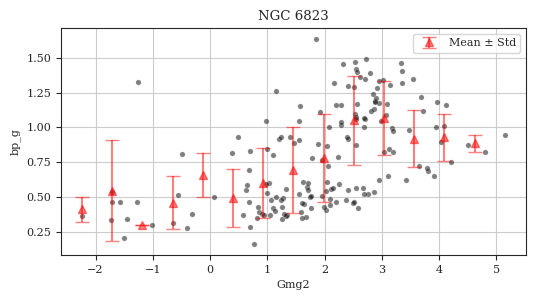

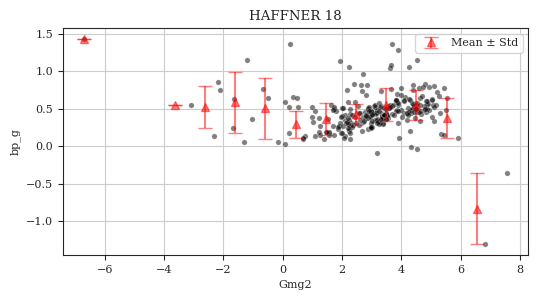

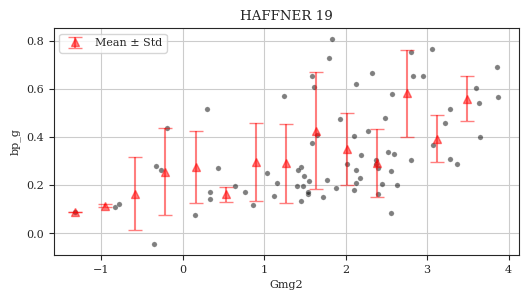

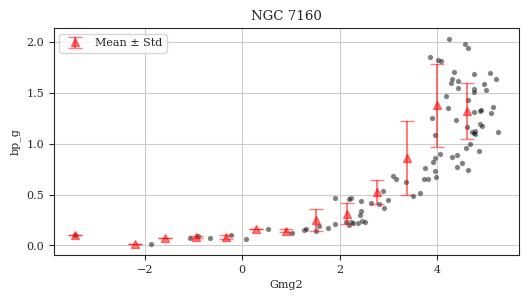

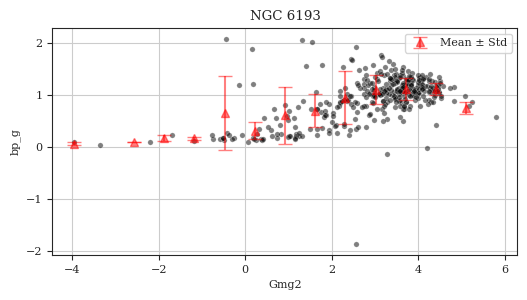

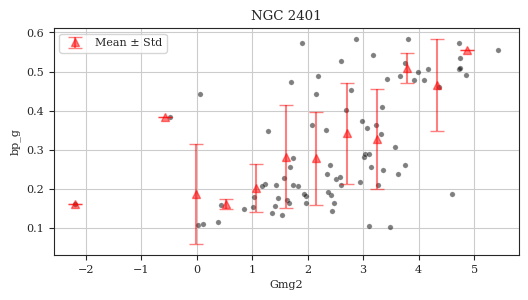

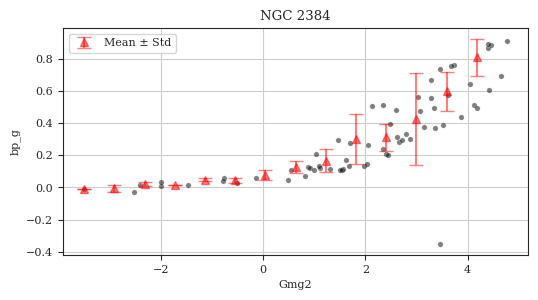

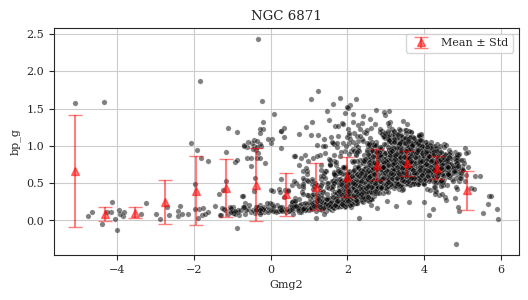

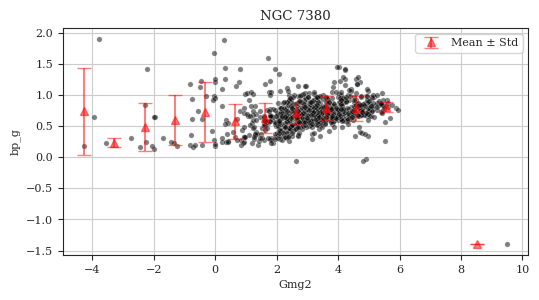

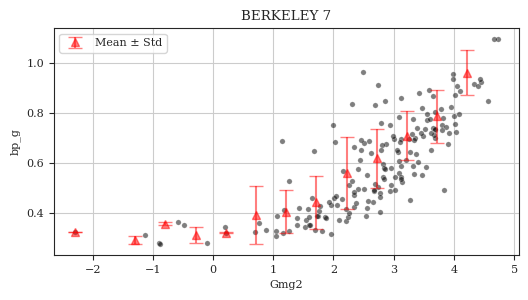

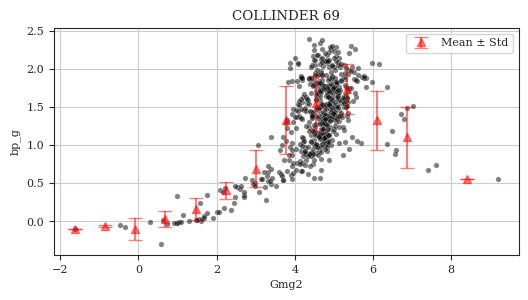

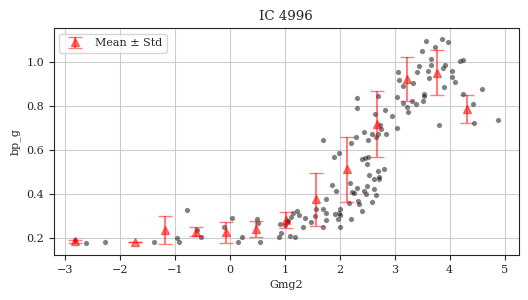

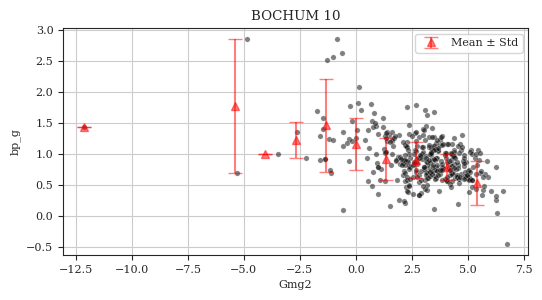

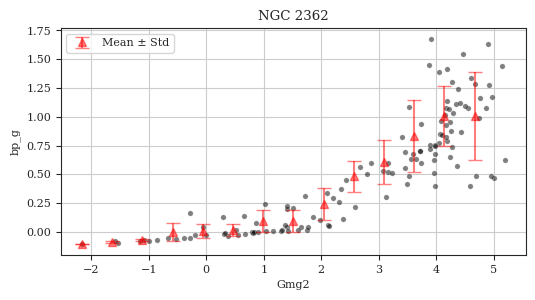

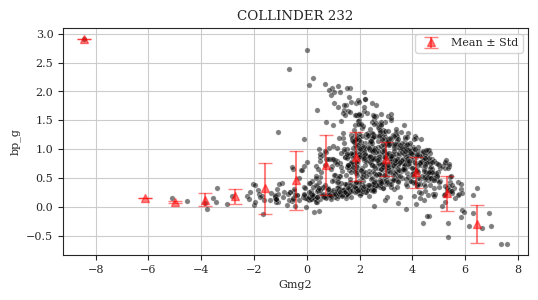

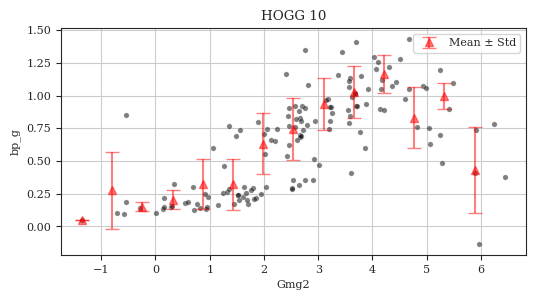

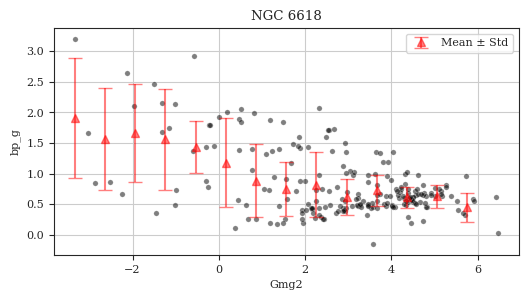

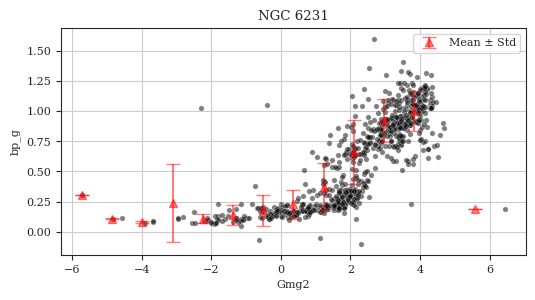

In [495]:
with plt.style.context(['ieee']):
    
    for cluster in dataframes:
        color_exc_to_Gmg(cluster, 'Gmg2', 'bp_g', num_bins=15)

# King Profile

$
ρ(r) = \frac{ρ_0}{1 + \left(\frac{r}{r_c}\right)^2} - f_b \cdot ρ_b(r) + f_0 \cdot ρ_0
$  
where:

ρ(r) is the stellar density at a given radius r,  
ρ_0 is the central stellar density,  
r_c is the core radius,  
f_b is the fraction of stars bound to the cluster,  
ρ_b(r) is the density profile of the bound stars, and  
f_0 is the fraction of field stars contributing to the background level of density.  

In the equation, the term - $f_b \cdot ρ_b(r)$ represents the contribution of the bound stars to the density profile, and the term + $f_0 \cdot ρ_0$ represents the contribution of the field stars to the background density.

$
f(r) = \frac{f_0}{1 + \left(\frac{r}{R_c}\right)^2} + f_b 
$  

In [610]:
print(center[0] + np.linspace(0, 2.05, 20))
print(center[1] + np.linspace(0, 2.05, 20))

[83.82047429 83.92836902 84.03626376 84.1441585  84.25205323 84.35994797
 84.46784271 84.57573744 84.68363218 84.79152692 84.89942165 85.00731639
 85.11521113 85.22310586 85.3310006  85.43889534 85.54679007 85.65468481
 85.76257955 85.87047429]
[ 9.79697206  9.90486679 10.01276153 10.12065627 10.228551   10.33644574
 10.44434048 10.55223521 10.66012995 10.76802469 10.87591942 10.98381416
 11.0917089  11.19960363 11.30749837 11.41539311 11.52328784 11.63118258
 11.73907732 11.84697206]


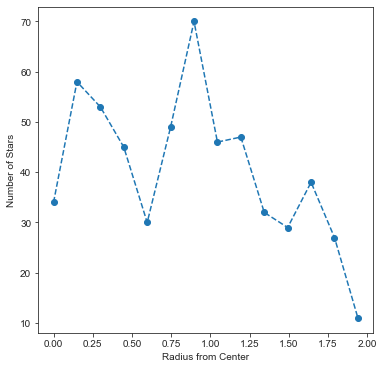

In [623]:
import numpy as np
import matplotlib.pyplot as plt

df_Collinder_69_cluster = ...  # Your DataFrame containing 'ra' and 'dec' columns

center = (83.820474, 9.796972)
radii = np.linspace(0, 2.05, 10)  # Define the radii of the concentric circles

star_densities = []
for i in range(len(radii) - 1):
    r_inner = radii[i]
    r_outer = radii[i + 1]

    # Calculate the distances between the center and each star's position
    distances = np.sqrt((df_Collinder_69_cluster['ra'] - center[0])**2 + (df_Collinder_69_cluster['dec'] - center[1])**2)

    # Count the number of stars within the current circle
    stars_within_circle = df_Collinder_69_cluster[(distances >= r_inner) & (distances < r_outer)]
    star_count = len(stars_within_circle)

    # Calculate the area of the circle
    circle_area = np.pi * (r_outer**2 - r_inner**2)

    # Calculate the star density within the circle
    star_density = star_count / circle_area
    star_densities.append(star_density)

# Plotting the density profile
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(radii[:-1], star_densities, marker='o')
ax.set_xlabel('Radius from Center')
ax.set_ylabel('Star Density')
plt.show()